# Standard CSP pipelines

This notebook implements multiple standard CSP pipelines and tests their performance on the data from the database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211).
The knowledge and utilities obtained from the experimental notebooks four to five are used throughout this notebook.

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
Baseline correction was done on the first second of the epoch, meaning the second before the visual queue was shown.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
- Same subject, same session
   - Same subject, same session: LDA classifier 
   - Same subject, same session: SVM classifier 
   - Same subject, same session: RF classifier 
- Same subject, new session
   - Same subject, new session: LDA classifier
   - Same subject, new session: SVM classifier
   - Same subject, new session: RF classifier
- New subject
   - New subject: LDA classifier
   - New subject: SVM classifier
   - New subject: RF classifier

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# IO functions
from IPython.utils import io
import copy

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

MNE version (1.0.2 recommended): 1.0.2
Scikit-learn version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Matplotlib version (3.5.1 recommended): 3.5.1
Pickle version (4.0 recommended): 4.0


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Same subject, same session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
We do this for three different traditional machine learning classifiers: linear discriminant analysis (LDA), support vector machines (SVM) and random forest (RF).
K-nearest neighbour (KNN) is not considered as it is too time-consuming in predictions and complex models such as a multilayer perceptron (MLP) are not considered either as they are an integral part of the deep learning models considered in later notebooks.

<hr>

### Same subject, same session: LDA classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> LDA
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [4]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                h_freq= filter_upper_bound,
                                picks= "all",
                                phase= "minimum",
                                fir_window= "blackman",
                                fir_design= "firwin",
                                pad= 'median', 
                                n_jobs= -1,
                                verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001, 0.00001, 0.001, 0.0004, 0.00007]
                               },
                              {"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["lsqr" , "eigen"]
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, 
                                y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_svm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_svm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del lda
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.6615 +- 0.0504                         | 0.6094                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7144 +- 0.0341                         | 0.7240                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7342 +- 0.0171                         | 0.7277                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |

In [5]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {np.round(grid_search.best_score_, 4)} +- {np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4)} with the following parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.6615 +- 0.0504 with the following parameters
{'CSP__n_components': 6, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
17       2.638366      0.048087         0.002499    8.656529e-04   
15       2.620203      0.050450         0.010247    9.281167e-03   
19       2.575015      0.037268         0.003250    4.326721e-04   
18       2.600368      0.093760         0.003749    2.486504e-03   
31       3.828332      0.061491         0.002750    8.287726e-04   
32       2.727811      0.112638         0.003249    4.323963e-04   
16       2.634050      0.059822         0.002499    8.656874e-04   
29       2.634230      0.069445         0.002499    8.656185e-04   
10       2.596897      0.081477         0.002000    1.685874e-07   
11       2.542957      0.050572         0.001500    4.998446e-04   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
17                       6               svd          0.001   
15                       6               svd         0.0001   
19                       6               svd        0.00007   
18                       6               svd         0.0004   
31                       6              lsqr            NaN   
32                       6             eigen            NaN   
16                       6               svd        0.00001   
29                       4              lsqr            NaN   
10                       4               svd         0.0001   
11                       4               svd        0.00001   

    split0_test_score  split1_test_score  split2_test_score  \
17           0.578125           0.708333           0.666667   
15           0.578125           0.708333           0.666667   
19           0.578125           0.708333           0.666667   
18           0.578125           0.708333           0.666667   
31           0.578125           0.708333           0.666667   
32           0.578125           0.708333           0.666667   
16           0.578125           0.708333           0.666667   
29           0.614583           0.692708           0.671875   
10           0.614583           0.692708           0.671875   
11           0.614583           0.692708           0.671875   

    split3_test_score  mean_test_score  std_test_score  rank_test_score  \
17           0.692708         0.661458        0.050362                1   
15           0.692708         0.661458        0.050362                1   
19           0.692708         0.661458        0.050362                1   
18           0.692708         0.661458        0.050362                1   
31           0.692708         0.661458        0.050362                1   
32           0.692708         0.661458        0.050362                1   
16           0.692708         0.661458        0.050362                1   
29           0.661458         0.660156        0.028616                8   
10           0.661458         0.660156        0.028616                8   
11           0.661458         0.660156        0.028616                8   

    split0_train_score  split1_train_score  split2_train_score  \
17            0.722222            0.684028            0.689236   
15            0.722222            0.684028            0.689236   
19            0.722222            0.684028            0.689236   
18            0.722222            0.684028            0.689236   
31            0.720486            0.682292            0.689236   
32            0.720486            0.682292            0.689236   
16            0.722222            0.684028            0.689236   
29            0.697917            0.666667            0.694444   
10            0.699653            0.666667            0.694444   
11            0.699653            0.666667            0.694444   

    split3_train_score  mean_train_score  std_train_score  
17            0.696181          0.697917         0.014680  
15            0.696181          0.697917         0.014680  
19            0.696181          0.697917         0.014680  
18            0.696181          0.697917         0.014680  
31            



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
22       2.560733      0.046330         0.006748        0.004814   
23       2.698398      0.044207         0.003499        0.000500   
24       2.619778      0.046420         0.005000        0.003464   
1        2.690685      0.016161         0.002749        0.001920   
2        3.448836      0.068553         0.001750        0.000433   
26       2.667278      0.062282         0.002250        0.000433   
4        2.847526      0.058999         0.001750        0.000432   
25       2.632682      0.062124         0.001750        0.000433   
3        2.971258      0.054610         0.001750        0.000829   
0        2.860130      0.053891         0.002000        0.001224   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
22                      10               svd          0.001   
23                      10               svd         0.0004   
24                      10               svd        0.00007   
1                        2               svd        0.00001   
2                        2               svd          0.001   
26                       2             eigen            NaN   
4                        2               svd        0.00007   
25                       2              lsqr            NaN   
3                        2               svd         0.0004   
0                        2               svd         0.0001   

    split0_test_score  split1_test_score  split2_test_score  \
22           0.598958           0.656250           0.671875   
23           0.598958           0.656250           0.671875   
24           0.598958           0.656250           0.671875   
1            0.609375           0.505208           0.526042   
2            0.609375           0.505208           0.526042   
26           0.609375           0.505208           0.526042   
4            0.609375           0.505208           0.526042   
25           0.609375           0.505208           0.526042   
3            0.609375           0.505208           0.526042   
0            0.609375           0.505208           0.526042   

    split3_test_score  mean_test_score  std_test_score  rank_test_score  \
22           0.651042         0.644531        0.027406               24   
23           0.651042         0.644531        0.027406               24   
24           0.651042         0.644531        0.027406               24   
1            0.651042         0.572917        0.059612               29   
2            0.651042         0.572917        0.059612               29   
26           0.651042         0.572917        0.059612               29   
4            0.651042         0.572917        0.059612               29   
25           0.651042         0.572917        0.059612               29   
3            0.651042         0.572917        0.059612               29   
0            0.651042         0.572917        0.059612               29   

    split0_train_score  split1_train_score  split2_train_score  \
22            0.729167            0.750000            0.715278   
23            0.729167            0.750000            0.715278   
24            0.729167            0.750000            0.715278   
1             0.664931            0.522569            0.541667   
2             0.664931            0.522569            0.541667   
26            0.664931            0.522569            0.541667   
4             0.664931            0.522569            0.541667   
25            0.664931            0.522569            0.541667   
3             0.664931            0.522569            0.541667   
0             0.664931            0.522569            0.541667   

    split3_train_score  mean_train_score  std_train_score  
22            0.718750          0.728299         0.013532  
23            0.718750          0.728299         0.013532  
24            0.718750          0.728299         0.013532  
1             0.661458          0.597656         0.065897  
2             



In total there are 35 different configurations tested.
The best mean test score is 0.6615
There are 7 configurations with this maximum score
There are 28 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       28.000000     28.000000        28.000000    2.800000e+01   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         2.661364      0.060151         0.003457    1.805770e-03   
std          0.236873      0.020000         0.002313    2.365813e-03   
min          2.469499      0.022866         0.001500    1.685874e-07   
25%          2.584624      0.046398         0.001937    4.996064e-04   
50%          2.611223      0.058192         0.002999    8.656357e-04   
75%          2.674828      0.068168         0.003811    2.166935e-03   
max          3.828332      0.112638         0.010247    9.281167e-03   

        param_CSP__n_components param_LDA__solver  param_LDA__tol  \
count                      28.0                28          20.000   
unique                      4.0                 3           5.000   
top                         6.0               svd           0.001   
freq                        7.0                20           4.000   
mean                        NaN               NaN             NaN   
std                         NaN               NaN             NaN   
min                         NaN               NaN             NaN   
25%                         NaN               NaN             NaN   
50%                         NaN               NaN             NaN   
75%                         NaN               NaN             NaN   
max                         NaN               NaN             NaN   

        split0_test_score  split1_test_score  split2_test_score  \
count           28.000000          28.000000          28.000000   
unique                NaN                NaN                NaN   
top                   NaN                NaN                NaN   
freq                  NaN                NaN                NaN   
mean             0.595424           0.685268           0.664435   
std              0.013600           0.018775           0.011289   
min              0.578125           0.656250           0.645833   
25%              0.585938           0.677083           0.661458   
50%              0.596354           0.687500           0.669271   
75%              0.602865           0.696615           0.671875   
max              0.614583           0.708333           0.677083   

        split3_test_score  mean_test_score  std_test_score  rank_test_score  \
count           28.000000        28.000000       28.000000        28.000000   
unique                NaN              NaN             NaN              NaN   
top                   NaN              NaN             NaN              NaN   
freq                  NaN              NaN             NaN              NaN   
mean             0.667969         0.653274        0.035462        12.071429   
std              0.015633         0.007722        0.009210         8.519818   
min              0.651042         0.644531        0.027406         1.000000   
25%              0.658854         0.645833        0.028616         6.250000   
50%              0.664062         0.653646        0.031372        11.500000   
75%              0.673177         0.660482        0.039228        19.000000   
max              0.692708         0.661458        0.050362        24.000000   

        split0_train_score  split1_train_score  split2_train_score  \
count            28.000000           28.000000           28.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.706225            0.691716            0.694134   
std               0.021296            0.034980            0.014254   
min               0.675347            0.666667            0.677083   





####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.7144 +- 0.0341 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
34       2.915794      0.092838         0.003749        0.000829   
24       2.820352      0.114471         0.010747        0.012271   
23       2.757913      0.079570         0.013246        0.017748   
22       2.836415      0.134609         0.004249        0.000829   
21       2.743798      0.063981         0.004749        0.001920   
20       2.835930      0.074028         0.004249        0.000433   
33       2.963102      0.101336         0.003749        0.000828   
19       2.729544      0.103255         0.002250        0.000433   
18       2.758624      0.100434         0.002749        0.000829   
16       2.737050      0.137008         0.002250        0.000432   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
34                      10             eigen            NaN   
24                      10               svd        0.00007   
23                      10               svd         0.0004   
22                      10               svd          0.001   
21                      10               svd        0.00001   
20                      10               svd         0.0001   
33                      10              lsqr            NaN   
19                       6               svd        0.00007   
18                       6               svd         0.0004   
16                       6               svd        0.00001   

    split0_test_score  split1_test_score  split2_test_score  \
34           0.755208           0.671875           0.739583   
24           0.755208           0.671875           0.739583   
23           0.755208           0.671875           0.739583   
22           0.755208           0.671875           0.739583   
21           0.755208           0.671875           0.739583   
20           0.755208           0.671875           0.739583   
33           0.755208           0.671875           0.739583   
19           0.744792           0.656250           0.703125   
18           0.744792           0.656250           0.703125   
16           0.744792           0.656250           0.703125   

    split3_test_score  mean_test_score  std_test_score  rank_test_score  \
34           0.691099         0.714442        0.034098                1   
24           0.691099         0.714442        0.034098                1   
23           0.691099         0.714442        0.034098                1   
22           0.691099         0.714442        0.034098                1   
21           0.691099         0.714442        0.034098                1   
20           0.691099         0.714442        0.034098                1   
33           0.691099         0.714442        0.034098                1   
19           0.732984         0.709288        0.034180                8   
18           0.732984         0.709288        0.034180                8   
16           0.732984         0.709288        0.034180                8   

    split0_train_score  split1_train_score  split2_train_score  \
34            0.772174            0.718261            0.753043   
24            0.772174            0.718261            0.751304   
23            0.772174            0.718261            0.751304   
22            0.772174            0.718261            0.751304   
21            0.772174            0.718261            0.751304   
20            0.772174            0.718261            0.751304   
33            0.772174            0.718261            0.753043   
19            0.766957            0.711304            0.749565   
18            0.766957            0.711304            0.749565   
16            0.766957            0.711304            0.749565   

    split3_train_score  mean_train_score  std_train_score  
34            0.756944          0.750106         0.019726  
24            0.756944          0.749671         0.019676  
23            0.756944          0.749671         0.019676  
22            0.756944          0.749671         0.019676  
21            



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5        2.657662      0.055349         0.001500        0.000499   
28       2.869725      0.119720         0.001499        0.000500   
27       2.874114      0.081583         0.001749        0.000433   
2        2.873989      0.139466         0.001749        0.000433   
25       2.965988      0.100436         0.001750        0.000432   
1        3.268848      0.095755         0.001999        0.000707   
3        2.706552      0.076533         0.004249        0.004491   
4        2.616163      0.072099         0.001750        0.000432   
26       2.815629      0.050155         0.002249        0.000432   
0        3.246334      0.148674         0.001500        0.000499   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
5                        3               svd         0.0001   
28                       3             eigen            NaN   
27                       3              lsqr            NaN   
2                        2               svd          0.001   
25                       2              lsqr            NaN   
1                        2               svd        0.00001   
3                        2               svd         0.0004   
4                        2               svd        0.00007   
26                       2             eigen            NaN   
0                        2               svd         0.0001   

    split0_test_score  split1_test_score  split2_test_score  \
5            0.364583           0.500000           0.390625   
28           0.364583           0.500000           0.390625   
27           0.364583           0.500000           0.390625   
2            0.364583           0.416667           0.385417   
25           0.364583           0.416667           0.385417   
1            0.364583           0.416667           0.385417   
3            0.364583           0.416667           0.385417   
4            0.364583           0.416667           0.385417   
26           0.364583           0.416667           0.385417   
0            0.364583           0.416667           0.385417   

    split3_test_score  mean_test_score  std_test_score  rank_test_score  \
5            0.397906         0.413279        0.051578               22   
28           0.397906         0.413279        0.051578               22   
27           0.397906         0.413279        0.051578               22   
2            0.387435         0.388525        0.018547               29   
25           0.387435         0.388525        0.018547               29   
1            0.387435         0.388525        0.018547               29   
3            0.387435         0.388525        0.018547               29   
4            0.387435         0.388525        0.018547               29   
26           0.387435         0.388525        0.018547               29   
0            0.387435         0.388525        0.018547               29   

    split0_train_score  split1_train_score  split2_train_score  \
5             0.384348            0.457391            0.420870   
28            0.382609            0.457391            0.420870   
27            0.382609            0.457391            0.420870   
2             0.353043            0.373913            0.424348   
25            0.351304            0.373913            0.424348   
1             0.353043            0.373913            0.424348   
3             0.353043            0.373913            0.424348   
4             0.353043            0.373913            0.424348   
26            0.351304            0.373913            0.424348   
0             0.353043            0.373913            0.424348   

    split3_train_score  mean_train_score  std_train_score  
5             0.409722          0.418083         0.026272  
28            0.409722          0.417648         0.026835  
27            0.409722          0.417648         0.026835  
2             0.401042          0.388087         0.026980  
25            



In total there are 35 different configurations tested.
The best mean test score is 0.7144
There are 7 configurations with this maximum score
There are 14 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       14.000000     14.000000        14.000000    1.400000e+01   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         2.823481      0.099315         0.004602    2.855871e-03   
std          0.101448      0.025941         0.003257    5.290822e-03   
min          2.729544      0.051201         0.002250    6.529362e-07   
25%          2.747327      0.082550         0.002907    4.614444e-04   
50%          2.798684      0.100885         0.003658    8.283594e-04   
75%          2.846303      0.119871         0.004249    1.647068e-03   
max          3.073829      0.137008         0.013246    1.774776e-02   

        param_CSP__n_components param_LDA__solver  param_LDA__tol  \
count                      14.0                14        10.00000   
unique                      2.0                 3         5.00000   
top                        10.0               svd         0.00007   
freq                        7.0                10         2.00000   
mean                        NaN               NaN             NaN   
std                         NaN               NaN             NaN   
min                         NaN               NaN             NaN   
25%                         NaN               NaN             NaN   
50%                         NaN               NaN             NaN   
75%                         NaN               NaN             NaN   
max                         NaN               NaN             NaN   

        split0_test_score  split1_test_score  split2_test_score  \
count           14.000000          14.000000          14.000000   
unique                NaN                NaN                NaN   
top                   NaN                NaN                NaN   
freq                  NaN                NaN                NaN   
mean             0.750000           0.664062           0.720610   
std              0.005405           0.008107           0.019765   
min              0.744792           0.656250           0.697917   
25%              0.744792           0.656250           0.703125   
50%              0.750000           0.664062           0.721354   
75%              0.755208           0.671875           0.739583   
max              0.755208           0.671875           0.739583   

        split3_test_score  mean_test_score  std_test_score  rank_test_score  \
count           14.000000        14.000000       14.000000        14.000000   
unique                NaN              NaN             NaN              NaN   
top                   NaN              NaN             NaN              NaN   
freq                  NaN              NaN             NaN              NaN   
mean             0.712042         0.711679        0.034183         5.214286   
std              0.021733         0.002900        0.000135         4.676925   
min              0.691099         0.707986        0.034098         1.000000   
25%              0.691099         0.709288        0.034098         1.000000   
50%              0.712042         0.711865        0.034139         4.500000   
75%              0.732984         0.714442        0.034180         8.000000   
max              0.732984         0.714442        0.034488        13.000000   

        split0_train_score  split1_train_score  split2_train_score  \
count            14.000000           14.000000           14.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.769565            0.714783            0.750683   
std               0.002707            0.003610            0.001296   
min               0.766957            0.711304            0.749565   





####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.7343 +- 0.0171 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
34       2.668360      0.090464         0.003749    8.288804e-04   
24       2.820031      0.079210         0.005749    2.585159e-03   
23       2.924817      0.073776         0.003749    4.327406e-04   
22       2.975696      0.111334         0.003000    2.384186e-07   
21       3.052873      0.155479         0.003500    8.659283e-04   
20       2.979868      0.068541         0.007247    6.829423e-03   
33       2.914200      0.060271         0.007511    7.238833e-03   
32       2.955932      0.153432         0.002499    4.995468e-04   
31       2.883022      0.129580         0.003499    5.000235e-04   
19       2.939181      0.091919         0.007998    9.243115e-03   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
34                      10             eigen            NaN   
24                      10               svd        0.00007   
23                      10               svd         0.0004   
22                      10               svd          0.001   
21                      10               svd        0.00001   
20                      10               svd         0.0001   
33                      10              lsqr            NaN   
32                       6             eigen            NaN   
31                       6              lsqr            NaN   
19                       6               svd        0.00007   

    split0_test_score  split1_test_score  split2_test_score  \
34           0.706806           0.738220           0.738220   
24           0.706806           0.738220           0.738220   
23           0.706806           0.738220           0.738220   
22           0.706806           0.738220           0.738220   
21           0.706806           0.738220           0.738220   
20           0.706806           0.738220           0.738220   
33           0.706806           0.738220           0.738220   
32           0.691099           0.722513           0.722513   
31           0.691099           0.722513           0.722513   
19           0.691099           0.722513           0.722513   

    split3_test_score  mean_test_score  std_test_score  rank_test_score  \
34           0.753927         0.734293        0.017116                1   
24           0.753927         0.734293        0.017116                1   
23           0.753927         0.734293        0.017116                1   
22           0.753927         0.734293        0.017116                1   
21           0.753927         0.734293        0.017116                1   
20           0.753927         0.734293        0.017116                1   
33           0.753927         0.734293        0.017116                1   
32           0.664921         0.700262        0.024099                8   
31           0.664921         0.700262        0.024099                8   
19           0.664921         0.700262        0.024099                8   

    split0_train_score  split1_train_score  split2_train_score  \
34            0.787086            0.783595            0.736475   
24            0.785340            0.783595            0.736475   
23            0.785340            0.783595            0.736475   
22            0.785340            0.783595            0.736475   
21            0.785340            0.783595            0.736475   
20            0.785340            0.783595            0.736475   
33            0.787086            0.783595            0.736475   
32            0.731239            0.706806            0.734729   
31            0.731239            0.706806            0.734729   
19            0.731239            0.706806            0.736475   

    split3_train_score  mean_train_score  std_train_score  
34            0.790576          0.774433         0.022054  
24            0.790576          0.773997         0.021815  
23            0.790576          0.773997         0.021815  
22            0.790576          0.773997         0.021815  
21            



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5        3.101356      0.078158         0.001251        0.000432   
27       2.789545      0.113972         0.001999        0.000707   
28       2.864160      0.086134         0.001749        0.000829   
1        3.146745      0.082234         0.002250        0.000433   
2        3.118679      0.088869         0.001500        0.000866   
3        3.020644      0.161201         0.001499        0.000500   
25       2.802779      0.112232         0.001250        0.000433   
4        2.984879      0.066979         0.001750        0.000432   
26       2.794722      0.149503         0.001999        0.000707   
0        3.167731      0.150488         0.001999        0.000707   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
5                        3               svd         0.0001   
27                       3              lsqr            NaN   
28                       3             eigen            NaN   
1                        2               svd        0.00001   
2                        2               svd          0.001   
3                        2               svd         0.0004   
25                       2              lsqr            NaN   
4                        2               svd        0.00007   
26                       2             eigen            NaN   
0                        2               svd         0.0001   

    split0_test_score  split1_test_score  split2_test_score  \
5            0.659686           0.612565           0.586387   
27           0.659686           0.612565           0.586387   
28           0.659686           0.612565           0.586387   
1            0.638743           0.534031           0.544503   
2            0.638743           0.534031           0.544503   
3            0.638743           0.534031           0.544503   
25           0.638743           0.534031           0.544503   
4            0.638743           0.534031           0.544503   
26           0.638743           0.534031           0.544503   
0            0.638743           0.534031           0.544503   

    split3_test_score  mean_test_score  std_test_score  rank_test_score  \
5            0.649215         0.626963        0.029239               22   
27           0.649215         0.626963        0.029239               22   
28           0.649215         0.626963        0.029239               22   
1            0.602094         0.579843        0.042755               29   
2            0.602094         0.579843        0.042755               29   
3            0.602094         0.579843        0.042755               29   
25           0.602094         0.579843        0.042755               29   
4            0.602094         0.579843        0.042755               29   
26           0.602094         0.579843        0.042755               29   
0            0.602094         0.579843        0.042755               29   

    split0_train_score  split1_train_score  split2_train_score  \
5             0.670157            0.626527            0.638743   
27            0.670157            0.626527            0.638743   
28            0.670157            0.626527            0.638743   
1             0.572426            0.596859            0.575916   
2             0.572426            0.596859            0.575916   
3             0.572426            0.596859            0.575916   
25            0.572426            0.598604            0.575916   
4             0.572426            0.596859            0.575916   
26            0.572426            0.598604            0.575916   
0             0.572426            0.596859            0.575916   

    split3_train_score  mean_train_score  std_train_score  
5             0.687609          0.655759         0.024320  
27            0.687609          0.655759         0.024320  
28            0.687609          0.655759         0.024320  
1             0.635253          0.595113         0.024987  
2             



In total there are 35 different configurations tested.
The best mean test score is 0.7343
There are 7 configurations with this maximum score
There are 7 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count        7.000000      7.000000         7.000000    7.000000e+00   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         2.905121      0.091296         0.004929    2.683029e-03   
std          0.126600      0.032800         0.001882    3.081082e-03   
min          2.668360      0.060271         0.003000    2.384186e-07   
25%          2.867116      0.071159         0.003625    6.308105e-04   
50%          2.924817      0.079210         0.003749    8.659283e-04   
75%          2.977782      0.100899         0.006498    4.707291e-03   
max          3.052873      0.155479         0.007511    7.238833e-03   

        param_CSP__n_components param_LDA__solver  param_LDA__tol  \
count                       7.0                 7         5.00000   
unique                      1.0                 3         5.00000   
top                        10.0               svd         0.00007   
freq                        7.0                 5         1.00000   
mean                        NaN               NaN             NaN   
std                         NaN               NaN             NaN   
min                         NaN               NaN             NaN   
25%                         NaN               NaN             NaN   
50%                         NaN               NaN             NaN   
75%                         NaN               NaN             NaN   
max                         NaN               NaN             NaN   

        split0_test_score  split1_test_score  split2_test_score  \
count            7.000000       7.000000e+00       7.000000e+00   
unique                NaN                NaN                NaN   
top                   NaN                NaN                NaN   
freq                  NaN                NaN                NaN   
mean             0.706806       7.382199e-01       7.382199e-01   
std              0.000000       1.199178e-16       1.199178e-16   
min              0.706806       7.382199e-01       7.382199e-01   
25%              0.706806       7.382199e-01       7.382199e-01   
50%              0.706806       7.382199e-01       7.382199e-01   
75%              0.706806       7.382199e-01       7.382199e-01   
max              0.706806       7.382199e-01       7.382199e-01   

        split3_test_score  mean_test_score  std_test_score  rank_test_score  \
count            7.000000     7.000000e+00    7.000000e+00              7.0   
unique                NaN              NaN             NaN              NaN   
top                   NaN              NaN             NaN              NaN   
freq                  NaN              NaN             NaN              NaN   
mean             0.753927     7.342932e-01    1.711610e-02              1.0   
std              0.000000     1.199178e-16    3.747431e-18              0.0   
min              0.753927     7.342932e-01    1.711610e-02              1.0   
25%              0.753927     7.342932e-01    1.711610e-02              1.0   
50%              0.753927     7.342932e-01    1.711610e-02              1.0   
75%              0.753927     7.342932e-01    1.711610e-02              1.0   
max              0.753927     7.342932e-01    1.711610e-02              1.0   

        split0_train_score  split1_train_score  split2_train_score  \
count             7.000000        7.000000e+00        7.000000e+00   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.785839        7.835951e-01        7.364747e-01   
std               0.000852        1.199178e-16        1.199178e-16   
min               0.785340        7.835951e-01        7.364747e-01   





####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.6094


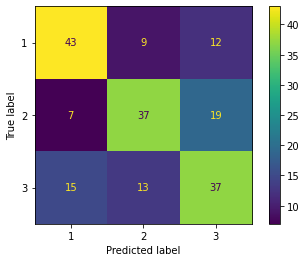

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


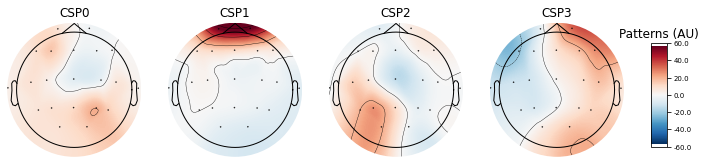




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.724


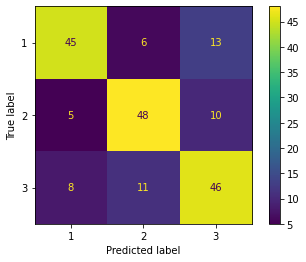

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


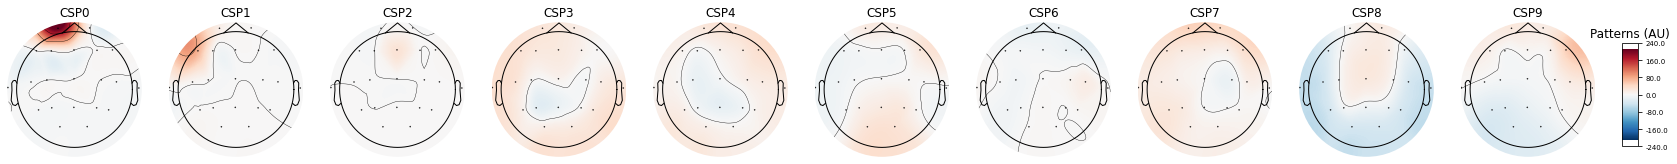




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.7277


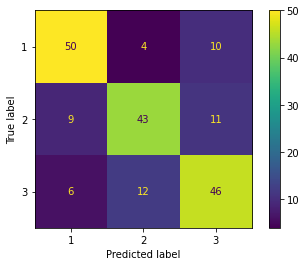

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


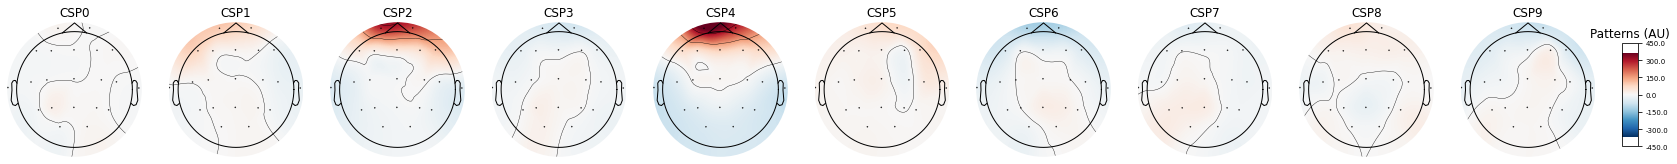

In [6]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del pipeline
del y_pred
del accuracy


<hr>

### Same subject, same session: SVM classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 4 | 6 | 10
         - For SVM:
            - The C: 0.01 | 0.1 | 1 | 10 | 100
            - The kernel: rbf | sigmoid | linear
            - When using the rbf of sigmoid kernel, the gamma: scale | auto | 10 | 1 | 0.1 | 0.01 | 0.001
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [7]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                h_freq= filter_upper_bound,
                                picks= "all",
                                phase= "minimum",
                                fir_window= "blackman",
                                fir_design= "firwin",
                                pad= 'median', 
                                n_jobs= -1,
                                verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                svm = SVC()
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limited computational resources
                param_grid = [{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['rbf', 'sigmoid'],
                        "SVM__gamma":['scale', 'auto', 10, 1, 0.1, 0.01, 0.001]}
                              ,{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['linear']}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del svm
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: test split accuracy** | **Config**                                                |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------------|
| B           | 0.6693 +- 0.02981                        | 0.6146                             | 4 CSP components \| SVM RBF with C 0.1 and Gamma auto     |
| C           | 0.7262 +- 0.0298                         | 0.7448                             | 6 CSP components \| SVM RBF with C 100 and Gamma 0.001    |
| E           | 0.7356 +- 0.0159                         | 0.7016                             | 6 CSP components \| SVM sigmoid with C 100 and Gamma 0.01 |

In [8]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_cspsvm_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {np.round(grid_search.best_score_, 4)} +- {np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4)} with the following parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.6693 +- 0.0298 with the following parameters
{'CSP__n_components': 4, 'SVM__C': 0.1, 'SVM__gamma': 'auto', 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
16        2.062838      0.029235         0.010996    4.878850e-07   
52        2.095329      0.047012         0.010246    8.289531e-04   
50        2.056091      0.033294         0.008747    4.331534e-04   
212       2.063338      0.040255         0.002749    4.330503e-04   
36        2.077584      0.031576         0.009497    4.999638e-04   
53        2.071336      0.031652         0.003748    4.328437e-04   
69        2.080583      0.027161         0.004249    4.327411e-04   
68        2.096828      0.064931         0.009498    8.665823e-04   
67        2.056341      0.028035         0.003748    4.323968e-04   
66        2.057090      0.030234         0.009748    1.298875e-03   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
16                        4          0.1             auto               rbf   
52                        4           10             0.01               rbf   
50                        4           10              0.1               rbf   
212                       4            1              NaN            linear   
36                        4            1              0.1               rbf   
53                        4           10             0.01           sigmoid   
69                        4          100            0.001           sigmoid   
68                        4          100            0.001               rbf   
67                        4          100             0.01           sigmoid   
66                        4          100             0.01               rbf   

     split0_test_score  split1_test_score  ...  split3_test_score  \
16            0.630208           0.713542  ...           0.661458   
52            0.635417           0.692708  ...           0.651042   
50            0.630208           0.682292  ...           0.677083   
212           0.625000           0.697917  ...           0.661458   
36            0.614583           0.687500  ...           0.666667   
53            0.630208           0.697917  ...           0.645833   
69            0.630208           0.697917  ...           0.645833   
68            0.630208           0.692708  ...           0.651042   
67            0.625000           0.692708  ...           0.661458   
66            0.625000           0.692708  ...           0.666667   

     mean_test_score  std_test_score  rank_test_score  split0_train_score  \
16          0.669271        0.029806                1            0.696181   
52          0.667969        0.025349                2            0.697917   
50          0.667969        0.021904                2            0.713542   
212         0.666667        0.027313                4            0.703125   
36          0.665365        0.030895                5            0.704861   
53          0.665365        0.028138                5            0.704861   
69          0.665365        0.028138                5            0.704861   
68          0.665365        0.025878                5            0.694444   
67          0.665365        0.025878                5            0.703125   
66          0.665365        0.025080                5            0.704861   

     split1_train_score  split2_train_score  split3_train_score  \
16             0.673611            0.677083            0.699653   
52             0.668403            0.689236            0.694444   
50             0.694444            0.689236            0.701389   
212            0.668403            0.682292            0.689236   
36             0.678819            0.682292            0.697917   
53             0.668403            0.678819            0.699653   
69             0.668403            0.678819            0.699653   
68             0.663194            0.680556            0.696181   
67             0.668403            0.684028            0.687500   
66             0.678819            0.668403            0.689236   

     mean_train_score  std_tr



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
89        2.061839      0.017805         0.007498    5.000853e-04   
33        2.057590      0.031457         0.005248    4.327061e-04   
47        2.070586      0.019985         0.005498    4.995478e-04   
61        2.058839      0.027923         0.005249    4.335321e-04   
74        2.081832      0.023893         0.012996    2.920019e-07   
88        2.069335      0.032868         0.013995    1.731340e-03   
19        2.069086      0.035467         0.006498    4.997254e-04   
172       2.081583      0.039720         0.015496    8.666903e-04   
144       2.066337      0.038231         0.015496    8.663757e-04   
158       2.077584      0.039322         0.014996    7.078143e-04   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
89                        6          0.1               10           sigmoid   
33                        4            1               10           sigmoid   
47                        4           10               10           sigmoid   
61                        4          100               10           sigmoid   
74                        6         0.01               10               rbf   
88                        6          0.1               10               rbf   
19                        4          0.1               10           sigmoid   
172                      10            1               10               rbf   
144                      10         0.01               10               rbf   
158                      10          0.1               10               rbf   

     split0_test_score  split1_test_score  ...  split3_test_score  \
89            0.380208           0.416667  ...           0.406250   
33            0.338542           0.520833  ...           0.338542   
47            0.364583           0.510417  ...           0.307292   
61            0.359375           0.510417  ...           0.302083   
74            0.453125           0.401042  ...           0.338542   
88            0.453125           0.401042  ...           0.338542   
19            0.359375           0.380208  ...           0.369792   
172           0.421875           0.390625  ...           0.333333   
144           0.333333           0.343750  ...           0.338542   
158           0.333333           0.343750  ...           0.338542   

     mean_test_score  std_test_score  rank_test_score  split0_train_score  \
89          0.404948        0.014903              216            0.442708   
33          0.399740        0.074424              217            0.394097   
47          0.398438        0.074435              218            0.397569   
61          0.393229        0.076236              219            0.397569   
74          0.381510        0.049187              220            0.663194   
88          0.381510        0.049187              220            0.663194   
19          0.380208        0.019488              222            0.385417   
172         0.376302        0.033222              223            1.000000   
144         0.337240        0.004319              224            0.673611   
158         0.337240        0.004319              224            0.673611   

     split1_train_score  split2_train_score  split3_train_score  \
89             0.390625            0.388889            0.369792   
33             0.442708            0.342014            0.322917   
47             0.444444            0.362847            0.314236   
61             0.446181            0.348958            0.324653   
74             0.664931            0.338542            0.336806   
88             0.664931            0.338542            0.336806   
19             0.388889            0.413194            0.342014   
172            1.000000            1.000000            1.000000   
144            0.673611            0.338542            0.336806   
158            0.673611            0.338542            0.336806   

     mean_train_score  std_tr



In total there are 225 different configurations tested.
The best mean test score is 0.6693
There are 1 configurations with this maximum score
There are 41 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       41.000000     41.000000        41.000000    4.100000e+01   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         2.066697      0.033610         0.007784    6.481829e-04   
std          0.012887      0.008334         0.003400    4.352666e-04   
min          2.049093      0.017749         0.002749    3.097148e-07   
25%          2.056590      0.028129         0.004250    4.328437e-04   
50%          2.062839      0.032509         0.008997    4.341517e-04   
75%          2.073335      0.038211         0.010497    8.289704e-04   
max          2.096828      0.064931         0.013246    1.920093e-03   

        param_CSP__n_components  param_SVM__C  param_SVM__gamma  \
count                      41.0          41.0             35.00   
unique                      2.0           5.0              6.00   
top                         4.0           0.1              0.01   
freq                       30.0          12.0              9.00   
mean                        NaN           NaN               NaN   
std                         NaN           NaN               NaN   
min                         NaN           NaN               NaN   
25%                         NaN           NaN               NaN   
50%                         NaN           NaN               NaN   
75%                         NaN           NaN               NaN   
max                         NaN           NaN               NaN   

       param_SVM__kernel  split0_test_score  split1_test_score  ...  \
count                 41          41.000000          41.000000  ...   
unique                 3                NaN                NaN  ...   
top                  rbf                NaN                NaN  ...   
freq                  23                NaN                NaN  ...   
mean                 NaN           0.616489           0.696519  ...   
std                  NaN           0.014720           0.013022  ...   
min                  NaN           0.588542           0.677083  ...   
25%                  NaN           0.604167           0.687500  ...   
50%                  NaN           0.619792           0.692708  ...   
75%                  NaN           0.630208           0.697917  ...   
max                  NaN           0.640625           0.729167  ...   

        split3_test_score  mean_test_score  std_test_score  rank_test_score  \
count           41.000000        41.000000       41.000000        41.000000   
unique                NaN              NaN             NaN              NaN   
top                   NaN              NaN             NaN              NaN   
freq                  NaN              NaN             NaN              NaN   
mean             0.657393         0.659966        0.030955        19.756098   
std              0.015341         0.005172        0.007044        12.287759   
min              0.630208         0.649740        0.017806         1.000000   
25%              0.645833         0.656250        0.025878         5.000000   
50%              0.656250         0.660156        0.029232        21.000000   
75%              0.671875         0.665365        0.036644        27.000000   
max              0.687500         0.669271        0.041991        40.000000   

        split0_train_score  split1_train_score  split2_train_score  \
count            41.000000           41.000000           41.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.709646            0.681741            0.684282   
std               0.013757            0.013606            0.014161   
min               0.673611            0.661458




####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.7262 +- 0.0298 with the following parameters
{'CSP__n_components': 6, 'SVM__C': 100, 'SVM__gamma': 0.001, 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
138       2.138314      0.064616         0.009747    4.325340e-04   
122       2.131567      0.064912         0.009497    4.990702e-04   
123       2.122069      0.059648         0.004749    4.328783e-04   
216       2.111574      0.054261         0.003998    5.196212e-07   
139       2.113572      0.055252         0.004498    4.998447e-04   
98        2.128318      0.054933         0.009747    4.328781e-04   
217       2.111574      0.063782         0.004248    8.283779e-04   
219       2.198046      0.064861         0.003749    4.330502e-04   
218       2.132316      0.058110         0.004499    8.661691e-04   
106       2.116072      0.060513         0.009747    4.333615e-04   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
138                       6          100            0.001               rbf   
122                       6           10             0.01               rbf   
123                       6           10             0.01           sigmoid   
216                       6          0.1              NaN            linear   
139                       6          100            0.001           sigmoid   
98                        6            1            scale               rbf   
217                       6            1              NaN            linear   
219                       6          100              NaN            linear   
218                       6           10              NaN            linear   
106                       6            1              0.1               rbf   

     split0_test_score  split1_test_score  ...  split3_test_score  \
138           0.755208           0.677083  ...           0.743455   
122           0.729167           0.677083  ...           0.748691   
123           0.760417           0.677083  ...           0.738220   
216           0.755208           0.671875  ...           0.743455   
139           0.755208           0.671875  ...           0.743455   
98            0.739583           0.677083  ...           0.743455   
217           0.760417           0.661458  ...           0.738220   
219           0.760417           0.656250  ...           0.738220   
218           0.765625           0.651042  ...           0.738220   
106           0.744792           0.677083  ...           0.743455   

     mean_test_score  std_test_score  rank_test_score  split0_train_score  \
138         0.726228        0.029835                1            0.760000   
122         0.721027        0.026593                2            0.760000   
123         0.721013        0.031382                3            0.756522   
216         0.719718        0.032564                4            0.754783   
139         0.719718        0.032564                4            0.753043   
98          0.717114        0.026825                6            0.765217   
217         0.717107        0.037065                7            0.758261   
219         0.717107        0.038852                8            0.761739   
218         0.717107        0.042359                8            0.763478   
106         0.715812        0.029258               10            0.772174   

     split1_train_score  split2_train_score  split3_train_score  \
138            0.725217            0.760000            0.756944   
122            0.732174            0.766957            0.756944   
123            0.716522            0.760000            0.758681   
216            0.718261            0.760000            0.758681   
139            0.718261            0.760000            0.758681   
98             0.739130            0.761739            0.751736   
217            0.725217            0.763478            0.753472   
219            0.723478            0.763478            0.750000   
218            0.725217            0.763478            0.750000   
106            0.735652            0.763478            0.755208   

     mean_train_score  std_tr



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
27        2.124819      0.061106         0.004998    4.256623e-07   
159       2.140564      0.064930         0.006498    5.003216e-04   
161       2.137314      0.051184         0.008997    7.068027e-04   
45        2.121568      0.065900         0.005248    4.331191e-04   
119       2.129568      0.057568         0.006748    4.330502e-04   
31        2.132565      0.057902         0.006498    4.998448e-04   
59        2.109323      0.052323         0.007248    2.277293e-03   
63        2.112073      0.054514         0.006248    1.089496e-03   
49        2.113823      0.061155         0.006248    4.327061e-04   
175       2.128068      0.052904         0.009247    8.287548e-04   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
27                        4          0.1            0.001           sigmoid   
159                      10          0.1               10           sigmoid   
161                      10          0.1                1           sigmoid   
45                        4           10             auto           sigmoid   
119                       6           10                1           sigmoid   
31                        4            1             auto           sigmoid   
59                        4          100             auto           sigmoid   
63                        4          100                1           sigmoid   
49                        4           10                1           sigmoid   
175                      10            1                1           sigmoid   

     split0_test_score  split1_test_score  ...  split3_test_score  \
27            0.338542           0.338542  ...           0.335079   
159           0.343750           0.338542  ...           0.329843   
161           0.343750           0.338542  ...           0.329843   
45            0.343750           0.328125  ...           0.298429   
119           0.307292           0.385417  ...           0.314136   
31            0.348958           0.317708  ...           0.335079   
59            0.322917           0.322917  ...           0.303665   
63            0.302083           0.369792  ...           0.319372   
49            0.276042           0.375000  ...           0.314136   
175           0.375000           0.270833  ...           0.308901   

     mean_test_score  std_test_score  rank_test_score  split0_train_score  \
27          0.337676        0.001500              167            0.337391   
159         0.337669        0.004994              217            0.339130   
161         0.337669        0.004994              217            0.339130   
45          0.337628        0.029485              219            0.326957   
119         0.333742        0.030765              220            0.335652   
31          0.332468        0.011352              221            0.349565   
59          0.331125        0.026523              222            0.326957   
63          0.328541        0.025087              223            0.321739   
49          0.315513        0.036898              224            0.304348   
175         0.303788        0.044901              225            0.360000   

     split1_train_score  split2_train_score  split3_train_score  \
27             0.337391            0.337391            0.338542   
159            0.358261            0.342609            0.342014   
161            0.354783            0.342609            0.343750   
45             0.354783            0.422609            0.338542   
119            0.403478            0.323478            0.322917   
31             0.361739            0.353043            0.312500   
59             0.354783            0.427826            0.335069   
63             0.373913            0.293913            0.315972   
49             0.379130            0.325217            0.312500   
175            0.269565            0.335652            0.343750   

     mean_train_score  std_tr



In total there are 225 different configurations tested.
The best mean test score is 0.7262
There are 1 configurations with this maximum score
There are 27 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       27.000000     27.000000        27.000000    2.700000e+01   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         2.138231      0.060986         0.008192    6.971704e-04   
std          0.037548      0.005814         0.003710    5.522133e-04   
min          2.111573      0.050226         0.003749    5.196212e-07   
25%          2.120570      0.055907         0.004624    4.328266e-04   
50%          2.128318      0.060513         0.008997    4.990702e-04   
75%          2.142813      0.065022         0.010372    8.289529e-04   
max          2.300512      0.074573         0.014995    3.081520e-03   

        param_CSP__n_components  param_SVM__C  param_SVM__gamma  \
count                      27.0          27.0             20.00   
unique                      2.0           5.0              5.00   
top                         6.0          10.0              0.01   
freq                       19.0           8.0              7.00   
mean                        NaN           NaN               NaN   
std                         NaN           NaN               NaN   
min                         NaN           NaN               NaN   
25%                         NaN           NaN               NaN   
50%                         NaN           NaN               NaN   
75%                         NaN           NaN               NaN   
max                         NaN           NaN               NaN   

       param_SVM__kernel  split0_test_score  split1_test_score  ...  \
count                 27          27.000000          27.000000  ...   
unique                 3                NaN                NaN  ...   
top                  rbf                NaN                NaN  ...   
freq                  14                NaN                NaN  ...   
mean                 NaN           0.747492           0.662230  ...   
std                  NaN           0.010651           0.011798  ...   
min                  NaN           0.729167           0.645833  ...   
25%                  NaN           0.739583           0.651042  ...   
50%                  NaN           0.744792           0.661458  ...   
75%                  NaN           0.755208           0.671875  ...   
max                  NaN           0.765625           0.677083  ...   

        split3_test_score  mean_test_score  std_test_score  rank_test_score  \
count           27.000000        27.000000       27.000000        27.000000   
unique                NaN              NaN             NaN              NaN   
top                   NaN              NaN             NaN              NaN   
freq                  NaN              NaN             NaN              NaN   
mean             0.723483         0.713375        0.033656        13.814815   
std              0.019538         0.005212        0.005763         7.942278   
min              0.685864         0.706622        0.024617         1.000000   
25%              0.706806         0.709281        0.029095         7.500000   
50%              0.727749         0.711865        0.032761        13.000000   
75%              0.740838         0.717107        0.037256        20.500000   
max              0.748691         0.726228        0.045044        26.000000   

        split0_train_score  split1_train_score  split2_train_score  \
count            27.000000           27.000000           27.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.761031            0.734364            0.759549   
std               0.014688            0.013968            0.013993   
min               0.735652            0.716522




####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.7356 +- 0.0159 with the following parameters
{'CSP__n_components': 10, 'SVM__C': 100, 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid'}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
222       2.182299      0.063694         0.004499    5.003215e-04   
207       2.176302      0.061567         0.005748    4.329472e-04   
206       2.173304      0.073917         0.009496    4.990103e-04   
208       2.188048      0.082224         0.010247    4.326374e-04   
184       2.167556      0.059497         0.010747    1.298565e-03   
190       2.162807      0.068671         0.009496    5.002022e-04   
223       2.179551      0.071981         0.005498    2.061071e-03   
192       2.186050      0.067975         0.010247    4.331198e-04   
176       2.160808      0.064378         0.010996    4.578320e-07   
170       2.183050      0.071905         0.010246    4.320182e-04   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
222                      10            1              NaN            linear   
207                      10          100             0.01           sigmoid   
206                      10          100             0.01               rbf   
208                      10          100            0.001               rbf   
184                      10           10             auto               rbf   
190                      10           10              0.1               rbf   
223                      10           10              NaN            linear   
192                      10           10             0.01               rbf   
176                      10            1              0.1               rbf   
170                      10            1             auto               rbf   

     split0_test_score  split1_test_score  ...  split3_test_score  \
222           0.717277           0.722513  ...           0.748691   
207           0.717277           0.722513  ...           0.748691   
206           0.717277           0.722513  ...           0.738220   
208           0.712042           0.722513  ...           0.743455   
184           0.712042           0.743455  ...           0.748691   
190           0.712042           0.743455  ...           0.748691   
223           0.717277           0.717277  ...           0.748691   
192           0.706806           0.712042  ...           0.748691   
176           0.712042           0.712042  ...           0.732984   
170           0.712042           0.712042  ...           0.732984   

     mean_test_score  std_test_score  rank_test_score  split0_train_score  \
222         0.735602        0.015923                1            0.790576   
207         0.735602        0.015923                1            0.788831   
206         0.734293        0.016296                3            0.795812   
208         0.732984        0.016556                4            0.787086   
184         0.731675        0.014981                5            0.832461   
190         0.731675        0.014981                5            0.832461   
223         0.729058        0.013023                7            0.787086   
192         0.729058        0.019721                7            0.788831   
176         0.726440        0.015432                9            0.792321   
170         0.726440        0.015432                9            0.792321   

     split1_train_score  split2_train_score  split3_train_score  \
222            0.766143            0.752182            0.776614   
207            0.766143            0.752182            0.776614   
206            0.809773            0.764398            0.802792   
208            0.767888            0.752182            0.785340   
184            0.837696            0.821990            0.839442   
190            0.837696            0.821990            0.839442   
223            0.773124            0.764398            0.780105   
192            0.778360            0.752182            0.787086   
176            0.801047            0.769634            0.804538   
170            0.801047            0.769634            0.804538   

     mean_train_score  std_tr



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
166       2.200044      0.073691         0.015495    1.658282e-03   
27        2.186049      0.064834         0.004749    4.334633e-04   
26        2.158558      0.056883         0.011997    8.678567e-07   
25        2.175301      0.066266         0.004749    4.322932e-04   
181       2.170304      0.075860         0.007247    4.333602e-04   
88        2.168554      0.078395         0.013996    7.070560e-04   
83        2.175051      0.071675         0.005748    4.330159e-04   
82        2.178302      0.086497         0.013496    1.499573e-03   
80        2.176553      0.064804         0.013745    1.918184e-03   
167       2.194796      0.063077         0.006998    7.074771e-04   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
166                      10          0.1            0.001               rbf   
27                        4          0.1            0.001           sigmoid   
26                        4          0.1            0.001               rbf   
25                        4          0.1             0.01           sigmoid   
181                      10            1            0.001           sigmoid   
88                        6          0.1               10               rbf   
83                        6         0.01            0.001           sigmoid   
82                        6         0.01            0.001               rbf   
80                        6         0.01             0.01               rbf   
167                      10          0.1            0.001           sigmoid   

     split0_test_score  split1_test_score  ...  split3_test_score  \
166           0.335079           0.335079  ...           0.340314   
27            0.335079           0.335079  ...           0.340314   
26            0.335079           0.335079  ...           0.340314   
25            0.335079           0.335079  ...           0.340314   
181           0.335079           0.335079  ...           0.340314   
88            0.335079           0.335079  ...           0.340314   
83            0.335079           0.335079  ...           0.340314   
82            0.335079           0.335079  ...           0.340314   
80            0.335079           0.335079  ...           0.340314   
167           0.335079           0.335079  ...           0.340314   

     mean_test_score  std_test_score  rank_test_score  split0_train_score  \
166         0.337696        0.002618              186            0.338569   
27          0.337696        0.002618              186            0.338569   
26          0.337696        0.002618              186            0.338569   
25          0.337696        0.002618              186            0.338569   
181         0.337696        0.002618              186            0.338569   
88          0.337696        0.002618              186            0.338569   
83          0.337696        0.002618              186            0.338569   
82          0.337696        0.002618              186            0.338569   
80          0.337696        0.002618              186            0.338569   
167         0.337696        0.002618              186            0.338569   

     split1_train_score  split2_train_score  split3_train_score  \
166            0.338569            0.336824            0.336824   
27             0.338569            0.336824            0.336824   
26             0.338569            0.336824            0.336824   
25             0.338569            0.336824            0.336824   
181            0.338569            0.336824            0.336824   
88             0.338569            0.336824            0.336824   
83             0.338569            0.336824            0.336824   
82             0.338569            0.336824            0.336824   
80             0.338569            0.336824            0.336824   
167            0.338569            0.336824            0.336824   

     mean_train_score  std_tr



In total there are 225 different configurations tested.
The best mean test score is 0.7356
There are 2 configurations with this maximum score
There are 17 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       17.000000     17.000000        17.000000    1.700000e+01   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         2.190754      0.069968         0.007718    5.423305e-04   
std          0.054922      0.007008         0.002579    4.957370e-04   
min          2.160808      0.059497         0.004499    3.908538e-07   
25%          2.167556      0.064378         0.005748    4.321227e-04   
50%          2.178052      0.068671         0.005998    4.329472e-04   
75%          2.186050      0.073917         0.010247    5.002022e-04   
max          2.398481      0.082224         0.010996    2.061071e-03   

        param_CSP__n_components  param_SVM__C  param_SVM__gamma  \
count                      17.0          17.0             13.00   
unique                      1.0           4.0              5.00   
top                        10.0           1.0              0.01   
freq                       17.0           6.0              4.00   
mean                        NaN           NaN               NaN   
std                         NaN           NaN               NaN   
min                         NaN           NaN               NaN   
25%                         NaN           NaN               NaN   
50%                         NaN           NaN               NaN   
75%                         NaN           NaN               NaN   
max                         NaN           NaN               NaN   

       param_SVM__kernel  split0_test_score  split1_test_score  ...  \
count                 17          17.000000          17.000000  ...   
unique                 3                NaN                NaN  ...   
top                  rbf                NaN                NaN  ...   
freq                   8                NaN                NaN  ...   
mean                 NaN           0.708038           0.716046  ...   
std                  NaN           0.009353           0.014637  ...   
min                  NaN           0.680628           0.696335  ...   
25%                  NaN           0.701571           0.701571  ...   
50%                  NaN           0.712042           0.712042  ...   
75%                  NaN           0.712042           0.722513  ...   
max                  NaN           0.717277           0.743455  ...   

        split3_test_score  mean_test_score  std_test_score  rank_test_score  \
count           17.000000        17.000000       17.000000        17.000000   
unique                NaN              NaN             NaN              NaN   
top                   NaN              NaN             NaN              NaN   
freq                  NaN              NaN             NaN              NaN   
mean             0.743148         0.727826        0.018031         8.470588   
std              0.006537         0.005770        0.004073         4.862068   
min              0.732984         0.715969        0.013023         1.000000   
25%              0.738220         0.725131        0.015432         5.000000   
50%              0.743455         0.726440        0.016296         9.000000   
75%              0.748691         0.731675        0.019721        13.000000   
max              0.748691         0.735602        0.027047        16.000000   

        split0_train_score  split1_train_score  split2_train_score  \
count            17.000000           17.000000           17.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.792218            0.783903            0.767580   
std               0.018402            0.030630            0.024821   
min               0.773124            0.748691




####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.6146


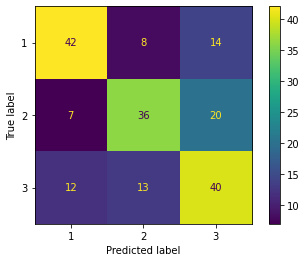

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


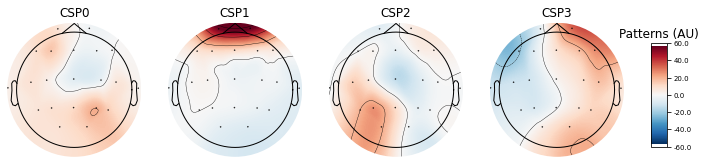




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.7448


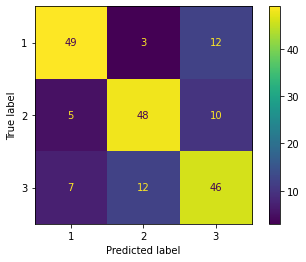

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


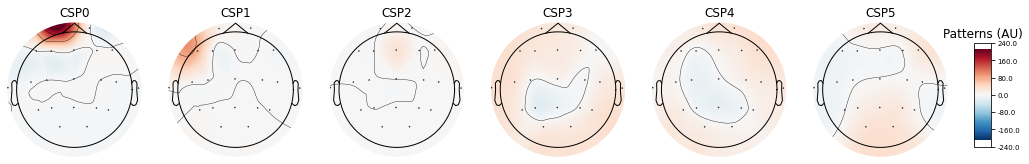




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.7016


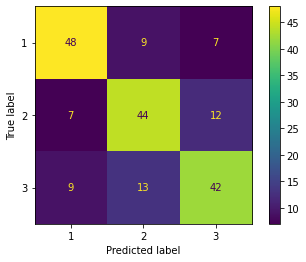

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


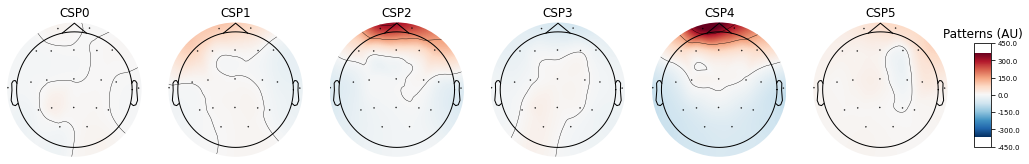

In [9]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 6 , 6]
best_found_svm_kernel = ["rbf", "rbf", "sigmoid"]
best_found_svm_c = [0.1, 100, 100]
best_found_svm_gamma = ["auto", 0.001, 0.01]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    svm = SVC(kernel= best_found_svm_kernel[i],
              C= best_found_svm_c[i],
              gamma= best_found_svm_gamma[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_svm_kernel
del best_found_svm_c
del best_found_svm_gamma
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del svm
del pipeline
del y_pred
del accuracy


<hr>

### Same subject, same session: RF classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For SVM:
            - The C: 0.01 | 0.1 | 1 | 10 | 100
            - The kernel: rbf | sigmoid | linear
            - When using the rbf of sigmoid kernel, the gamma: scale | auto | 10 | 1 | 0.1 | 0.01 | 0.001
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [10]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                rf = RandomForestClassifier(bootstrap= True,
                                            criterion= "gini")
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('RF', rf)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [4, 6, 10],
                               "RF__n_estimators": [10, 50, 100, 250, 500],
                               "RF__max_depth": [None, 3, 10],
                               "RF__min_samples_split": [2, 5, 10],
                               "RF__max_features": ["sqrt", "log2", "None", 0.2, 0.4, 0.6]}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del rf
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + RF: cross validation accuracy** | **CSP + RF: test split accuracy** | **Config**                                                                                   |
|-------------|------------------------------------------|------------------------------------|----------------------------------------------------------------------------------------------|
| B           | 0.6588 +- 0.0316                         | 0.6042                             | 4 CSP components \| RF max depth 10, max features 0.4, min sample split 10, 50 estimators    |
| C           | 0.7119 +- 0.0316                         | 0.7031                             | 6 CSP components \| RF max depth 3, max features 0.4, min sample split 5, 250 estimators     |
| E           | 0.7251 +- 0.0176                         | 0.7539                             | 10 CSP components \| RF max depth None, max features 0.2, min sample split 2, 250 estimators |

In [11]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csprf_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {np.round(grid_search.best_score_, 4)} +- {np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4)} with the following parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.6589 +- 0.03 with the following parameters
{'CSP__n_components': 4, 'RF__max_depth': 10, 'RF__max_features': 0.4, 'RF__min_samples_split': 10, 'RF__n_estimators': 50}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
254       2.654652      0.033919         0.053983        0.000707   
251       2.073587      0.018533         0.007248        0.000433   
164       2.576927      0.033308         0.047735        0.000433   
371       2.060092      0.028208         0.007248        0.000433   
237       2.134069      0.034848         0.012996        0.000707   
74        2.688141      0.042636         0.057982        0.004182   
235       2.036850      0.035629         0.003249        0.000433   
246       2.056843      0.037287         0.007748        0.000433   
238       2.334503      0.025216         0.027991        0.000707   
58        2.335754      0.022592         0.028241        0.000433   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
254                       4                  10                    0.4   
251                       4                  10                    0.4   
164                       4                   3                    0.4   
371                       6                   3                   sqrt   
237                       4                  10                    0.2   
74                        4                None                    0.4   
235                       4                  10                    0.2   
246                       4                  10                    0.4   
238                       4                  10                    0.2   
58                        4                None                    0.2   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
254                          10                    500           0.604167   
251                          10                     50           0.609375   
164                          10                    500           0.609375   
371                          10                     50           0.614583   
237                          10                    100           0.609375   
74                           10                    500           0.609375   
235                          10                     10           0.645833   
246                           5                     50           0.614583   
238                          10                    250           0.609375   
58                           10                    250           0.604167   

     ...  split3_test_score  mean_test_score  std_test_score  rank_test_score  \
254  ...           0.677083         0.658854        0.031574                1   
251  ...           0.661458         0.658854        0.030033                1   
164  ...           0.677083         0.657552        0.028852                3   
371  ...           0.661458         0.656250        0.025248                4   
237  ...           0.677083         0.654948        0.026906                5   
74   ...           0.677083         0.653646        0.026685                6   
235  ...           0.651042         0.653646        0.010737                6   
246  ...           0.661458         0.653646        0.023438                6   
238  ...           0.671875         0.653646        0.025911                6   
58   ...           0.671875         0.652344        0.028852               10   

     split0_train_score  split1_train_score  split2_train_score  \
254            0.862847            0.880208            0.838542   
251            0.873264            0.869792            0.840278   
164            0.718750            0.703125            0.701389   
371            0.720486            0.710069            0.723958   
237            0.868056            0.868056            0.847222   
74             0.892361            0.902778            0.890625   
235            0.833333            0.857639            0.833333   
246            0.921875            0.918403            0.906250   
238            0.857639            0.875000            0.847222   
58             0.888



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
305       1.995363      0.034867              0.0             0.0   
482       2.036600      0.026072              0.0             0.0   
480       2.010108      0.026329              0.0             0.0   
403       2.078086      0.025035              0.0             0.0   
402       2.044847      0.025236              0.0             0.0   
401       2.024104      0.045518              0.0             0.0   
400       1.992863      0.024867              0.0             0.0   
399       2.153062      0.035509              0.0             0.0   
481       2.021355      0.038204              0.0             0.0   
404       2.149314      0.023689              0.0             0.0   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
305                       6                None                   None   
482                       6                  10                   None   
480                       6                  10                   None   
403                       6                   3                   None   
402                       6                   3                   None   
401                       6                   3                   None   
400                       6                   3                   None   
399                       6                   3                   None   
481                       6                  10                   None   
404                       6                   3                   None   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
305                           5                     10                NaN   
482                           2                    100                NaN   
480                           2                     10                NaN   
403                          10                    250                NaN   
402                          10                    100                NaN   
401                          10                     50                NaN   
400                          10                     10                NaN   
399                           5                    500                NaN   
481                           2                     50                NaN   
404                          10                    500                NaN   

     ...  split3_test_score  mean_test_score  std_test_score  rank_test_score  \
305  ...                NaN              NaN             NaN              801   
482  ...                NaN              NaN             NaN              802   
480  ...                NaN              NaN             NaN              803   
403  ...                NaN              NaN             NaN              804   
402  ...                NaN              NaN             NaN              805   
401  ...                NaN              NaN             NaN              806   
400  ...                NaN              NaN             NaN              807   
399  ...                NaN              NaN             NaN              808   
481  ...                NaN              NaN             NaN              809   
404  ...                NaN              NaN             NaN              810   

     split0_train_score  split1_train_score  split2_train_score  \
305                 NaN                 NaN                 NaN   
482                 NaN                 NaN                 NaN   
480                 NaN                 NaN                 NaN   
403                 NaN                 NaN                 NaN   
402                 NaN                 NaN                 NaN   
401                 NaN                 NaN                 NaN   
400                 NaN                 NaN                 NaN   
399                 NaN                 NaN                 NaN   
481                 NaN                 NaN                 NaN   
404                 



In total there are 810 different configurations tested.
The best mean test score is 0.6589
There are 2 configurations with this maximum score
There are 199 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count      199.000000    199.000000       199.000000      199.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         2.333009      0.032239         0.026223        0.001333   
std          0.255482      0.014742         0.018601        0.001820   
min          1.997112      0.011019         0.002749        0.000000   
25%          2.120322      0.025338         0.011247        0.000433   
50%          2.304763      0.031033         0.025242        0.000707   
75%          2.595921      0.036361         0.048860        0.001446   
max          2.885578      0.202313         0.061980        0.012632   

        param_CSP__n_components  param_RF__max_depth  param_RF__max_features  \
count                     199.0                167.0                   199.0   
unique                      3.0                  2.0                     5.0   
top                         4.0                  3.0                     0.2   
freq                       93.0                110.0                    55.0   
mean                        NaN                  NaN                     NaN   
std                         NaN                  NaN                     NaN   
min                         NaN                  NaN                     NaN   
25%                         NaN                  NaN                     NaN   
50%                         NaN                  NaN                     NaN   
75%                         NaN                  NaN                     NaN   
max                         NaN                  NaN                     NaN   

        param_RF__min_samples_split  param_RF__n_estimators  \
count                         199.0                   199.0   
unique                          3.0                     5.0   
top                            10.0                   500.0   
freq                           82.0                    55.0   
mean                            NaN                     NaN   
std                             NaN                     NaN   
min                             NaN                     NaN   
25%                             NaN                     NaN   
50%                             NaN                     NaN   
75%                             NaN                     NaN   
max                             NaN                     NaN   

        split0_test_score  ...  split3_test_score  mean_test_score  \
count          199.000000  ...         199.000000       199.000000   
unique                NaN  ...                NaN              NaN   
top                   NaN  ...                NaN              NaN   
freq                  NaN  ...                NaN              NaN   
mean             0.596289  ...           0.667530         0.644047   
std              0.017572  ...           0.012116         0.004217   
min              0.557292  ...           0.640625         0.639323   
25%              0.583333  ...           0.661458         0.640625   
50%              0.598958  ...           0.666667         0.643229   
75%              0.609375  ...           0.677083         0.645833   
max              0.645833  ...           0.697917         0.658854   

        std_test_score  rank_test_score  split0_train_score  \
count       199.000000       199.000000          199.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean          0.031271        93.678392            0.812177   
std           0.008114        55.111064            0.115280   
min           0.010737         1.000000            0.685764   
25%           0.026236        48.000000            0.710069   
50%           0.0




####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.7119 +- 0.0316 with the following parameters
{'CSP__n_components': 6, 'RF__max_depth': 3, 'RF__max_features': 0.4, 'RF__min_samples_split': 5, 'RF__n_estimators': 250}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
428       2.420227      0.044869         0.026242        0.001089   
705       2.091582      0.046924         0.003999        0.000707   
324       2.754620      0.045933         0.055482        0.000500   
598       2.442470      0.063389         0.029990        0.000707   
462       2.228788      0.056817         0.014245        0.001298   
723       2.491953      0.055635         0.030490        0.001118   
479       2.836594      0.049972         0.054733        0.001299   
298       2.451467      0.054164         0.030240        0.002585   
733       2.511947      0.051569         0.029991        0.000707   
432       2.186051      0.051005         0.011747        0.000829   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
428                       6                   3                    0.4   
705                      10                   3                    0.6   
324                       6                None                    0.2   
598                      10                None                    0.2   
462                       6                  10                   sqrt   
723                      10                  10                   sqrt   
479                       6                  10                   log2   
298                       6                None                   log2   
733                      10                  10                   sqrt   
432                       6                   3                    0.4   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
428                           5                    250           0.739583   
705                           2                     10           0.760417   
324                           5                    500           0.750000   
598                          10                    250           0.739583   
462                          10                    100           0.760417   
723                           2                    250           0.744792   
479                          10                    500           0.739583   
298                          10                    250           0.744792   
733                          10                    250           0.739583   
432                          10                    100           0.744792   

     ...  split3_test_score  mean_test_score  std_test_score  rank_test_score  \
428  ...           0.743455         0.711906        0.031637                1   
705  ...           0.732984         0.711892        0.037786                2   
324  ...           0.732984         0.711892        0.035376                2   
598  ...           0.717277         0.711871        0.036281                4   
462  ...           0.717277         0.710569        0.032339                5   
723  ...           0.712042         0.710563        0.033428                6   
479  ...           0.738220         0.709295        0.032295                7   
298  ...           0.722513         0.709274        0.028679                8   
733  ...           0.712042         0.709260        0.035169                9   
432  ...           0.743455         0.707999        0.036315               10   

     split0_train_score  split1_train_score  split2_train_score  \
428            0.766957            0.746087            0.782609   
705            0.780870            0.730435            0.784348   
324            0.994783            0.986087            0.987826   
598            0.958261            0.965217            0.944348   
462            0.904348            0.909565            0.886957   
723            1.000000            1.000000            1.000000   
479            0.914783            0.913043            0.886957   
298            0.918261            0.926957            0.897391   
733            0.953043            0.951304            0.930435   
432            0.779



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
673       2.136317      0.049244              0.0             0.0   
482       2.109576      0.068961              0.0             0.0   
480       2.072587      0.051152              0.0             0.0   
403       2.174305      0.048053              0.0             0.0   
402       2.094081      0.053492              0.0             0.0   
401       2.092332      0.057013              0.0             0.0   
400       2.073837      0.052130              0.0             0.0   
399       2.217541      0.066166              0.0             0.0   
481       2.069839      0.068613              0.0             0.0   
404       2.211793      0.043371              0.0             0.0   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
673                      10                   3                   None   
482                       6                  10                   None   
480                       6                  10                   None   
403                       6                   3                   None   
402                       6                   3                   None   
401                       6                   3                   None   
400                       6                   3                   None   
399                       6                   3                   None   
481                       6                  10                   None   
404                       6                   3                   None   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
673                          10                    250                NaN   
482                           2                    100                NaN   
480                           2                     10                NaN   
403                          10                    250                NaN   
402                          10                    100                NaN   
401                          10                     50                NaN   
400                          10                     10                NaN   
399                           5                    500                NaN   
481                           2                     50                NaN   
404                          10                    500                NaN   

     ...  split3_test_score  mean_test_score  std_test_score  rank_test_score  \
673  ...                NaN              NaN             NaN              801   
482  ...                NaN              NaN             NaN              802   
480  ...                NaN              NaN             NaN              803   
403  ...                NaN              NaN             NaN              804   
402  ...                NaN              NaN             NaN              805   
401  ...                NaN              NaN             NaN              806   
400  ...                NaN              NaN             NaN              807   
399  ...                NaN              NaN             NaN              808   
481  ...                NaN              NaN             NaN              809   
404  ...                NaN              NaN             NaN              810   

     split0_train_score  split1_train_score  split2_train_score  \
673                 NaN                 NaN                 NaN   
482                 NaN                 NaN                 NaN   
480                 NaN                 NaN                 NaN   
403                 NaN                 NaN                 NaN   
402                 NaN                 NaN                 NaN   
401                 NaN                 NaN                 NaN   
400                 NaN                 NaN                 NaN   
399                 NaN                 NaN                 NaN   
481                 NaN                 NaN                 NaN   
404                 



In total there are 810 different configurations tested.
The best mean test score is 0.7119
There are 1 configurations with this maximum score
There are 288 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count      288.000000    288.000000       288.000000    2.880000e+02   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         2.427031      0.053353         0.026555    1.405714e-03   
std          0.285123      0.007998         0.018788    1.499261e-03   
min          2.073588      0.024745         0.003249    1.032383e-07   
25%          2.182178      0.048045         0.009247    5.000681e-04   
50%          2.373992      0.053122         0.025367    8.473666e-04   
75%          2.699762      0.058801         0.048984    1.643769e-03   
max          3.210224      0.074814         0.065480    1.386146e-02   

        param_CSP__n_components  param_RF__max_depth param_RF__max_features  \
count                     288.0                200.0                    288   
unique                      2.0                  2.0                      5   
top                        10.0                  3.0                   log2   
freq                      153.0                106.0                     66   
mean                        NaN                  NaN                    NaN   
std                         NaN                  NaN                    NaN   
min                         NaN                  NaN                    NaN   
25%                         NaN                  NaN                    NaN   
50%                         NaN                  NaN                    NaN   
75%                         NaN                  NaN                    NaN   
max                         NaN                  NaN                    NaN   

        param_RF__min_samples_split  param_RF__n_estimators  \
count                         288.0                   288.0   
unique                          3.0                     5.0   
top                            10.0                   500.0   
freq                          115.0                    77.0   
mean                            NaN                     NaN   
std                             NaN                     NaN   
min                             NaN                     NaN   
25%                             NaN                     NaN   
50%                             NaN                     NaN   
75%                             NaN                     NaN   
max                             NaN                     NaN   

        split0_test_score  ...  split3_test_score  mean_test_score  \
count          288.000000  ...         288.000000       288.000000   
unique                NaN  ...                NaN              NaN   
top                   NaN  ...                NaN              NaN   
freq                  NaN  ...                NaN              NaN   
mean             0.731210  ...           0.716514         0.698868   
std              0.014024  ...           0.016005         0.004607   
min              0.677083  ...           0.670157         0.692299   
25%              0.723958  ...           0.701571         0.694949   
50%              0.734375  ...           0.717277         0.698834   
75%              0.739583  ...           0.729058         0.701477   
max              0.765625  ...           0.759162         0.711906   

        std_test_score  rank_test_score  split0_train_score  \
count       288.000000       288.000000          288.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean          0.034036       143.774306            0.896455   
std           0.006704        83.130650            0.096171   
min           0.011070         1.000000            0.739130   
25%           0.030145        72.250000            0.780870   
50%           0.033805       




####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.7251 +- 0.0176 with the following parameters
{'CSP__n_components': 10, 'RF__max_depth': None, 'RF__max_features': 0.2, 'RF__min_samples_split': 2, 'RF__n_estimators': 250}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
588       2.500701      0.053585         0.029991        0.000707   
594       2.907321      0.054588         0.056482        0.001118   
557       2.284521      0.057858         0.014495        0.000500   
772       2.275023      0.057715         0.014495        0.000866   
742       2.300265      0.060919         0.013496        0.000500   
549       2.990045      0.063808         0.060981        0.007033   
777       2.315011      0.051216         0.014495        0.000866   
587       2.265276      0.052534         0.015495        0.001118   
776       2.204795      0.062592         0.008497        0.000500   
743       2.543687      0.036337         0.029741        0.000433   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
588                      10                None                    0.2   
594                      10                None                    0.2   
557                      10                None                   log2   
772                      10                  10                    0.2   
742                      10                  10                   log2   
549                      10                None                   sqrt   
777                      10                  10                    0.2   
587                      10                None                    0.2   
776                      10                  10                    0.2   
743                      10                  10                   log2   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
588                           2                    250           0.696335   
594                           5                    500           0.706806   
557                           2                    100           0.685864   
772                           5                    100           0.696335   
742                           5                    100           0.691099   
549                           5                    500           0.691099   
777                          10                    100           0.696335   
587                           2                    100           0.675393   
776                          10                     50           0.685864   
743                           5                    250           0.701571   

     ...  split3_test_score  mean_test_score  std_test_score  rank_test_score  \
588  ...           0.727749         0.725131        0.017561                1   
594  ...           0.738220         0.723822        0.012486                2   
557  ...           0.748691         0.718586        0.022328                3   
772  ...           0.717277         0.717277        0.019590                4   
742  ...           0.712042         0.715969        0.016296                5   
549  ...           0.712042         0.715969        0.023231                5   
777  ...           0.727749         0.715969        0.011925                5   
587  ...           0.738220         0.715969        0.027299                5   
776  ...           0.743455         0.715969        0.021706                5   
743  ...           0.743455         0.714660        0.024972               10   

     split0_train_score  split1_train_score  split2_train_score  \
588            1.000000            1.000000            1.000000   
594            0.998255            1.000000            1.000000   
557            1.000000            1.000000            1.000000   
772            0.991274            0.998255            0.989529   
742            0.994764            0.993019            0.993019   
549            0.998255            0.998255            1.000000   
777            0.959860            0.956370            0.949389   
587            1.000000            1.000000            1.000000   
776            0.947644            0.945899            0.951134   
743            0.991



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
489       2.259528      0.060900              0.0             0.0   
481       2.116824      0.042179              0.0             0.0   
403       2.197548      0.072033              0.0             0.0   
402       2.147314      0.059015              0.0             0.0   
401       2.122823      0.059150              0.0             0.0   
400       2.103827      0.058639              0.0             0.0   
399       2.253530      0.046500              0.0             0.0   
398       2.184302      0.059028              0.0             0.0   
480       2.097080      0.051575              0.0             0.0   
404       2.272524      0.062099              0.0             0.0   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
489                       6                  10                   None   
481                       6                  10                   None   
403                       6                   3                   None   
402                       6                   3                   None   
401                       6                   3                   None   
400                       6                   3                   None   
399                       6                   3                   None   
398                       6                   3                   None   
480                       6                  10                   None   
404                       6                   3                   None   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
489                           5                    500                NaN   
481                           2                     50                NaN   
403                          10                    250                NaN   
402                          10                    100                NaN   
401                          10                     50                NaN   
400                          10                     10                NaN   
399                           5                    500                NaN   
398                           5                    250                NaN   
480                           2                     10                NaN   
404                          10                    500                NaN   

     ...  split3_test_score  mean_test_score  std_test_score  rank_test_score  \
489  ...                NaN              NaN             NaN              801   
481  ...                NaN              NaN             NaN              802   
403  ...                NaN              NaN             NaN              803   
402  ...                NaN              NaN             NaN              804   
401  ...                NaN              NaN             NaN              805   
400  ...                NaN              NaN             NaN              806   
399  ...                NaN              NaN             NaN              807   
398  ...                NaN              NaN             NaN              808   
480  ...                NaN              NaN             NaN              809   
404  ...                NaN              NaN             NaN              810   

     split0_train_score  split1_train_score  split2_train_score  \
489                 NaN                 NaN                 NaN   
481                 NaN                 NaN                 NaN   
403                 NaN                 NaN                 NaN   
402                 NaN                 NaN                 NaN   
401                 NaN                 NaN                 NaN   
400                 NaN                 NaN                 NaN   
399                 NaN                 NaN                 NaN   
398                 NaN                 NaN                 NaN   
480                 NaN                 NaN                 NaN   
404                 



In total there are 810 different configurations tested.
The best mean test score is 0.7251
There are 1 configurations with this maximum score
There are 61 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       61.000000     61.000000        61.000000    6.100000e+01   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         2.599846      0.058300         0.032809    1.156652e-03   
std          0.337803      0.012892         0.019007    1.223278e-03   
min          2.178803      0.032044         0.008497    1.032383e-07   
25%          2.286519      0.051035         0.014495    4.996658e-04   
50%          2.537939      0.057715         0.029991    8.289706e-04   
75%          2.926564      0.063010         0.055733    1.298726e-03   
max          3.325688      0.111701         0.060981    7.033335e-03   

        param_CSP__n_components  param_RF__max_depth  param_RF__max_features  \
count                      61.0                 33.0                    61.0   
unique                      1.0                  2.0                     5.0   
top                        10.0                 10.0                     0.2   
freq                       61.0                 32.0                    23.0   
mean                        NaN                  NaN                     NaN   
std                         NaN                  NaN                     NaN   
min                         NaN                  NaN                     NaN   
25%                         NaN                  NaN                     NaN   
50%                         NaN                  NaN                     NaN   
75%                         NaN                  NaN                     NaN   
max                         NaN                  NaN                     NaN   

        param_RF__min_samples_split  param_RF__n_estimators  \
count                          61.0                    61.0   
unique                          3.0                     4.0   
top                             5.0                   500.0   
freq                           21.0                    21.0   
mean                            NaN                     NaN   
std                             NaN                     NaN   
min                             NaN                     NaN   
25%                             NaN                     NaN   
50%                             NaN                     NaN   
75%                             NaN                     NaN   
max                             NaN                     NaN   

        split0_test_score  ...  split3_test_score  mean_test_score  \
count           61.000000  ...          61.000000        61.000000   
unique                NaN  ...                NaN              NaN   
top                   NaN  ...                NaN              NaN   
freq                  NaN  ...                NaN              NaN   
mean             0.688868  ...           0.721483         0.710819   
std              0.010227  ...           0.012675         0.004294   
min              0.664921  ...           0.691099         0.705497   
25%              0.680628  ...           0.712042         0.708115   
50%              0.691099  ...           0.722513         0.710733   
75%              0.696335  ...           0.727749         0.713351   
max              0.706806  ...           0.748691         0.725131   

        std_test_score  rank_test_score  split0_train_score  \
count        61.000000        61.000000           61.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean          0.018027        29.245902            0.984064   
std           0.005382        17.376858            0.027420   
min           0.007744         1.000000            0.806283   
25%           0.013539        15.000000            0.970332   
50%           0.0




####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.5938


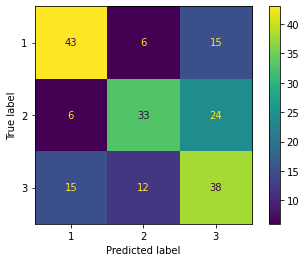

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


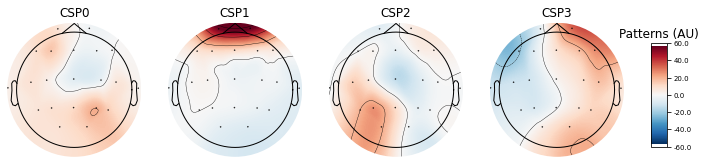




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.7083


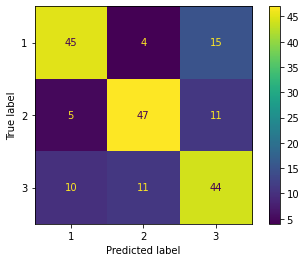

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


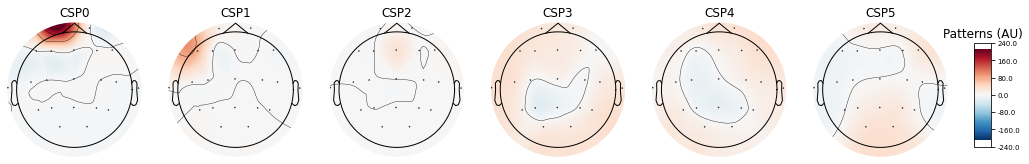




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.733


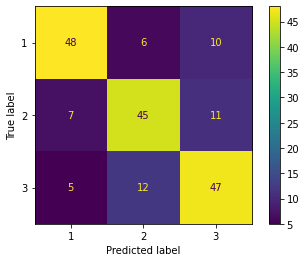

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


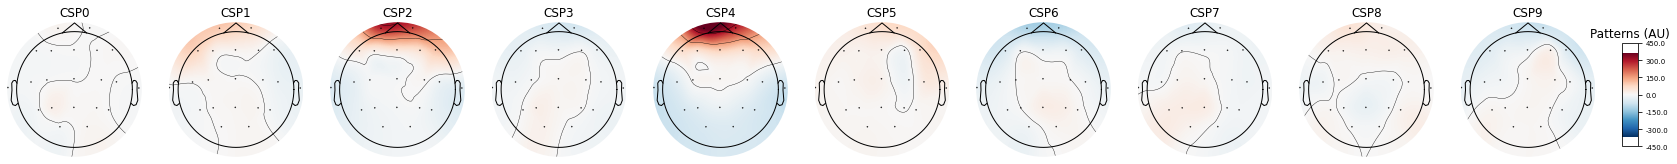

In [12]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 6 , 10]
best_found_rf_depth = [10, 3, None]
best_found_rf_max_featues = [0.4, 0.4, 0.2]
best_found_rf_min_sample = [10, 5, 2]
best_found_rf_n_estimators = [50, 250, 250]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    rf = RandomForestClassifier(bootstrap= True,
                                criterion= "gini",
                                max_depth= best_found_rf_depth[i],
                                max_features= best_found_rf_max_featues[i],
                                min_samples_split= best_found_rf_min_sample[i],
                                n_estimators= best_found_rf_n_estimators[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('RF', rf)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_rf_depth
del best_found_rf_max_featues
del best_found_rf_min_sample
del best_found_rf_n_estimators
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del rf
del pipeline
del y_pred
del accuracy


<hr><hr>

## Same subject, new session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.



<hr>

### Same subject, new session: LDA classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> LDA
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [13]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get all training data (all but last session of participant)
                mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                
                # Combine training data into singular mne raw
                mne_raw = mne.concatenate_raws(mne_raws)
                
                # Delete all raws since concat changes them
                del mne_raws
                
                # Get epochs for all those MNE raws (all training sessions)
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 6,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001, 0.00001, 0.001, 0.0004, 0.00007]
                               },
                              {"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["lsqr" , "eigen"]
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csplda.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del lda
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                   |
|-------------|------------------------------------------|------------------------------------|----------------------------------------------|
| B           | 0.4500 +- 0.02576                        | 0.4677                             | CSP 10 components \| SVD LDA with 0.0001 tol |
| C           | 0.8177 +- 0.01940                        | 0.3587                             | CSP 10 components \| SVD LDA with 0.0001 tol |
| E           | 0.5525 +- 0.03678                        | 0.5518                             | CSP 10 components \| SVD LDA with 0.0001 tol |

In [14]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csplda.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {np.round(grid_search.best_score_, 4)} +- {np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4)} with the following parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.45 +- 0.0258 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
34       5.325965      0.107249         0.004832        0.000373   
24       5.413773      0.036873         0.004332        0.000471   
23       5.456924      0.048601         0.004832        0.000373   
22       5.481582      0.074412         0.005499        0.000764   
21       5.435931      0.068638         0.004832        0.000687   
20       5.407107      0.060543         0.004499        0.000500   
33       5.501247      0.045590         0.004832        0.000373   
32       5.401942      0.043255         0.003166        0.000373   
31       5.401275      0.045625         0.003333        0.000472   
19       5.377282      0.043226         0.003499        0.000500   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
34                      10             eigen            NaN   
24                      10               svd        0.00007   
23                      10               svd         0.0004   
22                      10               svd          0.001   
21                      10               svd        0.00001   
20                      10               svd         0.0001   
33                      10              lsqr            NaN   
32                       6             eigen            NaN   
31                       6              lsqr            NaN   
19                       6               svd        0.00007   

    split0_test_score  split1_test_score  split2_test_score  ...  \
34             0.4625           0.459375           0.434375  ...   
24             0.4625           0.459375           0.434375  ...   
23             0.4625           0.459375           0.434375  ...   
22             0.4625           0.459375           0.434375  ...   
21             0.4625           0.459375           0.434375  ...   
20             0.4625           0.459375           0.434375  ...   
33             0.4625           0.459375           0.434375  ...   
32             0.4500           0.403125           0.406250  ...   
31             0.4500           0.403125           0.406250  ...   
19             0.4500           0.403125           0.403125  ...   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
34        0.025761                1            0.518148            0.508761   
24        0.025761                1            0.518148            0.508135   
23        0.025761                1            0.518148            0.508135   
22        0.025761                1            0.518148            0.508135   
21        0.025761                1            0.518148            0.508135   
20        0.025761                1            0.518148            0.508135   
33        0.025761                1            0.518148            0.508761   
32        0.019975                8            0.482478            0.487484   
31        0.019975                8            0.482478            0.487484   
19        0.020556               10            0.481852            0.487484   

    split2_train_score  split3_train_score  split4_train_score  \
34            0.501252            0.515019            0.484053   
24            0.503129            0.515019            0.484053   
23            0.503129            0.515019            0.484053   
22            0.503129            0.515019            0.484053   
21            0.503129            0.515019            0.484053   
20            0.503129            0.515019            0.484053   
33            0.501252            0.515019            0.484053   
32            0.447434            0.482478            0.464665   
31            0.447434            0.482478            0.464665   
19            0.447434            0.481852            0.464665   

    split5_train_score  mean_train_score  std_train_score  
34            0.494059          0.503548         0.011883  
24            0.494059          0.503757         0.011803  
23            0.494059          0.5



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
12       5.369285      0.046170         0.003332        0.000471   
29       5.413272      0.059934         0.003332        0.000471   
30       5.397610      0.065022         0.003332        0.000471   
25       5.402943      0.036143         0.002499        0.000500   
26       5.390612      0.048714         0.002499        0.000500   
1        5.622225      0.041098         0.002331        0.000470   
3        5.546569      0.043613         0.002166        0.000373   
4        5.536681      0.070654         0.002166        0.000372   
2        5.489227      0.057258         0.002333        0.000471   
0        5.790951      0.083763         0.002333        0.000471   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
12                       4               svd          0.001   
29                       4              lsqr            NaN   
30                       4             eigen            NaN   
25                       2              lsqr            NaN   
26                       2             eigen            NaN   
1                        2               svd        0.00001   
3                        2               svd         0.0004   
4                        2               svd        0.00007   
2                        2               svd          0.001   
0                        2               svd         0.0001   

    split0_test_score  split1_test_score  split2_test_score  ...  \
12           0.428125            0.44375           0.365625  ...   
29           0.428125            0.44375           0.365625  ...   
30           0.428125            0.44375           0.365625  ...   
25           0.390625            0.45625           0.396875  ...   
26           0.390625            0.45625           0.396875  ...   
1            0.390625            0.45625           0.396875  ...   
3            0.390625            0.45625           0.396875  ...   
4            0.390625            0.45625           0.396875  ...   
2            0.390625            0.45625           0.396875  ...   
0            0.390625            0.45625           0.396875  ...   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
12        0.033162               22            0.426783            0.449937   
29        0.033162               22            0.426783            0.449937   
30        0.033162               22            0.426783            0.449937   
25        0.044478               29            0.429912            0.439925   
26        0.044478               29            0.429912            0.439925   
1         0.044021               31            0.429912            0.439925   
3         0.044021               31            0.429912            0.439925   
4         0.044021               31            0.429912            0.439925   
2         0.044021               31            0.429912            0.439925   
0         0.044021               31            0.429912            0.439925   

    split2_train_score  split3_train_score  split4_train_score  \
12            0.419274            0.427409            0.434647   
29            0.418648            0.428035            0.434647   
30            0.418648            0.428035            0.434647   
25            0.386108            0.373592            0.419012   
26            0.386108            0.373592            0.419012   
1             0.386108            0.373592            0.419637   
3             0.386108            0.373592            0.419637   
4             0.386108            0.373592            0.419637   
2             0.386108            0.373592            0.419637   
0             0.386108            0.373592            0.419637   

    split5_train_score  mean_train_score  std_train_score  
12            0.437148          0.432533         0.009694  
29            0.437148          0.432533         0.009787  
30            0.437148          0.4



In total there are 35 different configurations tested.
The best mean test score is 0.45
There are 7 configurations with this maximum score
There are 7 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count        7.000000      7.000000         7.000000        7.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         5.431790      0.063129         0.004808        0.000506   
std          0.057858      0.023519         0.000365        0.000160   
min          5.325965      0.036873         0.004332        0.000373   
25%          5.410440      0.047096         0.004665        0.000373   
50%          5.435931      0.060543         0.004832        0.000471   
75%          5.469253      0.071525         0.004832        0.000593   
max          5.501247      0.107249         0.005499        0.000764   

        param_CSP__n_components param_LDA__solver  param_LDA__tol  \
count                       7.0                 7         5.00000   
unique                      1.0                 3         5.00000   
top                        10.0               svd         0.00007   
freq                        7.0                 5         1.00000   
mean                        NaN               NaN             NaN   
std                         NaN               NaN             NaN   
min                         NaN               NaN             NaN   
25%                         NaN               NaN             NaN   
50%                         NaN               NaN             NaN   
75%                         NaN               NaN             NaN   
max                         NaN               NaN             NaN   

        split0_test_score  split1_test_score  split2_test_score  ...  \
count        7.000000e+00       7.000000e+00       7.000000e+00  ...   
unique                NaN                NaN                NaN  ...   
top                   NaN                NaN                NaN  ...   
freq                  NaN                NaN                NaN  ...   
mean         4.625000e-01       4.593750e-01       4.343750e-01  ...   
std          5.995890e-17       5.995890e-17       5.995890e-17  ...   
min          4.625000e-01       4.593750e-01       4.343750e-01  ...   
25%          4.625000e-01       4.593750e-01       4.343750e-01  ...   
50%          4.625000e-01       4.593750e-01       4.343750e-01  ...   
75%          4.625000e-01       4.593750e-01       4.343750e-01  ...   
max          4.625000e-01       4.593750e-01       4.343750e-01  ...   

        std_test_score  rank_test_score  split0_train_score  \
count     7.000000e+00              7.0            7.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean      2.576118e-02              1.0            0.518148   
std       7.494862e-18              0.0            0.000000   
min       2.576118e-02              1.0            0.518148   
25%       2.576118e-02              1.0            0.518148   
50%       2.576118e-02              1.0            0.518148   
75%       2.576118e-02              1.0            0.518148   
max       2.576118e-02              1.0            0.518148   

        split1_train_score  split2_train_score  split3_train_score  \
count             7.000000            7.000000            7.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.508314            0.502593            0.515019   
std               0.000305            0.000916            0.000000   
min               0.508135            0.501252            0.515019   
25%               0.508135            0.502190            0.515019   
50%               0.508135            0.503129            0.51




####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.8177 +- 0.0194 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
34       5.372951      0.073962         0.004665        0.000472   
24       5.443928      0.036729         0.004832        0.000373   
23       5.451259      0.055908         0.004665        0.000472   
22       5.451593      0.051584         0.004665        0.000471   
21       5.456924      0.071654         0.004832        0.000373   
20       5.426434      0.043945         0.004499        0.000500   
33       5.458590      0.059358         0.005332        0.000942   
32       5.425934      0.062461         0.003332        0.000471   
31       5.436431      0.059140         0.003499        0.000764   
19       5.399942      0.064668         0.003333        0.000471   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
34                      10             eigen            NaN   
24                      10               svd        0.00007   
23                      10               svd         0.0004   
22                      10               svd          0.001   
21                      10               svd        0.00001   
20                      10               svd         0.0001   
33                      10              lsqr            NaN   
32                       6             eigen            NaN   
31                       6              lsqr            NaN   
19                       6               svd        0.00007   

    split0_test_score  split1_test_score  split2_test_score  ...  \
34           0.815625             0.7875           0.853125  ...   
24           0.815625             0.7875           0.853125  ...   
23           0.815625             0.7875           0.853125  ...   
22           0.815625             0.7875           0.853125  ...   
21           0.815625             0.7875           0.853125  ...   
20           0.815625             0.7875           0.853125  ...   
33           0.815625             0.7875           0.853125  ...   
32           0.800000             0.7500           0.840625  ...   
31           0.800000             0.7500           0.840625  ...   
19           0.800000             0.7500           0.840625  ...   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
34        0.019404                1            0.828125              0.8350   
24        0.019404                1            0.827500              0.8350   
23        0.019404                1            0.827500              0.8350   
22        0.019404                1            0.827500              0.8350   
21        0.019404                1            0.827500              0.8350   
20        0.019404                1            0.827500              0.8350   
33        0.019404                1            0.828125              0.8350   
32        0.026983                8            0.806875              0.8225   
31        0.026983                8            0.806875              0.8225   
19        0.026983                8            0.806875              0.8225   

    split2_train_score  split3_train_score  split4_train_score  \
34            0.831875            0.828125            0.843125   
24            0.831875            0.828125            0.843125   
23            0.831875            0.828125            0.843125   
22            0.831875            0.828125            0.843125   
21            0.831875            0.828125            0.843125   
20            0.831875            0.828125            0.843125   
33            0.831875            0.828125            0.843125   
32            0.805000            0.808750            0.811250   
31            0.805000            0.808750            0.811250   
19            0.805000            0.808750            0.811250   

    split5_train_score  mean_train_score  std_train_score  
34            0.836875          0.833854         0.005259  
24            0.836875          0.833750         0.005376  
23            0.836875          0.8



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3        5.422935      0.050707         0.002499    4.997651e-04   
4        5.401108      0.049301         0.002499    7.636033e-04   
0        5.388612      0.044534         0.002666    7.454265e-04   
5        5.416604      0.052432         0.002166    3.721891e-04   
27       5.410772      0.058162         0.002332    4.715110e-04   
28       5.412604      0.053445         0.002999    1.123916e-07   
6        5.415437      0.061769         0.002333    4.713142e-04   
7        5.395943      0.049596         0.003332    1.246938e-03   
8        5.387613      0.055018         0.002499    5.001228e-04   
9        5.403441      0.068141         0.002666    4.713145e-04   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
3                        2               svd         0.0004   
4                        2               svd        0.00007   
0                        2               svd         0.0001   
5                        3               svd         0.0001   
27                       3              lsqr            NaN   
28                       3             eigen            NaN   
6                        3               svd        0.00001   
7                        3               svd          0.001   
8                        3               svd         0.0004   
9                        3               svd        0.00007   

    split0_test_score  split1_test_score  split2_test_score  ...  \
3            0.793750           0.740625           0.809375  ...   
4            0.793750           0.740625           0.809375  ...   
0            0.793750           0.740625           0.809375  ...   
5            0.790625           0.737500           0.815625  ...   
27           0.790625           0.737500           0.815625  ...   
28           0.790625           0.737500           0.815625  ...   
6            0.790625           0.737500           0.815625  ...   
7            0.790625           0.737500           0.815625  ...   
8            0.790625           0.737500           0.815625  ...   
9            0.790625           0.737500           0.815625  ...   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
3         0.022438               22               0.780            0.793750   
4         0.022438               22               0.780            0.793750   
0         0.022438               22               0.780            0.793750   
5         0.023576               29               0.785            0.799375   
27        0.023576               29               0.785            0.800000   
28        0.023576               29               0.785            0.800000   
6         0.023576               29               0.785            0.799375   
7         0.023576               29               0.785            0.799375   
8         0.023576               29               0.785            0.799375   
9         0.023576               29               0.785            0.799375   

    split2_train_score  split3_train_score  split4_train_score  \
3             0.783750            0.788750            0.798125   
4             0.783750            0.788750            0.798125   
0             0.783750            0.788750            0.798125   
5             0.784375            0.795625            0.794375   
27            0.784375            0.795000            0.794375   
28            0.784375            0.795000            0.794375   
6             0.784375            0.795625            0.794375   
7             0.784375            0.795625            0.794375   
8             0.784375            0.795625            0.794375   
9             0.784375            0.795625            0.794375   

    split5_train_score  mean_train_score  std_train_score  
3             0.787500          0.788646         0.005999  
4             0.787500          0.788646         0.005999  
0             0.787500          0.7



In total there are 35 different configurations tested.
The best mean test score is 0.8177
There are 7 configurations with this maximum score
There are 14 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       14.000000     14.000000        14.000000       14.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         5.427005      0.055739         0.004130        0.000520   
std          0.024907      0.012719         0.000707        0.000151   
min          5.372951      0.034784         0.003332        0.000373   
25%          5.411355      0.045855         0.003499        0.000471   
50%          5.426184      0.059249         0.004082        0.000472   
75%          5.449426      0.064116         0.004665        0.000500   
max          5.458590      0.073962         0.005332        0.000942   

        param_CSP__n_components param_LDA__solver  param_LDA__tol  \
count                      14.0                14        10.00000   
unique                      2.0                 3         5.00000   
top                        10.0               svd         0.00007   
freq                        7.0                10         2.00000   
mean                        NaN               NaN             NaN   
std                         NaN               NaN             NaN   
min                         NaN               NaN             NaN   
25%                         NaN               NaN             NaN   
50%                         NaN               NaN             NaN   
75%                         NaN               NaN             NaN   
max                         NaN               NaN             NaN   

        split0_test_score  split1_test_score  split2_test_score  ...  \
count           14.000000          14.000000          14.000000  ...   
unique                NaN                NaN                NaN  ...   
top                   NaN                NaN                NaN  ...   
freq                  NaN                NaN                NaN  ...   
mean             0.807813           0.768750           0.846875  ...   
std              0.008107           0.019458           0.006486  ...   
min              0.800000           0.750000           0.840625  ...   
25%              0.800000           0.750000           0.840625  ...   
50%              0.807813           0.768750           0.846875  ...   
75%              0.815625           0.787500           0.853125  ...   
max              0.815625           0.787500           0.853125  ...   

        std_test_score  rank_test_score  split0_train_score  \
count        14.000000        14.000000           14.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean          0.023194         4.500000            0.817277   
std           0.003932         3.632122            0.010796   
min           0.019404         1.000000            0.806875   
25%           0.019404         1.000000            0.806875   
50%           0.023194         4.500000            0.817187   
75%           0.026983         8.000000            0.827500   
max           0.026983         8.000000            0.828125   

        split1_train_score  split2_train_score  split3_train_score  \
count            14.000000           14.000000           14.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.828750            0.818437            0.818437   
std               0.006486            0.013945            0.010053   
min               0.822500            0.805000            0.808750   
25%               0.822500            0.805000            0.808750   
50%               0.828750            0.818438            0.81




####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.5525 +- 0.0368 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
24       5.404738      0.047325         0.004666        0.000471   
23       5.414544      0.053654         0.004666        0.000471   
22       5.423074      0.018591         0.005165        0.000373   
21       5.443097      0.061504         0.004832        0.000373   
20       5.403401      0.065638         0.004833        0.000372   
34       5.356239      0.100794         0.004661        0.000473   
33       5.434308      0.052510         0.004665        0.000471   
19       5.386089      0.042491         0.005498        0.004715   
18       5.388858      0.038988         0.003499        0.000500   
16       5.391821      0.041460         0.003332        0.000471   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
24                      10               svd        0.00007   
23                      10               svd         0.0004   
22                      10               svd          0.001   
21                      10               svd        0.00001   
20                      10               svd         0.0001   
34                      10             eigen            NaN   
33                      10              lsqr            NaN   
19                       6               svd        0.00007   
18                       6               svd         0.0004   
16                       6               svd        0.00001   

    split0_test_score  split1_test_score  split2_test_score  ...  \
24           0.487500           0.531250           0.565625  ...   
23           0.487500           0.531250           0.565625  ...   
22           0.487500           0.531250           0.565625  ...   
21           0.487500           0.531250           0.565625  ...   
20           0.487500           0.531250           0.565625  ...   
34           0.487500           0.531250           0.565625  ...   
33           0.487500           0.531250           0.565625  ...   
19           0.459375           0.484375           0.496875  ...   
18           0.459375           0.484375           0.496875  ...   
16           0.459375           0.484375           0.496875  ...   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
24        0.036775                1            0.569818            0.583594   
23        0.036775                1            0.569818            0.583594   
22        0.036775                1            0.569818            0.583594   
21        0.036775                1            0.569818            0.583594   
20        0.036775                1            0.569818            0.583594   
34        0.036625                6            0.569192            0.583594   
33        0.036625                6            0.569192            0.583594   
19        0.036737                8            0.517846            0.538510   
18        0.036737                8            0.517846            0.538510   
16        0.036737                8            0.517846            0.538510   

    split2_train_score  split3_train_score  split4_train_score  \
24            0.572949            0.558824            0.576971   
23            0.572949            0.558824            0.576971   
22            0.572949            0.558824            0.576971   
21            0.572949            0.558824            0.576971   
20            0.572949            0.558824            0.576971   
34            0.571697            0.558198            0.576971   
33            0.571697            0.558198            0.576971   
19            0.512837            0.514393            0.512516   
18            0.512837            0.514393            0.512516   
16            0.512837            0.514393            0.512516   

    split5_train_score  mean_train_score  std_train_score  
24            0.561952          0.570685         0.008456  
23            0.561952          0.570685         0.008456  
22            0.561952          0.5



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5        5.396208      0.064162         0.002499    4.995666e-04   
28       5.384392      0.064971         0.002833    3.724556e-04   
27       5.385055      0.035717         0.002666    4.714547e-04   
2        5.382403      0.035026         0.002166    3.726688e-04   
25       5.383334      0.041997         0.002000    1.820952e-07   
1        5.373709      0.053912         0.003166    1.343046e-03   
3        5.392224      0.078592         0.002333    4.711456e-04   
4        5.374064      0.041719         0.002666    4.712300e-04   
26       5.370033      0.051684         0.002333    1.698825e-03   
0        5.394867      0.043142         0.002499    4.997255e-04   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
5                        3               svd         0.0001   
28                       3             eigen            NaN   
27                       3              lsqr            NaN   
2                        2               svd          0.001   
25                       2              lsqr            NaN   
1                        2               svd        0.00001   
3                        2               svd         0.0004   
4                        2               svd        0.00007   
26                       2             eigen            NaN   
0                        2               svd         0.0001   

    split0_test_score  split1_test_score  split2_test_score  ...  \
5              0.3750           0.459375           0.478125  ...   
28             0.3750           0.456250           0.478125  ...   
27             0.3750           0.456250           0.478125  ...   
2              0.3125           0.406250           0.453125  ...   
25             0.3125           0.406250           0.453125  ...   
1              0.3125           0.406250           0.453125  ...   
3              0.3125           0.406250           0.453125  ...   
4              0.3125           0.406250           0.453125  ...   
26             0.3125           0.406250           0.453125  ...   
0              0.3125           0.406250           0.453125  ...   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
5         0.036877               22            0.472761            0.479649   
28        0.036647               27            0.472761            0.479023   
27        0.036647               27            0.472761            0.479023   
2         0.048248               29            0.433312            0.428929   
25        0.048248               29            0.432686            0.428929   
1         0.048248               29            0.433312            0.428929   
3         0.048248               29            0.433312            0.428929   
4         0.048248               29            0.433312            0.428929   
26        0.048248               29            0.432686            0.428929   
0         0.048248               29            0.433312            0.428929   

    split2_train_score  split3_train_score  split4_train_score  \
5             0.479649            0.432416            0.491865   
28            0.479649            0.432416            0.492491   
27            0.479649            0.432416            0.492491   
2             0.432060            0.436796            0.441176   
25            0.432060            0.436170            0.441802   
1             0.432060            0.436796            0.441176   
3             0.432060            0.436796            0.441176   
4             0.432060            0.436796            0.441176   
26            0.432060            0.436170            0.441802   
0             0.432060            0.436796            0.441176   

    split5_train_score  mean_train_score  std_train_score  
5             0.436170          0.465418         0.022741  
28            0.436170          0.465418         0.022800  
27            0.436170          0.4



In total there are 35 different configurations tested.
The best mean test score is 0.5525
There are 5 configurations with this maximum score
There are 7 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count        7.000000      7.000000         7.000000        7.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         5.411343      0.057145         0.004784        0.000429   
std          0.028363      0.024539         0.000186        0.000053   
min          5.356239      0.018591         0.004661        0.000372   
25%          5.404070      0.049918         0.004665        0.000373   
50%          5.414544      0.053654         0.004666        0.000471   
75%          5.428691      0.063571         0.004832        0.000471   
max          5.443097      0.100794         0.005165        0.000473   

        param_CSP__n_components param_LDA__solver  param_LDA__tol  \
count                       7.0                 7         5.00000   
unique                      1.0                 3         5.00000   
top                        10.0               svd         0.00007   
freq                        7.0                 5         1.00000   
mean                        NaN               NaN             NaN   
std                         NaN               NaN             NaN   
min                         NaN               NaN             NaN   
25%                         NaN               NaN             NaN   
50%                         NaN               NaN             NaN   
75%                         NaN               NaN             NaN   
max                         NaN               NaN             NaN   

        split0_test_score  split1_test_score  split2_test_score  ...  \
count        7.000000e+00            7.00000       7.000000e+00  ...   
unique                NaN                NaN                NaN  ...   
top                   NaN                NaN                NaN  ...   
freq                  NaN                NaN                NaN  ...   
mean         4.875000e-01            0.53125       5.656250e-01  ...   
std          5.995890e-17            0.00000       1.199178e-16  ...   
min          4.875000e-01            0.53125       5.656250e-01  ...   
25%          4.875000e-01            0.53125       5.656250e-01  ...   
50%          4.875000e-01            0.53125       5.656250e-01  ...   
75%          4.875000e-01            0.53125       5.656250e-01  ...   
max          4.875000e-01            0.53125       5.656250e-01  ...   

        std_test_score  rank_test_score  split0_train_score  \
count         7.000000         7.000000            7.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean          0.036732         2.428571            0.569640   
std           0.000073         2.439750            0.000306   
min           0.036625         1.000000            0.569192   
25%           0.036700         1.000000            0.569505   
50%           0.036775         1.000000            0.569818   
75%           0.036775         3.500000            0.569818   
max           0.036775         6.000000            0.569818   

        split1_train_score  split2_train_score  split3_train_score  \
count             7.000000            7.000000            7.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.583594            0.572591            0.558645   
std               0.000000            0.000611            0.000305   
min               0.583594            0.571697            0.558198   
25%               0.583594            0.572323            0.558511   
50%               0.583594            0.572949            0.55




####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.4677


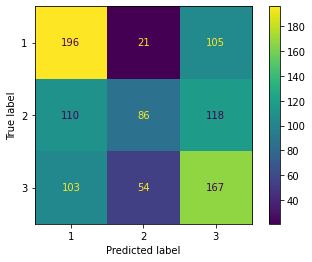

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


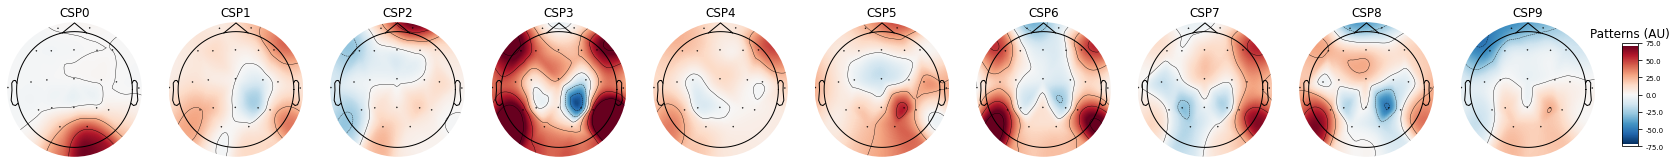




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.3587


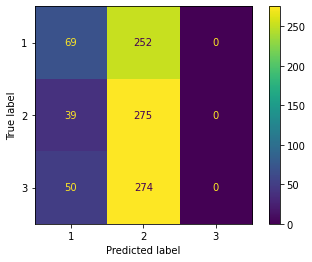

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


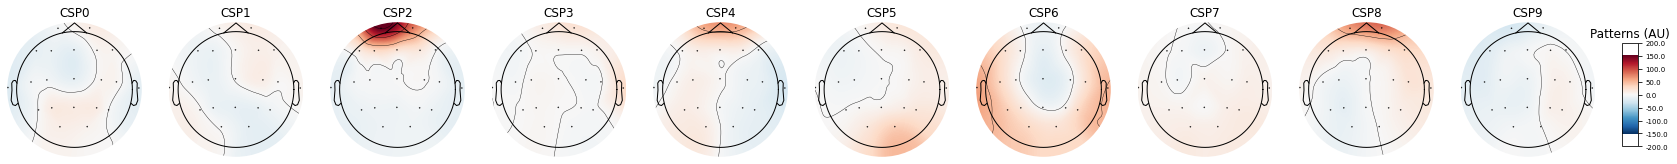




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.5518


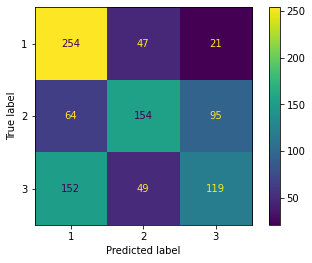

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


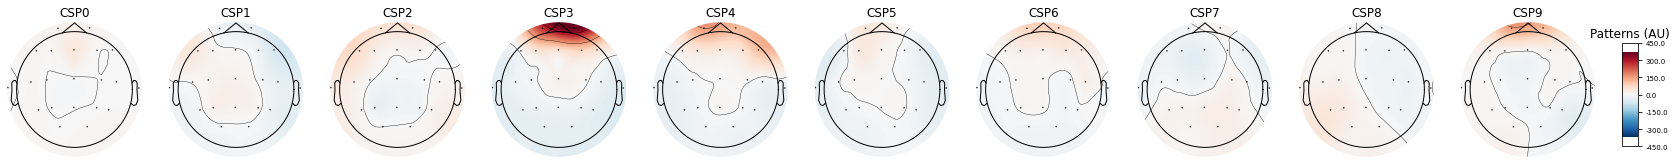

In [15]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        # Get all training data (all but last session of participant)
        mne_raws = CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for all those MNE raws (all training sessions)
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del i
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound

<hr>

### Same subject, new session: SVM classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For SVM:
            - The C: 0.01 | 0.1 | 1 | 10 | 100
            - The kernel: rbf | sigmoid | linear
            - When using the rbf of sigmoid kernel, the gamma: scale | auto | 10 | 1 | 0.1 | 0.01 | 0.001
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [16]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get all training data (all but last session of participant)
                mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                
                # Combine training data into singular mne raw
                mne_raw = mne.concatenate_raws(mne_raws)
                
                # Delete all raws since concat changes them
                del mne_raws
                
                # Get epochs for all those MNE raws (all training sessions)
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                svm = SVC()
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 6,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limited computational resources
                param_grid = [{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['rbf', 'sigmoid'],
                        "SVM__gamma":['scale', 'auto', 10, 1, 0.1, 0.01, 0.001]}
                              ,{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['linear']}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_cspsvm.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del svm
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: test split accuracy** | **Config**                                             |
|-------------|------------------------------------------|------------------------------------|--------------------------------------------------------|
| B           | 0.4625 +- 0.0276                         | 0.4677                             | 10 CSP components \| rbf SVM with C 10 and gamma 0.01  |
| C           | 0.8338 +- 0.0213                         | 0.3754                             | 10 CSP components \| rbf SVM with C 1 and gamma auto   |
| E           | 0.5816 +- 0.0255                         | 0.3895                             | 10 CSP components \| rbf SVM with C 1 and gamma scale  |

In [17]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_cspsvm.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {np.round(grid_search.best_score_, 4)} +- {np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4)} with the following parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.4625 +- 0.0276 with the following parameters
{'CSP__n_components': 10, 'SVM__C': 10, 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
192       5.568229      0.063741         0.054359        0.004185   
208       5.555005      0.064429         0.053316        0.001699   
224       6.946046      0.085665         0.013663        0.001490   
223       5.712160      0.093627         0.013874        0.000405   
222       5.512335      0.057571         0.014495        0.000957   
221       5.527065      0.066557         0.014496        0.000957   
209       5.585397      0.078837         0.021660        0.001490   
206       5.600729      0.075998         0.054316        0.003543   
178       5.528270      0.085942         0.054982        0.002645   
170       5.515809      0.097320         0.055316        0.001247   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
192                      10           10             0.01               rbf   
208                      10          100            0.001               rbf   
224                      10          100              NaN            linear   
223                      10           10              NaN            linear   
222                      10            1              NaN            linear   
221                      10          0.1              NaN            linear   
209                      10          100            0.001           sigmoid   
206                      10          100             0.01               rbf   
178                      10            1             0.01               rbf   
170                      10            1             auto               rbf   

     split0_test_score  split1_test_score  ...  std_test_score  \
192           0.481250           0.462500  ...        0.027577   
208           0.465625           0.453125  ...        0.027582   
224           0.456250           0.453125  ...        0.035536   
223           0.453125           0.456250  ...        0.035536   
222           0.456250           0.453125  ...        0.033869   
221           0.459375           0.456250  ...        0.033994   
209           0.459375           0.456250  ...        0.033994   
206           0.468750           0.425000  ...        0.027705   
178           0.481250           0.456250  ...        0.029547   
170           0.456250           0.425000  ...        0.026014   

     rank_test_score  split0_train_score  split1_train_score  \
192                1            0.532541            0.514393   
208                2            0.528160            0.509387   
224                3            0.531289            0.505006   
223                3            0.531289            0.507509   
222                5            0.534418            0.505632   
221                6            0.530038            0.506884   
209                6            0.530663            0.506884   
206                8            0.554443            0.533792   
178                9            0.523154            0.505632   
170               10            0.566333            0.538798   

     split2_train_score  split3_train_score  split4_train_score  \
192            0.505632            0.526909            0.505316   
208            0.504380            0.513141            0.495935   
224            0.496871            0.513767            0.490306   
223            0.496871            0.514393            0.488430   
222            0.492491            0.513767            0.490932   
221            0.500000            0.511264            0.495310   
209            0.500000            0.510013            0.495935   
206            0.541302            0.540676            0.533458   
178            0.495620            0.506258            0.490932   
170            0.545056            0.541302            0.534084   

     split5_train_score  mean_train_score  std_train_score  
192            0.495935          0.513454         0.012784  
208            0.490932          0.506989         0.012101  
224            0.48968



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
21        5.556853      0.094353         0.023493        0.001707   
159       5.541945      0.099997         0.019994        0.000577   
103       5.508948      0.091336         0.016995        0.001633   
47        5.486405      0.066430         0.016661        0.001598   
91        5.567795      0.061089         0.025658        0.000942   
161       5.620501      0.103255         0.029324        0.001374   
61        5.504968      0.055060         0.016661        0.001105   
33        5.499028      0.090676         0.016828        0.001213   
19        5.530873      0.085733         0.019660        0.001490   
89        5.538276      0.091236         0.018661        0.001598   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
21                        4          0.1                1           sigmoid   
159                      10          0.1               10           sigmoid   
103                       6            1               10           sigmoid   
47                        4           10               10           sigmoid   
91                        6          0.1                1           sigmoid   
161                      10          0.1                1           sigmoid   
61                        4          100               10           sigmoid   
33                        4            1               10           sigmoid   
19                        4          0.1               10           sigmoid   
89                        6          0.1               10           sigmoid   

     split0_test_score  split1_test_score  ...  std_test_score  \
21            0.296875           0.312500  ...        0.020845   
159           0.303125           0.318750  ...        0.016170   
103           0.259375           0.325000  ...        0.021060   
47            0.268750           0.271875  ...        0.024305   
91            0.296875           0.278125  ...        0.012310   
161           0.300000           0.275000  ...        0.012355   
61            0.268750           0.271875  ...        0.023402   
33            0.265625           0.271875  ...        0.024798   
19            0.268750           0.306250  ...        0.012291   
89            0.262500           0.268750  ...        0.023116   

     rank_test_score  split0_train_score  split1_train_score  \
21               216            0.287860            0.317272   
159              217            0.265332            0.298498   
103              218            0.289737            0.312265   
47               219            0.287860            0.271589   
91               220            0.288486            0.304130   
161              221            0.290989            0.270964   
61               222            0.287860            0.270964   
33               223            0.290363            0.267209   
19               224            0.278473            0.264706   
89               225            0.284731            0.289111   

     split2_train_score  split3_train_score  split4_train_score  \
21             0.282854            0.279725            0.285178   
159            0.280976            0.284105            0.305191   
103            0.279099            0.318523            0.292683   
47             0.280976            0.319775            0.276423   
91             0.282228            0.280350            0.278299   
161            0.277847            0.289111            0.303315   
61             0.280976            0.319149            0.276423   
33             0.282854            0.318523            0.275797   
19             0.286608            0.311014            0.272045   
89             0.275344            0.278473            0.293934   

     split5_train_score  mean_train_score  std_train_score  
21             0.322076          0.295827         0.017095  
159            0.286429          0.286755         0.012762  
103            0.29893



In total there are 225 different configurations tested.
The best mean test score is 0.4625
There are 1 configurations with this maximum score
There are 12 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       12.000000     12.000000        12.000000       12.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         5.681793      0.076658         0.035399        0.001759   
std          0.401739      0.015399         0.020002        0.001184   
min          5.512335      0.053502         0.013663        0.000373   
25%          5.527968      0.064257         0.014496        0.000957   
50%          5.561617      0.077418         0.037488        0.001490   
75%          5.589230      0.087863         0.054327        0.002247   
max          6.946046      0.097320         0.055316        0.004185   

        param_CSP__n_components  param_SVM__C  param_SVM__gamma  \
count                      12.0          12.0              8.00   
unique                      1.0           4.0              4.00   
top                        10.0         100.0              0.01   
freq                       12.0           4.0              4.00   
mean                        NaN           NaN               NaN   
std                         NaN           NaN               NaN   
min                         NaN           NaN               NaN   
25%                         NaN           NaN               NaN   
50%                         NaN           NaN               NaN   
75%                         NaN           NaN               NaN   
max                         NaN           NaN               NaN   

       param_SVM__kernel  split0_test_score  split1_test_score  ...  \
count                 12          12.000000          12.000000  ...   
unique                 3                NaN                NaN  ...   
top                  rbf                NaN                NaN  ...   
freq                   6                NaN                NaN  ...   
mean                 NaN           0.462240           0.448177  ...   
std                  NaN           0.010012           0.014193  ...   
min                  NaN           0.453125           0.425000  ...   
25%                  NaN           0.456250           0.446094  ...   
50%                  NaN           0.457812           0.454688  ...   
75%                  NaN           0.466406           0.456250  ...   
max                  NaN           0.481250           0.462500  ...   

        std_test_score  rank_test_score  split0_train_score  \
count        12.000000        12.000000           12.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean          0.030853         6.083333            0.538277   
std           0.003774         3.315483            0.015063   
min           0.026014         1.000000            0.523154   
25%           0.027581         3.000000            0.530507   
50%           0.031210         6.000000            0.531289   
75%           0.033994         9.250000            0.539424   
max           0.035536        10.000000            0.566333   

        split1_train_score  split2_train_score  split3_train_score  \
count            12.000000           12.000000           12.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.514758            0.510117            0.520338   
std               0.013794            0.020643            0.013412   
min               0.504380            0.492491            0.506258   
25%               0.505632            0.496871            0.511264   
50%               0.507196            0.500000            0.513767   
75%               0.519243  




####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.8339 +- 0.0213 with the following parameters
{'CSP__n_components': 10, 'SVM__C': 1, 'SVM__gamma': 'auto', 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
170       5.465572      0.048488         0.030657        0.000942   
176       5.503598      0.048057         0.031324        0.000942   
168       5.448316      0.043673         0.029990        0.000816   
192       5.440268      0.065889         0.029324        0.001247   
206       5.447359      0.053554         0.026159        0.000687   
154       5.475635      0.060550         0.043653        0.001374   
184       5.450008      0.049254         0.027158        0.002733   
190       5.449612      0.059454         0.028657        0.004817   
221       5.440358      0.062691         0.010497        0.000764   
223       5.502102      0.066761         0.009330        0.000745   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
170                      10            1             auto               rbf   
176                      10            1              0.1               rbf   
168                      10            1            scale               rbf   
192                      10           10             0.01               rbf   
206                      10          100             0.01               rbf   
154                      10          0.1            scale               rbf   
184                      10           10             auto               rbf   
190                      10           10              0.1               rbf   
221                      10          0.1              NaN            linear   
223                      10           10              NaN            linear   

     split0_test_score  split1_test_score  ...  std_test_score  \
170           0.837500           0.806250  ...        0.021303   
176           0.837500           0.806250  ...        0.021303   
168           0.840625           0.800000  ...        0.018170   
192           0.828125           0.793750  ...        0.021607   
206           0.837500           0.800000  ...        0.017647   
154           0.834375           0.803125  ...        0.024324   
184           0.840625           0.784375  ...        0.024766   
190           0.840625           0.784375  ...        0.024766   
221           0.825000           0.781250  ...        0.021092   
223           0.815625           0.781250  ...        0.021399   

     rank_test_score  split0_train_score  split1_train_score  \
170                1            0.855000            0.853125   
176                1            0.855000            0.853125   
168                3            0.874375            0.870625   
192                4            0.840625            0.843125   
206                5            0.859375            0.855625   
154                6            0.835000            0.851250   
184                7            0.890625            0.886250   
190                7            0.890625            0.886250   
221                9            0.829375            0.838125   
223                9            0.825625            0.839375   

     split2_train_score  split3_train_score  split4_train_score  \
170            0.851250            0.844375            0.864375   
176            0.851250            0.844375            0.864375   
168            0.869375            0.857500            0.880625   
192            0.839375            0.831875            0.851250   
206            0.851875            0.843750            0.865625   
154            0.843750            0.823125            0.848750   
184            0.871250            0.870000            0.887500   
190            0.871250            0.870000            0.887500   
221            0.834375            0.823750            0.843750   
223            0.835625            0.825625            0.851250   

     split5_train_score  mean_train_score  std_train_score  
170            0.858125          0.854375         0.006134  
176            0.858125          0.854375         0.006134  
168            0.86875



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
10       5.501662      0.042406         0.051650        0.000745   
12       5.498958      0.082246         0.053861        0.002197   
82       5.487833      0.079256         0.053316        0.000745   
13       5.448689      0.054929         0.018161        0.000373   
96       5.534901      0.058348         0.053150        0.000373   
81       5.487553      0.062595         0.019161        0.000372   
97       5.510097      0.058802         0.018994        0.000578   
27       5.477552      0.058636         0.018827        0.002409   
11       5.490853      0.042248         0.020327        0.004345   
19       5.521237      0.092961         0.020827        0.002671   

   param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
10                       4         0.01             0.01               rbf   
12                       4         0.01            0.001               rbf   
82                       6         0.01            0.001               rbf   
13                       4         0.01            0.001           sigmoid   
96                       6          0.1            0.001               rbf   
81                       6         0.01             0.01           sigmoid   
97                       6          0.1            0.001           sigmoid   
27                       4          0.1            0.001           sigmoid   
11                       4         0.01             0.01           sigmoid   
19                       4          0.1               10           sigmoid   

    split0_test_score  split1_test_score  ...  std_test_score  \
10           0.337500            0.33750  ...    5.551115e-17   
12           0.337500            0.33750  ...    5.551115e-17   
82           0.337500            0.33750  ...    5.551115e-17   
13           0.337500            0.33750  ...    5.551115e-17   
96           0.337500            0.33750  ...    5.551115e-17   
81           0.337500            0.33750  ...    5.551115e-17   
97           0.337500            0.33750  ...    5.551115e-17   
27           0.337500            0.33750  ...    5.551115e-17   
11           0.337500            0.33750  ...    5.551115e-17   
19           0.384375            0.46875  ...    8.082823e-02   

    rank_test_score  split0_train_score  split1_train_score  \
10              202              0.3375            0.337500   
12              202              0.3375            0.337500   
82              202              0.3375            0.337500   
13              202              0.3375            0.337500   
96              202              0.3375            0.337500   
81              202              0.3375            0.337500   
97              202              0.3375            0.337500   
27              202              0.3375            0.337500   
11              202              0.3375            0.337500   
19              225              0.3650            0.399375   

    split2_train_score  split3_train_score  split4_train_score  \
10            0.337500            0.337500              0.3375   
12            0.337500            0.337500              0.3375   
82            0.337500            0.337500              0.3375   
13            0.337500            0.337500              0.3375   
96            0.337500            0.337500              0.3375   
81            0.337500            0.337500              0.3375   
97            0.337500            0.337500              0.3375   
27            0.337500            0.337500              0.3375   
11            0.337500            0.337500              0.3375   
19            0.265625            0.215625              0.2750   

    split5_train_score  mean_train_score  std_train_score  
10            0.337500          0.337500     5.551115e-17  
12            0.337500          0.337500     5.551115e-17  
82            0.337500          0.337500     5.551115e-17  
13            0.337



In total there are 225 different configurations tested.
The best mean test score is 0.8339
There are 2 configurations with this maximum score
There are 26 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       26.000000     26.000000        26.000000    2.600000e+01   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         5.477356      0.059524         0.027154    1.673842e-03   
std          0.069465      0.010608         0.013542    1.671689e-03   
min          5.431840      0.043673         0.008540    7.240322e-07   
25%          5.447602      0.051378         0.013246    7.449866e-04   
50%          5.455959      0.058473         0.028598    9.711213e-04   
75%          5.484652      0.062394         0.039154    1.673418e-03   
max          5.797031      0.086795         0.051691    6.469727e-03   

        param_CSP__n_components  param_SVM__C  param_SVM__gamma  \
count                      26.0          26.0             21.00   
unique                      1.0           5.0              6.00   
top                        10.0          10.0              0.01   
freq                       26.0           8.0              6.00   
mean                        NaN           NaN               NaN   
std                         NaN           NaN               NaN   
min                         NaN           NaN               NaN   
25%                         NaN           NaN               NaN   
50%                         NaN           NaN               NaN   
75%                         NaN           NaN               NaN   
max                         NaN           NaN               NaN   

       param_SVM__kernel  split0_test_score  split1_test_score  ...  \
count                 26          26.000000          26.000000  ...   
unique                 3                NaN                NaN  ...   
top                  rbf                NaN                NaN  ...   
freq                  16                NaN                NaN  ...   
mean                 NaN           0.822476           0.791106  ...   
std                  NaN           0.011892           0.010372  ...   
min                  NaN           0.796875           0.775000  ...   
25%                  NaN           0.815625           0.781250  ...   
50%                  NaN           0.821875           0.793750  ...   
75%                  NaN           0.832812           0.799219  ...   
max                  NaN           0.840625           0.812500  ...   

        std_test_score  rank_test_score  split0_train_score  \
count        26.000000        26.000000           26.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean          0.019908        12.692308            0.847716   
std           0.003035         7.556556            0.031903   
min           0.014254         1.000000            0.823125   
25%           0.017514         7.000000            0.827500   
50%           0.020578        11.500000            0.830000   
75%           0.021998        19.000000            0.858281   
max           0.024766        26.000000            0.943750   

        split1_train_score  split2_train_score  split3_train_score  \
count            26.000000           26.000000           26.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.852187            0.848413            0.838173   
std               0.026965            0.024916            0.029282   
min               0.830625            0.829375            0.812500   
25%               0.836406            0.834375            0.822188   
50%               0.839063            0.837813            0.825313   
75%               0.855000  




####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.5816 +- 0.0255 with the following parameters
{'CSP__n_components': 10, 'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
168       5.482249      0.029599         0.050150        0.001950   
206       5.616039      0.059804         0.048818        0.002266   
176       5.504242      0.047538         0.049484        0.001117   
170       5.488913      0.047904         0.049317        0.002134   
154       5.508740      0.065091         0.055316        0.002494   
192       5.513239      0.031337         0.049651        0.001105   
162       5.516238      0.034486         0.056316        0.002493   
156       5.518404      0.058280         0.058315        0.002285   
190       5.503409      0.045187         0.046318        0.001795   
184       5.517238      0.039345         0.046985        0.001000   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
168                      10            1            scale               rbf   
206                      10          100             0.01               rbf   
176                      10            1              0.1               rbf   
170                      10            1             auto               rbf   
154                      10          0.1            scale               rbf   
192                      10           10             0.01               rbf   
162                      10          0.1              0.1               rbf   
156                      10          0.1             auto               rbf   
190                      10           10              0.1               rbf   
184                      10           10             auto               rbf   

     split0_test_score  split1_test_score  ...  std_test_score  \
168           0.568750           0.546875  ...        0.025547   
206           0.578125           0.550000  ...        0.035902   
176           0.559375           0.537500  ...        0.029201   
170           0.559375           0.537500  ...        0.029201   
154           0.531250           0.562500  ...        0.022409   
192           0.553125           0.546875  ...        0.029420   
162           0.509375           0.568750  ...        0.026863   
156           0.509375           0.568750  ...        0.026863   
190           0.562500           0.562500  ...        0.013333   
184           0.562500           0.562500  ...        0.013333   

     rank_test_score  split0_train_score  split1_train_score  \
168                1            0.663745            0.673763   
206                2            0.632436            0.647464   
176                3            0.639950            0.652473   
170                3            0.639950            0.652473   
154                5            0.602379            0.626800   
192                6            0.611772            0.618660   
162                7            0.577959            0.614277   
156                7            0.577959            0.614277   
190                9            0.697558            0.701315   
184                9            0.697558            0.701315   

     split2_train_score  split3_train_score  split4_train_score  \
168            0.653726            0.660826            0.670839   
206            0.619912            0.638298            0.634543   
176            0.633688            0.642053            0.642678   
170            0.633688            0.642053            0.642678   
154            0.605510            0.615144            0.615144   
192            0.607389            0.607009            0.613892   
162            0.601127            0.589487            0.595119   
156            0.601127            0.589487            0.595119   
190            0.700063            0.695244            0.693992   
184            0.700063            0.695244            0.693992   

     split5_train_score  mean_train_score  std_train_score  
168            0.657697          0.663433         0.007019  
206            0.634543          0.634533         0.008160  
176            0.63642



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
47       5.462255      0.066934         0.018328        0.000943   
33       6.413369      0.119142         0.019494        0.001708   
29       5.460122      0.053549         0.016828        0.001950   
19       5.495521      0.033737         0.018661        0.000745   
57       5.498077      0.058346         0.017828        0.002671   
21       5.525791      0.046490         0.021494        0.001708   
43       5.450592      0.040709         0.015662        0.000745   
49       5.556558      0.046089         0.020827        0.001343   
63       5.492245      0.055231         0.020494        0.001384   
35       5.905614      0.185749         0.021659        0.001885   

   param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
47                       4           10               10           sigmoid   
33                       4            1               10           sigmoid   
29                       4            1            scale           sigmoid   
19                       4          0.1               10           sigmoid   
57                       4          100            scale           sigmoid   
21                       4          0.1                1           sigmoid   
43                       4           10            scale           sigmoid   
49                       4           10                1           sigmoid   
63                       4          100                1           sigmoid   
35                       4            1                1           sigmoid   

    split0_test_score  split1_test_score  ...  std_test_score  \
47           0.309375           0.281250  ...        0.066304   
33           0.309375           0.278125  ...        0.067198   
29           0.262500           0.306250  ...        0.036929   
19           0.309375           0.281250  ...        0.052732   
57           0.253125           0.306250  ...        0.043852   
21           0.293750           0.293750  ...        0.046362   
43           0.253125           0.300000  ...        0.043362   
49           0.287500           0.290625  ...        0.041935   
63           0.287500           0.287500  ...        0.043702   
35           0.287500           0.290625  ...        0.044103   

    rank_test_score  split0_train_score  split1_train_score  \
47              215            0.278647            0.288666   
33              217            0.278647            0.286788   
29              218            0.296807            0.300564   
19              219            0.279274            0.292423   
57              220            0.302442            0.303694   
21              221            0.277395            0.284283   
43              222            0.298059            0.302442   
49              223            0.273012            0.286162   
63              224            0.273638            0.293676   
35              225            0.273012            0.287414   

    split2_train_score  split3_train_score  split4_train_score  \
47            0.393863            0.283479            0.285357   
33            0.395116            0.282228            0.284731   
29            0.417032            0.287234            0.299124   
19            0.385097            0.280976            0.285982   
57            0.420789            0.288486            0.295369   
21            0.377583            0.285982            0.285357   
43            0.421415            0.287860            0.309136   
49            0.401378            0.285982            0.287860   
63            0.400751            0.284731            0.288486   
35            0.400751            0.286608            0.284105   

    split5_train_score  mean_train_score  std_train_score  
47            0.296621          0.304439         0.040364  
33            0.296621          0.304022         0.041111  
29            0.304130          0.317482         0.044822  
19            0.294



In total there are 225 different configurations tested.
The best mean test score is 0.5816
There are 1 configurations with this maximum score
There are 10 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       10.000000     10.000000        10.000000       10.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         5.516871      0.045857         0.051067        0.001864   
std          0.036875      0.012352         0.004094        0.000587   
min          5.482249      0.029599         0.046318        0.001000   
25%          5.503617      0.035700         0.048942        0.001287   
50%          5.510989      0.046362         0.049568        0.002042   
75%          5.516988      0.055686         0.054025        0.002280   
max          5.616039      0.065091         0.058315        0.002494   

        param_CSP__n_components  param_SVM__C  param_SVM__gamma  \
count                      10.0          10.0              10.0   
unique                      1.0           4.0               4.0   
top                        10.0           1.0               0.1   
freq                       10.0           3.0               3.0   
mean                        NaN           NaN               NaN   
std                         NaN           NaN               NaN   
min                         NaN           NaN               NaN   
25%                         NaN           NaN               NaN   
50%                         NaN           NaN               NaN   
75%                         NaN           NaN               NaN   
max                         NaN           NaN               NaN   

       param_SVM__kernel  split0_test_score  split1_test_score  ...  \
count                 10          10.000000          10.000000  ...   
unique                 1                NaN                NaN  ...   
top                  rbf                NaN                NaN  ...   
freq                  10                NaN                NaN  ...   
mean                 NaN           0.549375           0.554375  ...   
std                  NaN           0.024242           0.012076  ...   
min                  NaN           0.509375           0.537500  ...   
25%                  NaN           0.536719           0.546875  ...   
50%                  NaN           0.559375           0.556250  ...   
75%                  NaN           0.562500           0.562500  ...   
max                  NaN           0.578125           0.568750  ...   

        std_test_score  rank_test_score  split0_train_score  \
count        10.000000        10.000000           10.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean          0.025207         5.200000            0.634126   
std           0.007145         2.859681            0.043221   
min           0.013333         1.000000            0.577959   
25%           0.023194         3.000000            0.604728   
50%           0.026863         5.500000            0.636193   
75%           0.029201         7.000000            0.657796   
max           0.035902         9.000000            0.697558   

        split1_train_score  split2_train_score  split3_train_score  \
count            10.000000           10.000000           10.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.650282            0.635629            0.637484   
std               0.033203            0.037963            0.038435   
min               0.614277            0.601127            0.589487   
25%               0.620695            0.605980            0.609043   
50%               0.649969            0.626800            0.640175   
75%               0.668441  




####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.4677


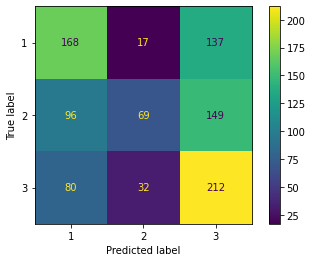

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


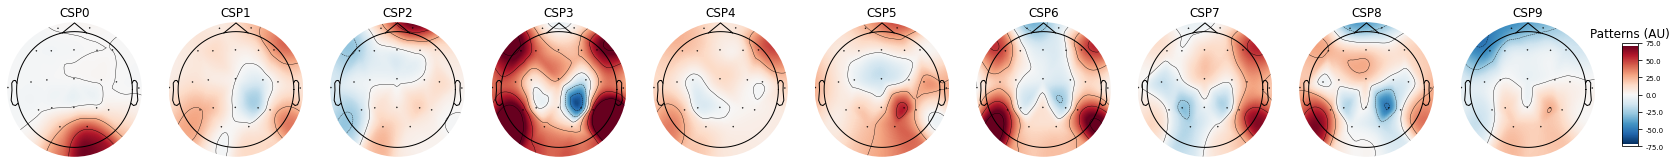




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.3754


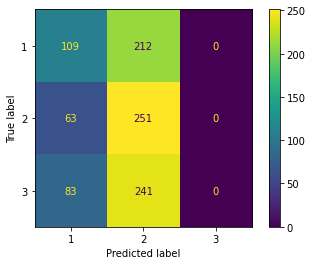

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


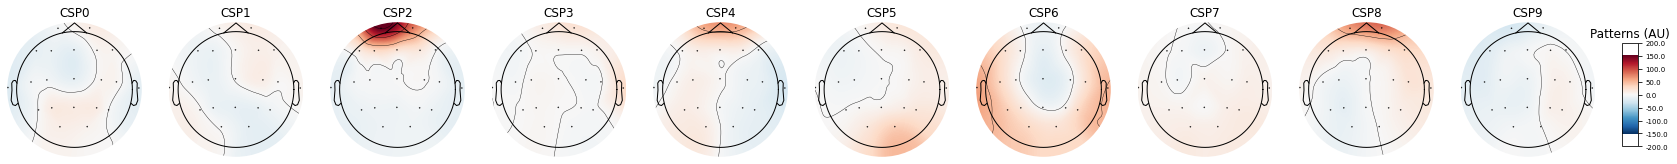




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.3895


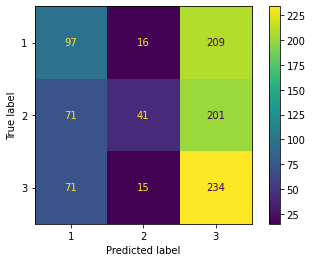

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


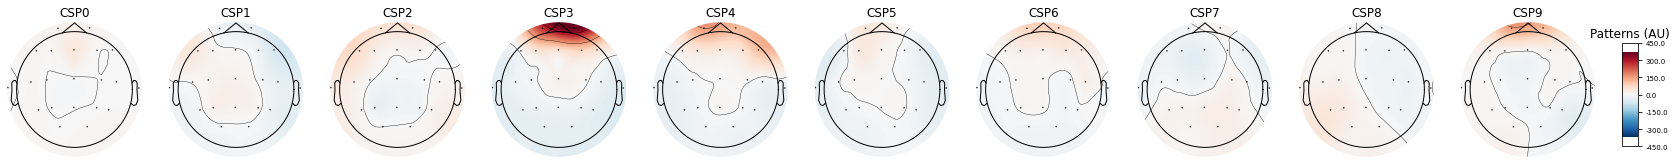

In [18]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_svm_kernel = ["rbf", "rbf", "sigmoid"]
best_found_svm_c = [10, 1, 1]
best_found_svm_gamma = [0.01, "auto", "scale"]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        # Get all training data (all but last session of participant)
        mne_raws = CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for all those MNE raws (all training sessions)
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    svm = SVC(kernel= best_found_svm_kernel[i],
              C= best_found_svm_c[i],
              gamma= best_found_svm_gamma[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_svm_kernel
del best_found_svm_c
del best_found_svm_gamma
del i
del X_test
del y_test
del X_train
del y_train
del csp
del svm
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound

<hr>

### Same subject, new session: RF classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For RF:
            - Bootstrap is always set to True as it is, besides random feature subsets, one of the ways to reduce data biases during training
            - The metric used for splitting criterion is gini as it is faster than entropy and the performance difference is negligible when looking at the experimental notebooks
            - Number of estimators: 10 | 50 | 100 | 250 | 500
            - Max depth of a tree: None | 3 | 10 | 20 | 35 | 50 | 75 | 100
            - Minimum number of samples to do a split: 2 | 5 | 10
            - Minimum samples to have a leaf is not set as it is related to the number of samples per split and max depth of the tree
            - Maximum features per tree: sqrt | log2 | None
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [19]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get all training data (all but last session of participant)
                mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                
                # Combine training data into singular mne raw
                mne_raw = mne.concatenate_raws(mne_raws)
                
                # Delete all raws since concat changes them
                del mne_raws
                
                # Get epochs for all those MNE raws (all training sessions)
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                rf = RandomForestClassifier(bootstrap= True,
                                            criterion= "gini")
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('RF', rf)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 6,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [4, 6, 10],
                               "RF__n_estimators": [10, 50, 100, 250, 500],
                               "RF__max_depth": [None, 3, 10],
                               "RF__min_samples_split": [2, 5, 10],
                               "RF__max_features": ["sqrt", "log2", "None", 0.2, 0.4, 0.6]}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csprf.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del rf
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject** | **CSP + RF: cross validation accuracy** | **CSP + RF: test split accuracy** | **Config**                                                                                   |
|-------------|-----------------------------------------|-----------------------------------|----------------------------------------------------------------------------------------------|
| B           | 0.4489 +- 0.0351                        | 0.4406                            | 10 CSP components \| RF with max depth 3, 0.4 features, 10 min sample split, 500 estimators  |
| C           | 0.8198 +- 0.0198                        | 0.3462                            | 10 CSP components \| RF with max depth None, 0.2 features, 2 min sample split, 50 estimators |
| E           | 0.5770 +- 0.0290                        | 0.4911                            | 10 CSP components \| RF with max depth 10, 0.4 features, 10 min sample split, 250 estimators |

In [20]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csprf.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {np.round(grid_search.best_score_, 4)} +- {np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4)} with the following parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.4489 +- 0.0351 with the following parameters
{'CSP__n_components': 10, 'RF__max_depth': 3, 'RF__max_features': 0.4, 'RF__min_samples_split': 10, 'RF__n_estimators': 500}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
704       6.288822      0.033622         0.055982        0.004508   
647       5.473083      0.066109         0.014329        0.000471   
698       5.724003      0.024250         0.028991        0.000577   
699       6.274327      0.054617         0.053983        0.000577   
649       6.198851      0.051525         0.055316        0.001105   
690       5.215166      0.029022         0.005165        0.000372   
648       5.705676      0.045883         0.031156        0.003974   
659       6.189020      0.022069         0.054316        0.000471   
693       5.727002      0.038843         0.029157        0.000687   
702       5.392275      0.025105         0.014329        0.000471   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
704                      10                   3                    0.4   
647                      10                   3                   log2   
698                      10                   3                    0.4   
699                      10                   3                    0.4   
649                      10                   3                   log2   
690                      10                   3                    0.4   
648                      10                   3                   log2   
659                      10                   3                   log2   
693                      10                   3                    0.4   
702                      10                   3                    0.4   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
704                          10                    500           0.475000   
647                           2                    100           0.478125   
698                           5                    250           0.459375   
699                           5                    500           0.481250   
649                           2                    500           0.478125   
690                           2                     10           0.481250   
648                           2                    250           0.471875   
659                          10                    500           0.481250   
693                           2                    250           0.471875   
702                          10                    100           0.456250   

     ...  std_test_score  rank_test_score  split0_train_score  \
704  ...        0.035137                1            0.540050   
647  ...        0.035396                2            0.538798   
698  ...        0.031401                3            0.537547   
699  ...        0.030516                4            0.540050   
649  ...        0.034705                5            0.550063   
690  ...        0.033004                6            0.521902   
648  ...        0.032963                7            0.549437   
659  ...        0.036880                8            0.543179   
693  ...        0.035690                9            0.537547   
702  ...        0.033377               10            0.541927   

     split1_train_score  split2_train_score  split3_train_score  \
704            0.523154            0.516270            0.534418   
647            0.543179            0.517522            0.546934   
698            0.520025            0.511890            0.537547   
699            0.516270            0.513767            0.534418   
649            0.533792            0.513141            0.544431   
690            0.506884            0.505632            0.518773   
648            0.535044            0.513767            0.532541   
659            0.537547            0.511264            0.540050   
693            0.526909            0.516896            0.533792   
702            0.525031            0.516270            0.533166   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
704            0.519074            0.512195    



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
489       5.310468      0.040122              0.0             0.0   
481       5.201670      0.050766              0.0             0.0   
403       5.258152      0.033508              0.0             0.0   
402       5.203669      0.048178              0.0             0.0   
401       5.189840      0.037868              0.0             0.0   
400       5.218998      0.047122              0.0             0.0   
399       5.432763      0.083974              0.0             0.0   
398       5.278645      0.034963              0.0             0.0   
480       5.166847      0.039080              0.0             0.0   
404       5.323298      0.029294              0.0             0.0   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
489                       6                  10                   None   
481                       6                  10                   None   
403                       6                   3                   None   
402                       6                   3                   None   
401                       6                   3                   None   
400                       6                   3                   None   
399                       6                   3                   None   
398                       6                   3                   None   
480                       6                  10                   None   
404                       6                   3                   None   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
489                           5                    500                NaN   
481                           2                     50                NaN   
403                          10                    250                NaN   
402                          10                    100                NaN   
401                          10                     50                NaN   
400                          10                     10                NaN   
399                           5                    500                NaN   
398                           5                    250                NaN   
480                           2                     10                NaN   
404                          10                    500                NaN   

     ...  std_test_score  rank_test_score  split0_train_score  \
489  ...             NaN              801                 NaN   
481  ...             NaN              802                 NaN   
403  ...             NaN              803                 NaN   
402  ...             NaN              804                 NaN   
401  ...             NaN              805                 NaN   
400  ...             NaN              806                 NaN   
399  ...             NaN              807                 NaN   
398  ...             NaN              808                 NaN   
480  ...             NaN              809                 NaN   
404  ...             NaN              810                 NaN   

     split1_train_score  split2_train_score  split3_train_score  \
489                 NaN                 NaN                 NaN   
481                 NaN                 NaN                 NaN   
403                 NaN                 NaN                 NaN   
402                 NaN                 NaN                 NaN   
401                 NaN                 NaN                 NaN   
400                 NaN                 NaN                 NaN   
399                 NaN                 NaN                 NaN   
398                 NaN                 NaN                 NaN   
480                 NaN                 NaN                 NaN   
404                 NaN                 NaN                 NaN   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
489                 NaN                 NaN    



In total there are 810 different configurations tested.
The best mean test score is 0.4489
There are 1 configurations with this maximum score
There are 146 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count      146.000000    146.000000       146.000000    1.460000e+02   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         5.724071      0.043302         0.029333    1.110624e-03   
std          0.474131      0.011790         0.020131    1.325608e-03   
min          5.184343      0.018081         0.004999    1.777067e-07   
25%          5.345166      0.034625         0.013204    4.710965e-04   
50%          5.605790      0.042823         0.028574    5.771021e-04   
75%          6.027031      0.052105         0.053608    1.105207e-03   
max          7.354648      0.077664         0.071810    8.231705e-03   

        param_CSP__n_components  param_RF__max_depth param_RF__max_features  \
count                     146.0                137.0                    146   
unique                      2.0                  2.0                      5   
top                        10.0                  3.0                   sqrt   
freq                       99.0                110.0                     33   
mean                        NaN                  NaN                    NaN   
std                         NaN                  NaN                    NaN   
min                         NaN                  NaN                    NaN   
25%                         NaN                  NaN                    NaN   
50%                         NaN                  NaN                    NaN   
75%                         NaN                  NaN                    NaN   
max                         NaN                  NaN                    NaN   

        param_RF__min_samples_split  param_RF__n_estimators  \
count                         146.0                   146.0   
unique                          3.0                     5.0   
top                            10.0                   500.0   
freq                           54.0                    40.0   
mean                            NaN                     NaN   
std                             NaN                     NaN   
min                             NaN                     NaN   
25%                             NaN                     NaN   
50%                             NaN                     NaN   
75%                             NaN                     NaN   
max                             NaN                     NaN   

        split0_test_score  ...  std_test_score  rank_test_score  \
count          146.000000  ...      146.000000       146.000000   
unique                NaN  ...             NaN              NaN   
top                   NaN  ...             NaN              NaN   
freq                  NaN  ...             NaN              NaN   
mean             0.457663  ...        0.028474        73.452055   
std              0.012981  ...        0.006108        42.313621   
min              0.428125  ...        0.014030         1.000000   
25%              0.450000  ...        0.024821        37.250000   
50%              0.456250  ...        0.028377        73.500000   
75%              0.465625  ...        0.033295       109.750000   
max              0.481250  ...        0.040330       146.000000   

        split0_train_score  split1_train_score  split2_train_score  \
count           146.000000          146.000000          146.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.629155            0.628470            0.619550   
std               0.182232            0.185578            0.193853   
min               0.492491            0.493742            0.493742   
25%               0.512672            0.517522            0.505632   
50




####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.8198 +- 0.0198 with the following parameters
{'CSP__n_components': 10, 'RF__max_depth': None, 'RF__max_features': 0.2, 'RF__min_samples_split': 2, 'RF__n_estimators': 50}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
586       5.468418      0.071404         0.014496        0.006549   
558       6.179690      0.057260         0.036989        0.000817   
587       5.598710      0.043140         0.017828        0.001067   
768       5.996082      0.053971         0.037821        0.004596   
592       5.609207      0.054281         0.018494        0.000500   
615       5.382945      0.069358         0.006498        0.000499   
567       5.641696      0.029298         0.017495        0.000957   
774       6.660537      0.057995         0.066645        0.001598   
781       5.485912      0.052559         0.011497        0.001258   
738       6.136705      0.030369         0.036155        0.002339   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
586                      10                None                    0.2   
558                      10                None                   log2   
587                      10                None                    0.2   
768                      10                  10                    0.2   
592                      10                None                    0.2   
615                      10                None                    0.6   
567                      10                None                   log2   
774                      10                  10                    0.2   
781                      10                  10                    0.4   
738                      10                  10                   log2   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
586                           2                     50           0.818750   
558                           2                    250           0.793750   
587                           2                    100           0.806250   
768                           2                    250           0.803125   
592                           5                    100           0.809375   
615                           2                     10           0.812500   
567                          10                    100           0.803125   
774                           5                    500           0.800000   
781                           2                     50           0.796875   
738                           2                    250           0.796875   

     ...  std_test_score  rank_test_score  split0_train_score  \
586  ...        0.019819                1            0.999375   
558  ...        0.026125                2            1.000000   
587  ...        0.018641                3            1.000000   
768  ...        0.019348                4            0.976250   
592  ...        0.019094                4            0.998125   
615  ...        0.025430                6            0.985625   
567  ...        0.024122                7            0.960625   
774  ...        0.019073                7            0.970000   
781  ...        0.024788                9            0.979375   
738  ...        0.022146               10            0.982500   

     split1_train_score  split2_train_score  split3_train_score  \
586            1.000000            1.000000            0.999375   
558            1.000000            1.000000            1.000000   
587            1.000000            1.000000            1.000000   
768            0.981250            0.983750            0.981250   
592            0.995625            0.995000            0.996875   
615            0.988125            0.988750            0.991250   
567            0.957500            0.962500            0.957500   
774            0.964375            0.971875            0.966875   
781            0.981250            0.983125            0.985000   
738            0.985625            0.986875            0.983125   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
586            1.000000            0.999375    



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
489       5.441760      0.072491              0.0             0.0   
481       5.347956      0.050206              0.0             0.0   
403       5.352288      0.050912              0.0             0.0   
402       5.313301      0.061456              0.0             0.0   
401       5.283144      0.054436              0.0             0.0   
400       5.299139      0.065402              0.0             0.0   
399       5.402773      0.034252              0.0             0.0   
398       5.354954      0.058481              0.0             0.0   
480       5.284477      0.053404              0.0             0.0   
404       5.430597      0.048202              0.0             0.0   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
489                       6                  10                   None   
481                       6                  10                   None   
403                       6                   3                   None   
402                       6                   3                   None   
401                       6                   3                   None   
400                       6                   3                   None   
399                       6                   3                   None   
398                       6                   3                   None   
480                       6                  10                   None   
404                       6                   3                   None   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
489                           5                    500                NaN   
481                           2                     50                NaN   
403                          10                    250                NaN   
402                          10                    100                NaN   
401                          10                     50                NaN   
400                          10                     10                NaN   
399                           5                    500                NaN   
398                           5                    250                NaN   
480                           2                     10                NaN   
404                          10                    500                NaN   

     ...  std_test_score  rank_test_score  split0_train_score  \
489  ...             NaN              801                 NaN   
481  ...             NaN              802                 NaN   
403  ...             NaN              803                 NaN   
402  ...             NaN              804                 NaN   
401  ...             NaN              805                 NaN   
400  ...             NaN              806                 NaN   
399  ...             NaN              807                 NaN   
398  ...             NaN              808                 NaN   
480  ...             NaN              809                 NaN   
404  ...             NaN              810                 NaN   

     split1_train_score  split2_train_score  split3_train_score  \
489                 NaN                 NaN                 NaN   
481                 NaN                 NaN                 NaN   
403                 NaN                 NaN                 NaN   
402                 NaN                 NaN                 NaN   
401                 NaN                 NaN                 NaN   
400                 NaN                 NaN                 NaN   
399                 NaN                 NaN                 NaN   
398                 NaN                 NaN                 NaN   
480                 NaN                 NaN                 NaN   
404                 NaN                 NaN                 NaN   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
489                 NaN                 NaN    



In total there are 810 different configurations tested.
The best mean test score is 0.8198
There are 1 configurations with this maximum score
There are 129 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count      129.000000    129.000000       129.000000    1.290000e+02   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         6.113911      0.055613         0.031845    1.764666e-03   
std          0.722545      0.021618         0.022401    1.986289e-03   
min          5.327130      0.024757         0.005665    4.298152e-07   
25%          5.567220      0.044128         0.011497    6.870479e-04   
50%          5.866124      0.052559         0.018494    9.996495e-04   
75%          6.632546      0.063156         0.039488    1.885214e-03   
max          8.312841      0.239322         0.076809    1.085416e-02   

        param_CSP__n_components  param_RF__max_depth  param_RF__max_features  \
count                     129.0                 66.0                   129.0   
unique                      2.0                  1.0                     5.0   
top                        10.0                 10.0                     0.6   
freq                      128.0                 66.0                    27.0   
mean                        NaN                  NaN                     NaN   
std                         NaN                  NaN                     NaN   
min                         NaN                  NaN                     NaN   
25%                         NaN                  NaN                     NaN   
50%                         NaN                  NaN                     NaN   
75%                         NaN                  NaN                     NaN   
max                         NaN                  NaN                     NaN   

        param_RF__min_samples_split  param_RF__n_estimators  \
count                         129.0                   129.0   
unique                          3.0                     5.0   
top                            10.0                   250.0   
freq                           44.0                    31.0   
mean                            NaN                     NaN   
std                             NaN                     NaN   
min                             NaN                     NaN   
25%                             NaN                     NaN   
50%                             NaN                     NaN   
75%                             NaN                     NaN   
max                             NaN                     NaN   

        split0_test_score  ...  std_test_score  rank_test_score  \
count          129.000000  ...      129.000000       129.000000   
unique                NaN  ...             NaN              NaN   
top                   NaN  ...             NaN              NaN   
freq                  NaN  ...             NaN              NaN   
mean             0.796342  ...        0.020744        63.620155   
std              0.007351  ...        0.003154        37.547926   
min              0.771875  ...        0.011219         1.000000   
25%              0.790625  ...        0.018786        31.000000   
50%              0.796875  ...        0.020963        60.000000   
75%              0.800000  ...        0.022535        94.000000   
max              0.818750  ...        0.028565       128.000000   

        split0_train_score  split1_train_score  split2_train_score  \
count           129.000000          129.000000          129.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.972611            0.971773            0.975426   
std               0.021050            0.023346            0.020466   
min               0.921875            0.921875            0.923125   
25%               0.961250            0.956250            0.




####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.577 +- 0.029 with the following parameters
{'CSP__n_components': 10, 'RF__max_depth': 10, 'RF__max_features': 0.4, 'RF__min_samples_split': 10, 'RF__n_estimators': 250}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
793       6.246836      0.058861         0.034156        0.000687   
808       6.637710      0.042254         0.034489        0.000500   
724       6.972770      0.058687         0.064813        0.000897   
743       6.102215      0.074741         0.035822        0.000687   
732       5.587380      0.017596         0.016161        0.000372   
554       7.116558      0.025470         0.068145        0.002192   
723       6.103382      0.068446         0.034822        0.000687   
731       5.417767      0.070397         0.010497        0.000764   
612       5.674352      0.039028         0.016995        0.000577   
597       5.523401      0.029758         0.017161        0.000897   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
793                      10                  10                    0.4   
808                      10                  10                    0.6   
724                      10                  10                   sqrt   
743                      10                  10                   log2   
732                      10                  10                   sqrt   
554                      10                None                   sqrt   
723                      10                  10                   sqrt   
731                      10                  10                   sqrt   
612                      10                None                    0.4   
597                      10                None                    0.2   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
793                          10                    250           0.568750   
808                          10                    250           0.565625   
724                           2                    500           0.559375   
743                           5                    250           0.559375   
732                          10                    100           0.546875   
554                          10                    500           0.562500   
723                           2                    250           0.571875   
731                          10                     50           0.584375   
612                          10                    100           0.550000   
597                          10                    100           0.540625   

     ...  std_test_score  rank_test_score  split0_train_score  \
793  ...        0.029031                1            0.877270   
808  ...        0.026321                2            0.871634   
724  ...        0.025288                3            0.947401   
743  ...        0.022637                4            0.929242   
732  ...        0.027574                5            0.876644   
554  ...        0.018288                6            0.964934   
723  ...        0.031380                6            0.948028   
731  ...        0.019176                8            0.865999   
612  ...        0.027673                9            0.968065   
597  ...        0.019971               10            0.967439   

     split1_train_score  split2_train_score  split3_train_score  \
793            0.869130            0.879148            0.870463   
808            0.867877            0.880401            0.866083   
724            0.930495            0.940513            0.935544   
743            0.908579            0.927990            0.913642   
732            0.876018            0.871634            0.867334   
554            0.973075            0.973075            0.966208   
723            0.932999            0.942392            0.939925   
731            0.854728            0.867877            0.855444   
612            0.962430            0.966813            0.963079   
597            0.959925            0.961177            0.955569   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
793            0.882353            0.862954    



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
481       5.237825      0.057107              0.0             0.0   
482       5.240824      0.041455              0.0             0.0   
483       5.305137      0.061377              0.0             0.0   
484       5.373782      0.042392              0.0             0.0   
485       5.220998      0.057545              0.0             0.0   
486       5.243157      0.037571              0.0             0.0   
487       5.245656      0.056370              0.0             0.0   
488       5.304970      0.031309              0.0             0.0   
398       5.309136      0.035426              0.0             0.0   
404       5.374615      0.049983              0.0             0.0   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
481                       6                  10                   None   
482                       6                  10                   None   
483                       6                  10                   None   
484                       6                  10                   None   
485                       6                  10                   None   
486                       6                  10                   None   
487                       6                  10                   None   
488                       6                  10                   None   
398                       6                   3                   None   
404                       6                   3                   None   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
481                           2                     50                NaN   
482                           2                    100                NaN   
483                           2                    250                NaN   
484                           2                    500                NaN   
485                           5                     10                NaN   
486                           5                     50                NaN   
487                           5                    100                NaN   
488                           5                    250                NaN   
398                           5                    250                NaN   
404                          10                    500                NaN   

     ...  std_test_score  rank_test_score  split0_train_score  \
481  ...             NaN              801                 NaN   
482  ...             NaN              802                 NaN   
483  ...             NaN              803                 NaN   
484  ...             NaN              804                 NaN   
485  ...             NaN              805                 NaN   
486  ...             NaN              806                 NaN   
487  ...             NaN              807                 NaN   
488  ...             NaN              808                 NaN   
398  ...             NaN              809                 NaN   
404  ...             NaN              810                 NaN   

     split1_train_score  split2_train_score  split3_train_score  \
481                 NaN                 NaN                 NaN   
482                 NaN                 NaN                 NaN   
483                 NaN                 NaN                 NaN   
484                 NaN                 NaN                 NaN   
485                 NaN                 NaN                 NaN   
486                 NaN                 NaN                 NaN   
487                 NaN                 NaN                 NaN   
488                 NaN                 NaN                 NaN   
398                 NaN                 NaN                 NaN   
404                 NaN                 NaN                 NaN   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
481                 NaN                 NaN    



In total there are 810 different configurations tested.
The best mean test score is 0.577
There are 1 configurations with this maximum score
There are 102 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count      102.000000    102.000000       102.000000    1.020000e+02   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean         6.200793      0.049928         0.035069    1.463454e-03   
std          0.773970      0.013993         0.022639    1.754671e-03   
min          5.375115      0.017596         0.010163    3.276750e-07   
25%          5.561846      0.040449         0.016203    4.995765e-04   
50%          6.030488      0.051755         0.034656    7.636423e-04   
75%          6.689236      0.058965         0.064813    1.710333e-03   
max          8.411477      0.084549         0.073977    1.072664e-02   

        param_CSP__n_components  param_RF__max_depth param_RF__max_features  \
count                     102.0                 59.0                    102   
unique                      1.0                  2.0                      5   
top                        10.0                 10.0                   log2   
freq                      102.0                 58.0                     23   
mean                        NaN                  NaN                    NaN   
std                         NaN                  NaN                    NaN   
min                         NaN                  NaN                    NaN   
25%                         NaN                  NaN                    NaN   
50%                         NaN                  NaN                    NaN   
75%                         NaN                  NaN                    NaN   
max                         NaN                  NaN                    NaN   

        param_RF__min_samples_split  param_RF__n_estimators  \
count                         102.0                   102.0   
unique                          3.0                     4.0   
top                            10.0                   500.0   
freq                           35.0                    29.0   
mean                            NaN                     NaN   
std                             NaN                     NaN   
min                             NaN                     NaN   
25%                             NaN                     NaN   
50%                             NaN                     NaN   
75%                             NaN                     NaN   
max                             NaN                     NaN   

        split0_test_score  ...  std_test_score  rank_test_score  \
count          102.000000  ...      102.000000       102.000000   
unique                NaN  ...             NaN              NaN   
top                   NaN  ...             NaN              NaN   
freq                  NaN  ...             NaN              NaN   
mean             0.546691  ...        0.025157        51.411765   
std              0.013870  ...        0.004430        29.567963   
min              0.506250  ...        0.013656         1.000000   
25%              0.537500  ...        0.022459        26.250000   
50%              0.546875  ...        0.025190        51.500000   
75%              0.556250  ...        0.027664        76.750000   
max              0.584375  ...        0.036174       102.000000   

        split0_train_score  split1_train_score  split2_train_score  \
count           102.000000          102.000000          102.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.941060            0.935099            0.939537   
std               0.053956            0.055417            0.054273   
min               0.607389            0.636193            0.613024   
25%               0.915780            0.907952            0.914058   
50




####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.4312


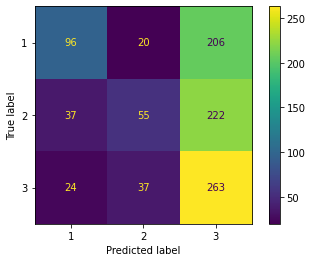

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


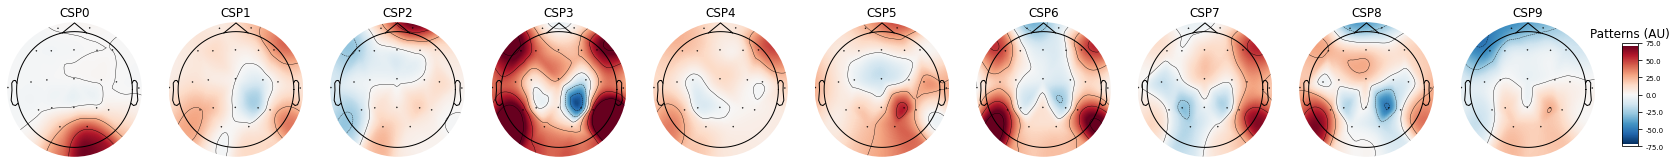




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.3233


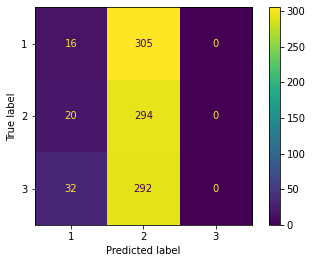

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


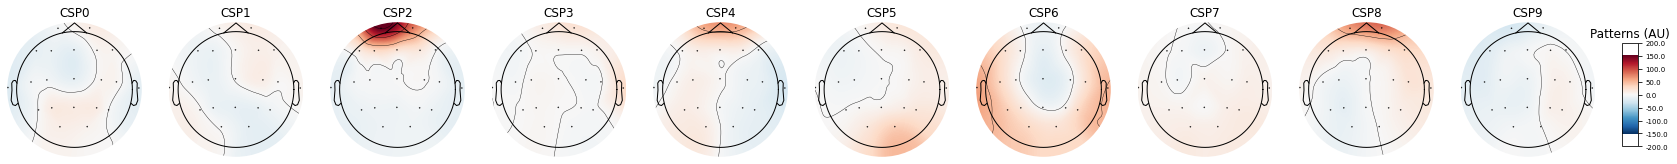




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.4901


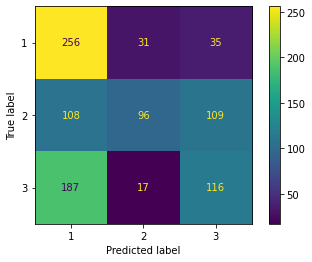

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


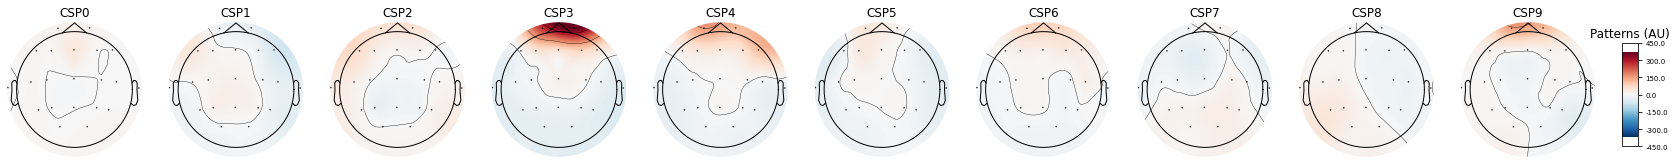

In [21]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_rf_depth = [3, None, 10]
best_found_rf_max_featues = [0.4, 0.2, 0.4]
best_found_rf_min_sample = [10, 2, 10]
best_found_rf_n_estimators = [500, 50, 250]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        # Get all training data (all but last session of participant)
        mne_raws = CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for all those MNE raws (all training sessions)
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    rf = RandomForestClassifier(bootstrap= True,
                                criterion= "gini",
                                max_depth= best_found_rf_depth[i],
                                max_features= best_found_rf_max_featues[i],
                                min_samples_split= best_found_rf_min_sample[i],
                                n_estimators= best_found_rf_n_estimators[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('RF', rf)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_rf_depth
del best_found_rf_max_featues
del best_found_rf_min_sample
del best_found_rf_n_estimators
del i
del X_test
del y_test
del X_train
del y_train
del csp
del rf
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound

<hr><hr>

## New subject

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
Perhaps the hardest task is training a classifier on data from one or more subjects, but using it to classify data from a completely new user.
This is the hardest task we'll discuss.
This section will train the same classifiers for the same participants as before but by using one participant for testing and the other two for training.

<hr>

### New subject: LDA classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> LDA
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [22]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                ###################### PREPARE DATA ######################
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 10,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001, 0.00001, 0.001, 0.0004, 0.00007]
                               },
                              {"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["lsqr" , "eigen"]
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/newsubject/subject{subject_id}/gridsearch_csplda.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del lda
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
                del train_subject
                del train_subjects
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject**      | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                   |
|------------------|------------------------------------------|------------------------------------|----------------------------------------------|
| B (Train on C&E) | 0.5662 +- 0.0129                         | 0.3961                             | 10 CSP components \| SVD LDA with 0.0001 tol |
| C (Train on B&E) | 0.4781 +- 0.0185                         | 0.4731                             | 10 CSP components \| lsqr LDA                |
| E (Train on B&C) | 0.5567 +- 0.0287                         | 0.4098                             | 10 CSP components \| SVD LDA with 0.0001 tol |

It becomes clear that CSP + LDA struggles with this task as the performance is comparable to random.

In [23]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/newsubject/subject{subject_id}/gridsearch_csplda.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {np.round(grid_search.best_score_, 4)} +- {np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4)} with the following parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.5662 +- 0.0129 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
24      16.677791      0.082748         0.008598        0.000916   
23      16.679991      0.071716         0.008298        0.001004   
22      16.687789      0.076678         0.010497        0.004030   
21      16.646401      0.066482         0.009497        0.001204   
20      16.675692      0.052500         0.009297        0.000640   
34      16.566027      0.203176         0.007698        0.000641   
33      16.743470      0.095126         0.007798        0.001248   
32      16.590419      0.063734         0.005798        0.000400   
31      16.604115      0.061809         0.005499        0.000500   
19      16.583921      0.076682         0.005898        0.000830   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
24                      10               svd        0.00007   
23                      10               svd         0.0004   
22                      10               svd          0.001   
21                      10               svd        0.00001   
20                      10               svd         0.0001   
34                      10             eigen            NaN   
33                      10              lsqr            NaN   
32                       6             eigen            NaN   
31                       6              lsqr            NaN   
19                       6               svd        0.00007   

    split0_test_score  split1_test_score  split2_test_score  ...  \
24           0.585069           0.572174           0.587826  ...   
23           0.585069           0.572174           0.587826  ...   
22           0.585069           0.572174           0.587826  ...   
21           0.585069           0.572174           0.587826  ...   
20           0.585069           0.572174           0.587826  ...   
34           0.585069           0.572174           0.587826  ...   
33           0.585069           0.572174           0.587826  ...   
32           0.574653           0.554783           0.563478  ...   
31           0.574653           0.554783           0.563478  ...   
19           0.574653           0.554783           0.565217  ...   

    split2_train_score  split3_train_score  split4_train_score  \
24            0.569359            0.574961            0.580371   
23            0.569359            0.574961            0.580371   
22            0.569359            0.574961            0.580371   
21            0.569359            0.574961            0.580371   
20            0.569359            0.574961            0.580371   
34            0.569552            0.574961            0.579791   
33            0.569552            0.574961            0.579791   
32            0.569745            0.556607            0.566847   
31            0.569745            0.556607            0.566847   
19            0.570131            0.556801            0.567233   

    split5_train_score  split6_train_score  split7_train_score  \
24            0.573609            0.583655            0.590611   
23            0.573609            0.583655            0.590611   
22            0.573609            0.583655            0.590611   
21            0.573609            0.583655            0.590611   
20            0.573609            0.583655            0.590611   
34            0.573223            0.583076            0.590611   
33            0.573223            0.583076            0.590611   
32            0.553903            0.559892            0.556028   
31            0.553903            0.559892            0.556028   
19            0.554289            0.559312            0.556221   

    split8_train_score  split9_train_score  mean_train_score  std_train_score  
24            0.574575            0.573802          0.577252         0.005774  
23            0.574575            0.573802          0.577252         0.005774  
22            0.574575            0.573802          0.577252         0.005774  
21            0.574575            0.57



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       16.551432      0.045822         0.004499        0.000500   
27      16.527439      0.050890         0.004199        0.000400   
28      16.506946      0.083724         0.004099        0.000300   
1       16.638651      0.077663         0.004499        0.000500   
2       16.578723      0.100582         0.004399        0.000490   
3       16.556730      0.085611         0.004199        0.000400   
4       16.607914      0.090965         0.004099        0.000300   
0       16.979295      0.465478         0.004399        0.000490   
25      16.515143      0.071153         0.003299        0.000458   
26      16.472157      0.054163         0.003199        0.000400   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
5                        3               svd         0.0001   
27                       3              lsqr            NaN   
28                       3             eigen            NaN   
1                        2               svd        0.00001   
2                        2               svd          0.001   
3                        2               svd         0.0004   
4                        2               svd        0.00007   
0                        2               svd         0.0001   
25                       2              lsqr            NaN   
26                       2             eigen            NaN   

    split0_test_score  split1_test_score  split2_test_score  ...  \
5            0.427083           0.436522           0.387826  ...   
27           0.427083           0.436522           0.387826  ...   
28           0.427083           0.436522           0.387826  ...   
1            0.388889           0.408696           0.351304  ...   
2            0.388889           0.408696           0.351304  ...   
3            0.388889           0.408696           0.351304  ...   
4            0.388889           0.408696           0.351304  ...   
0            0.388889           0.408696           0.351304  ...   
25           0.388889           0.406957           0.351304  ...   
26           0.388889           0.406957           0.351304  ...   

    split2_train_score  split3_train_score  split4_train_score  \
5             0.408617            0.410549            0.407844   
27            0.409003            0.410355            0.407844   
28            0.409003            0.410355            0.407844   
1             0.376932            0.380216            0.380603   
2             0.376932            0.380216            0.380603   
3             0.376932            0.380216            0.380603   
4             0.376932            0.380216            0.380603   
0             0.376932            0.380216            0.380603   
25            0.376739            0.380216            0.380410   
26            0.376739            0.380216            0.380410   

    split5_train_score  split6_train_score  split7_train_score  \
5             0.410355            0.423879            0.407651   
27            0.410162            0.423879            0.407651   
28            0.410162            0.423879            0.407651   
1             0.378478            0.382535            0.375386   
2             0.378478            0.382535            0.375386   
3             0.378478            0.382535            0.375386   
4             0.378478            0.382535            0.375386   
0             0.378478            0.382535            0.375386   
25            0.378284            0.382535            0.375580   
26            0.378284            0.382535            0.375580   

    split8_train_score  split9_train_score  mean_train_score  std_train_score  
5             0.407457            0.410162          0.412778         0.008450  
27            0.407264            0.410162          0.412759         0.008394  
28            0.407264            0.410162          0.412759         0.008394  
1             0.371522            0.38



In total there are 35 different configurations tested.
The best mean test score is 0.5662
There are 5 configurations with this maximum score
There are 14 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       14.000000     14.000000        14.000000       14.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean        16.625108      0.077831         0.007484        0.001096   
std          0.060383      0.039091         0.001577        0.000890   
min         16.541734      0.043497         0.005499        0.000400   
25%         16.580997      0.057642         0.006073        0.000640   
50%         16.611212      0.069099         0.007298        0.000908   
75%         16.677266      0.081231         0.008523        0.001178   
max         16.743470      0.203176         0.010497        0.004030   

        param_CSP__n_components param_LDA__solver  param_LDA__tol  \
count                      14.0                14        10.00000   
unique                      2.0                 3         5.00000   
top                        10.0               svd         0.00007   
freq                        7.0                10         2.00000   
mean                        NaN               NaN             NaN   
std                         NaN               NaN             NaN   
min                         NaN               NaN             NaN   
25%                         NaN               NaN             NaN   
50%                         NaN               NaN             NaN   
75%                         NaN               NaN             NaN   
max                         NaN               NaN             NaN   

        split0_test_score  split1_test_score  split2_test_score  ...  \
count           14.000000          14.000000          14.000000  ...   
unique                NaN                NaN                NaN  ...   
top                   NaN                NaN                NaN  ...   
freq                  NaN                NaN                NaN  ...   
mean             0.579861           0.563478           0.576273  ...   
std              0.005405           0.009024           0.012003  ...   
min              0.574653           0.554783           0.563478  ...   
25%              0.574653           0.554783           0.565217  ...   
50%              0.579861           0.563478           0.576522  ...   
75%              0.585069           0.572174           0.587826  ...   
max              0.585069           0.572174           0.587826  ...   

        split2_train_score  split3_train_score  split4_train_score  \
count            14.000000           14.000000           14.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.569717            0.565853            0.573664   
std               0.000346            0.009452            0.006792   
min               0.569359            0.556607            0.566847   
25%               0.569359            0.556801            0.567233   
50%               0.569648            0.565881            0.573512   
75%               0.570131            0.574961            0.580371   
max               0.570131            0.574961            0.580371   

        split5_train_score  split6_train_score  split7_train_score  \
count            14.000000           14.000000           14.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.563839            0.571484            0.573388   
std               0.010026            0.012462            0.017873   
min               0.553903            0.559312            0.556028   
25%               0.554289            0.559312  




####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.4781 +- 0.0185 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'lsqr'}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
34      16.637804      0.222320         0.010898        0.004865   
33      16.747369      0.125512         0.008198        0.000979   
24      16.769962      0.142414         0.008398        0.000663   
23      16.820446      0.161290         0.008798        0.001249   
22      16.834341      0.155076         0.009197        0.000871   
21      16.754367      0.151045         0.008598        0.000663   
20      16.770862      0.154908         0.009497        0.001025   
32      16.703383      0.082764         0.005499        0.000500   
31      16.759965      0.146001         0.005899        0.000830   
19      16.657498      0.118762         0.005799        0.000400   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
34                      10             eigen            NaN   
33                      10              lsqr            NaN   
24                      10               svd        0.00007   
23                      10               svd         0.0004   
22                      10               svd          0.001   
21                      10               svd        0.00001   
20                      10               svd         0.0001   
32                       6             eigen            NaN   
31                       6              lsqr            NaN   
19                       6               svd        0.00007   

    split0_test_score  split1_test_score  split2_test_score  ...  \
34           0.471304           0.469565           0.471304  ...   
33           0.471304           0.469565           0.471304  ...   
24           0.473043           0.469565           0.471304  ...   
23           0.473043           0.469565           0.471304  ...   
22           0.473043           0.469565           0.471304  ...   
21           0.473043           0.469565           0.471304  ...   
20           0.473043           0.469565           0.471304  ...   
32           0.452174           0.427826           0.412174  ...   
31           0.452174           0.427826           0.412174  ...   
19           0.450435           0.427826           0.413913  ...   

    split2_train_score  split3_train_score  split4_train_score  \
34            0.493913            0.488116            0.490048   
33            0.493913            0.488116            0.490048   
24            0.494106            0.488116            0.489855   
23            0.494106            0.488116            0.489855   
22            0.494106            0.488116            0.489855   
21            0.494106            0.488116            0.489855   
20            0.494106            0.488116            0.489855   
32            0.457778            0.456039            0.457198   
31            0.457778            0.456039            0.457198   
19            0.457585            0.455845            0.457198   

    split5_train_score  split6_train_score  split7_train_score  \
34            0.490242            0.495459            0.500290   
33            0.490242            0.495459            0.500290   
24            0.489855            0.495266            0.500483   
23            0.489855            0.495266            0.500483   
22            0.489855            0.495266            0.500483   
21            0.489855            0.495266            0.500483   
20            0.489855            0.495266            0.500483   
32            0.445217            0.447150            0.446377   
31            0.445217            0.447150            0.446377   
19            0.444831            0.447150            0.446763   

    split8_train_score  split9_train_score  mean_train_score  std_train_score  
34            0.491208            0.483478          0.492657         0.005253  
33            0.491208            0.483478          0.492657         0.005253  
24            0.491014            0.483478          0.492599         0.005310  
23            0.491014            0.48



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
27      16.665595      0.175537         0.004299        0.000458   
28      16.651799      0.129599         0.004199        0.000400   
5       16.605414      0.171615         0.004299        0.000458   
25      16.640303      0.148570         0.003799        0.000600   
26      16.624708      0.135586         0.003200        0.000400   
1       16.639603      0.168400         0.003900        0.000538   
3       16.574024      0.168459         0.003699        0.000640   
4       16.561728      0.165540         0.004099        0.000300   
2       16.584820      0.147368         0.003999        0.000447   
0       16.605814      0.187090         0.004599        0.000800   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
27                       3              lsqr            NaN   
28                       3             eigen            NaN   
5                        3               svd         0.0001   
25                       2              lsqr            NaN   
26                       2             eigen            NaN   
1                        2               svd        0.00001   
3                        2               svd         0.0004   
4                        2               svd        0.00007   
2                        2               svd          0.001   
0                        2               svd         0.0001   

    split0_test_score  split1_test_score  split2_test_score  ...  \
27           0.415652           0.358261           0.354783  ...   
28           0.415652           0.358261           0.354783  ...   
5            0.415652           0.358261           0.354783  ...   
25           0.379130           0.330435           0.347826  ...   
26           0.379130           0.330435           0.347826  ...   
1            0.379130           0.328696           0.347826  ...   
3            0.379130           0.328696           0.347826  ...   
4            0.379130           0.328696           0.347826  ...   
2            0.379130           0.328696           0.347826  ...   
0            0.379130           0.328696           0.347826  ...   

    split2_train_score  split3_train_score  split4_train_score  \
27            0.393816            0.378744            0.417971   
28            0.393816            0.378744            0.417971   
5             0.393623            0.378744            0.418164   
25            0.378937            0.374300            0.413720   
26            0.378937            0.374300            0.413720   
1             0.378937            0.374300            0.413913   
3             0.378937            0.374300            0.413913   
4             0.378937            0.374300            0.413913   
2             0.378937            0.374300            0.413913   
0             0.378937            0.374300            0.413913   

    split5_train_score  split6_train_score  split7_train_score  \
27            0.386087            0.401932            0.387246   
28            0.386087            0.401932            0.387246   
5             0.386280            0.402319            0.387246   
25            0.371594            0.374493            0.371981   
26            0.371594            0.374493            0.371981   
1             0.371594            0.374493            0.371981   
3             0.371594            0.374493            0.371981   
4             0.371594            0.374493            0.371981   
2             0.371594            0.374493            0.371981   
0             0.371594            0.374493            0.371981   

    split8_train_score  split9_train_score  mean_train_score  std_train_score  
27            0.387053            0.384348          0.393681         0.012063  
28            0.387053            0.384348          0.393681         0.012063  
5             0.387053            0.384348          0.393720         0.012089  
25            0.372560            0.37



In total there are 35 different configurations tested.
The best mean test score is 0.4781
There are 2 configurations with this maximum score
There are 7 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count        7.000000      7.000000         7.000000        7.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean        16.762164      0.158938         0.009083        0.001474   
std          0.063885      0.030295         0.000917        0.001510   
min         16.637804      0.125512         0.008198        0.000663   
25%         16.750868      0.146729         0.008498        0.000767   
50%         16.769962      0.154908         0.008798        0.000979   
75%         16.795654      0.158183         0.009347        0.001137   
max         16.834341      0.222320         0.010898        0.004865   

        param_CSP__n_components param_LDA__solver  param_LDA__tol  \
count                       7.0                 7         5.00000   
unique                      1.0                 3         5.00000   
top                        10.0               svd         0.00007   
freq                        7.0                 5         1.00000   
mean                        NaN               NaN             NaN   
std                         NaN               NaN             NaN   
min                         NaN               NaN             NaN   
25%                         NaN               NaN             NaN   
50%                         NaN               NaN             NaN   
75%                         NaN               NaN             NaN   
max                         NaN               NaN             NaN   

        split0_test_score  split1_test_score  split2_test_score  ...  \
count            7.000000           7.000000           7.000000  ...   
unique                NaN                NaN                NaN  ...   
top                   NaN                NaN                NaN  ...   
freq                  NaN                NaN                NaN  ...   
mean             0.472547           0.469565           0.471304  ...   
std              0.000849           0.000000           0.000000  ...   
min              0.471304           0.469565           0.471304  ...   
25%              0.472174           0.469565           0.471304  ...   
50%              0.473043           0.469565           0.471304  ...   
75%              0.473043           0.469565           0.471304  ...   
max              0.473043           0.469565           0.471304  ...   

        split2_train_score  split3_train_score  split4_train_score  \
count             7.000000            7.000000            7.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.494051            0.488116            0.489910   
std               0.000094            0.000000            0.000094   
min               0.493913            0.488116            0.489855   
25%               0.494010            0.488116            0.489855   
50%               0.494106            0.488116            0.489855   
75%               0.494106            0.488116            0.489952   
max               0.494106            0.488116            0.490048   

        split5_train_score  split6_train_score  split7_train_score  \
count             7.000000            7.000000            7.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.489965            0.495321            0.500428   
std               0.000189            0.000094            0.000094   
min               0.489855            0.495266            0.500290   
25%               0.489855            0.495266  




####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.5567 +- 0.0287 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
34      16.456062      0.292352         0.008201        0.000749   
24      16.736373      0.082024         0.008798        0.001400   
23      16.748569      0.043629         0.008797        0.001166   
22      16.798453      0.076071         0.008897        0.000943   
21      16.773561      0.056015         0.009198        0.001248   
20      16.751068      0.072718         0.009197        0.000600   
33      16.653899      0.053267         0.007998        0.001000   
32      16.607613      0.055564         0.005998        0.001414   
31      16.621209      0.053444         0.005699        0.000900   
19      16.687588      0.088495         0.005699        0.000458   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
34                      10             eigen            NaN   
24                      10               svd        0.00007   
23                      10               svd         0.0004   
22                      10               svd          0.001   
21                      10               svd        0.00001   
20                      10               svd         0.0001   
33                      10              lsqr            NaN   
32                       6             eigen            NaN   
31                       6              lsqr            NaN   
19                       6               svd        0.00007   

    split0_test_score  split1_test_score  split2_test_score  ...  \
34           0.548611           0.536458           0.630208  ...   
24           0.548611           0.536458           0.628472  ...   
23           0.548611           0.536458           0.628472  ...   
22           0.548611           0.536458           0.628472  ...   
21           0.548611           0.536458           0.628472  ...   
20           0.548611           0.536458           0.628472  ...   
33           0.548611           0.536458           0.630208  ...   
32           0.527778           0.527778           0.616319  ...   
31           0.527778           0.527778           0.616319  ...   
19           0.526042           0.526042           0.614583  ...   

    split2_train_score  split3_train_score  split4_train_score  \
34            0.574213            0.561089            0.593901   
24            0.574599            0.560896            0.593322   
23            0.574599            0.560896            0.593322   
22            0.574599            0.560896            0.593322   
21            0.574599            0.560896            0.593322   
20            0.574599            0.560896            0.593322   
33            0.574213            0.561089            0.593901   
32            0.567072            0.556842            0.577495   
31            0.567072            0.556842            0.577495   
19            0.567072            0.556842            0.577688   

    split5_train_score  split6_train_score  split7_train_score  \
34            0.567072            0.578074            0.550174   
24            0.567265            0.577881            0.550560   
23            0.567265            0.577881            0.550560   
22            0.567265            0.577881            0.550560   
21            0.567265            0.577881            0.550560   
20            0.567265            0.577881            0.550560   
33            0.567072            0.578074            0.550174   
32            0.566493            0.557421            0.539367   
31            0.566493            0.557421            0.539367   
19            0.565914            0.557614            0.539560   

    split8_train_score  split9_train_score  mean_train_score  std_train_score  
34            0.572366            0.567156          0.570591         0.010733  
24            0.573138            0.566770          0.570707         0.010584  
23            0.573138            0.566770          0.570707         0.010584  
22            0.573138            0.56



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       16.534537      0.047167         0.005599    4.150633e-03   
27      16.577423      0.064266         0.003999    2.870940e-07   
28      16.528239      0.056888         0.004499    6.705054e-04   
1       16.536736      0.046586         0.004299    6.400465e-04   
2       16.527839      0.069564         0.004499    4.997493e-04   
3       16.485752      0.073741         0.003999    1.668930e-07   
4       16.526539      0.066298         0.004199    5.998136e-04   
0       16.487652      0.064448         0.004299    6.401285e-04   
25      16.569626      0.062833         0.003499    4.996778e-04   
26      16.523840      0.050800         0.003599    4.895805e-04   

   param_CSP__n_components param_LDA__solver param_LDA__tol  \
5                        3               svd         0.0001   
27                       3              lsqr            NaN   
28                       3             eigen            NaN   
1                        2               svd        0.00001   
2                        2               svd          0.001   
3                        2               svd         0.0004   
4                        2               svd        0.00007   
0                        2               svd         0.0001   
25                       2              lsqr            NaN   
26                       2             eigen            NaN   

    split0_test_score  split1_test_score  split2_test_score  ...  \
5            0.371528           0.373264           0.420139  ...   
27           0.371528           0.373264           0.420139  ...   
28           0.371528           0.373264           0.420139  ...   
1            0.378472           0.369792           0.423611  ...   
2            0.378472           0.369792           0.423611  ...   
3            0.378472           0.369792           0.423611  ...   
4            0.378472           0.369792           0.423611  ...   
0            0.378472           0.369792           0.423611  ...   
25           0.378472           0.369792           0.423611  ...   
26           0.378472           0.369792           0.423611  ...   

    split2_train_score  split3_train_score  split4_train_score  \
5             0.394132            0.401081            0.471531   
27            0.393553            0.400888            0.471531   
28            0.393553            0.400888            0.471531   
1             0.395870            0.401274            0.346651   
2             0.395870            0.401274            0.346651   
3             0.395870            0.401274            0.346651   
4             0.395870            0.401274            0.346651   
0             0.395870            0.401274            0.346651   
25            0.395870            0.401274            0.346844   
26            0.395870            0.401274            0.346844   

    split5_train_score  split6_train_score  split7_train_score  \
5             0.394518            0.397414            0.429371   
27            0.394711            0.397414            0.429564   
28            0.394711            0.397414            0.429564   
1             0.399151            0.396256            0.394635   
2             0.399151            0.396256            0.394635   
3             0.399151            0.396256            0.394635   
4             0.399151            0.396256            0.394635   
0             0.399151            0.396256            0.394635   
25            0.399151            0.396449            0.394635   
26            0.399151            0.396449            0.394635   

    split8_train_score  split9_train_score  mean_train_score  std_train_score  
5             0.396758            0.401196          0.408083         0.023325  
27            0.396758            0.401775          0.408102         0.023361  
28            0.396758            0.401775          0.408102         0.023361  
1             0.397144            0.40



In total there are 35 different configurations tested.
The best mean test score is 0.5567
There are 7 configurations with this maximum score
There are 14 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       14.000000     14.000000        14.000000       14.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean        16.669223      0.076323         0.007291        0.000888   
std          0.089422      0.064186         0.001525        0.000328   
min         16.456062      0.027953         0.005699        0.000447   
25%         16.622184      0.053311         0.005898        0.000625   
50%         16.658497      0.057935         0.006998        0.000885   
75%         16.745520      0.075233         0.008798        0.001124   
max         16.798453      0.292352         0.009198        0.001414   

        param_CSP__n_components param_LDA__solver  param_LDA__tol  \
count                      14.0                14        10.00000   
unique                      2.0                 3         5.00000   
top                        10.0               svd         0.00007   
freq                        7.0                10         2.00000   
mean                        NaN               NaN             NaN   
std                         NaN               NaN             NaN   
min                         NaN               NaN             NaN   
25%                         NaN               NaN             NaN   
50%                         NaN               NaN             NaN   
75%                         NaN               NaN             NaN   
max                         NaN               NaN             NaN   

        split0_test_score  split1_test_score  split2_test_score  ...  \
count           14.000000          14.000000          14.000000  ...   
unique                NaN                NaN                NaN  ...   
top                   NaN                NaN                NaN  ...   
freq                  NaN                NaN                NaN  ...   
mean             0.537574           0.531498           0.622024  ...   
std              0.011468           0.005180           0.007252  ...   
min              0.526042           0.526042           0.614583  ...   
25%              0.526042           0.526042           0.614583  ...   
50%              0.538194           0.532118           0.622396  ...   
75%              0.548611           0.536458           0.628472  ...   
max              0.548611           0.536458           0.630208  ...   

        split2_train_score  split3_train_score  split4_train_score  \
count            14.000000           14.000000           14.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.570781            0.558897            0.585560   
std               0.003851            0.002133            0.008229   
min               0.567072            0.556842            0.577495   
25%               0.567072            0.556842            0.577688   
50%               0.570643            0.558869            0.585505   
75%               0.574599            0.560896            0.593322   
max               0.574599            0.561089            0.593901   

        split5_train_score  split6_train_score  split7_train_score  \
count            14.000000           14.000000           14.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.566645            0.567748            0.544977   
std               0.000621            0.010573            0.005681   
min               0.565914            0.557421            0.539367   
25%               0.565914            0.557614  




####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.3961


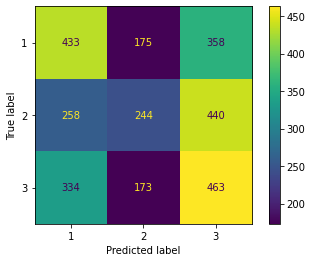

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


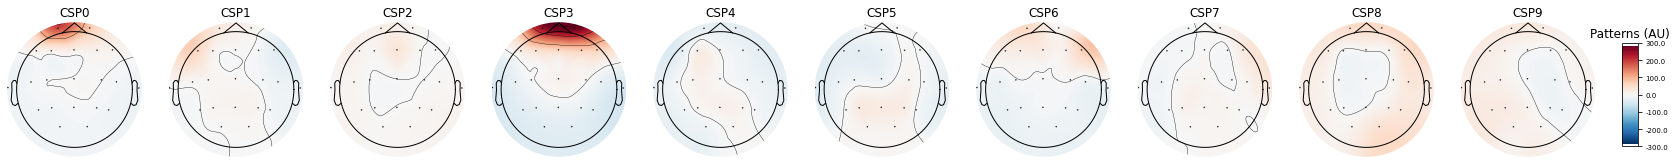




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.4731


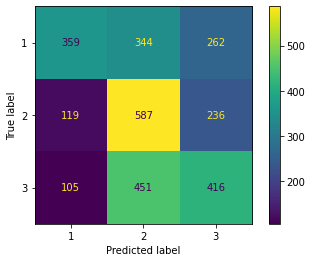

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


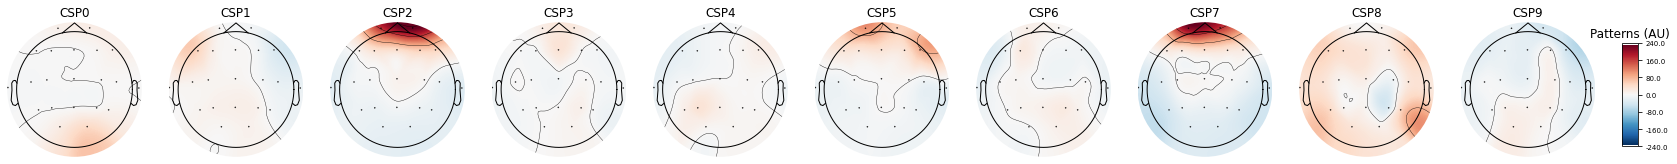




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.4098


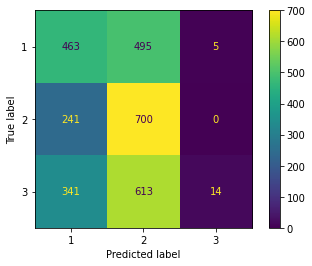

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


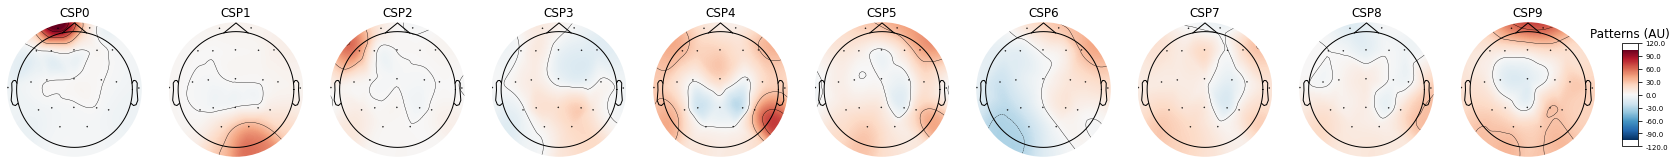

In [24]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_solver = ["svd", "lsqr", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_ids_to_test[i])
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raws = CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine test data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        del mne_raws
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del i
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del train_subjects
del train_subject
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound

<hr>

### New subject: SVM classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For SVM:
            - The C: 0.01 | 0.1 | 1 | 10 | 100
            - The kernel: rbf | sigmoid | linear
            - When using the rbf of sigmoid kernel, the gamma: scale | auto | 10 | 1 | 0.1 | 0.01 | 0.001
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [25]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                ###################### PREPARE DATA ######################
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                svm = SVC()
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 6,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limited computational resources
                param_grid = [{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['rbf', 'sigmoid'],
                        "SVM__gamma":['scale', 'auto', 10, 1, 0.1, 0.01, 0.001]}
                              ,{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['linear']}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/newsubject/subject{subject_id}/gridsearch_cspsvm.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del svm
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
                del train_subject
                del train_subjects
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject**      | **CSP + SVM: cross validation accuracy** | **CSP + SVM: test split accuracy** | **Config**                                             |
|------------------|------------------------------------------|------------------------------------|--------------------------------------------------------|
| B (Train on C&E) | 0.6039 +- 0.0104                         | 0.3857                             | 10 CSP components \| RBF SVM with C 10 and gamma auto  |
| C (Train on B&E) | 0.5169 +- 0.0163                         | 0.4411                             | 10 CSP components \| RBF SVM with C 10 and gamma scale |
| E (Train on B&C) | 0.5736 +- 0.022                          | 0.3381                             | 10 CSP components \| RBF SVM with C 1 and gamma scale  |

It becomes clear that CSP + SVM struggles with this task as the performance is comparable to random.

In [26]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/newsubject/subject{subject_id}/gridsearch_cspsvm.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {np.round(grid_search.best_score_, 4)} +- {np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4)} with the following parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.6039 +- 0.0104 with the following parameters
{'CSP__n_components': 10, 'SVM__C': 10, 'SVM__gamma': 'auto', 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
184      16.451597      0.090835         0.374546        0.014835   
190      16.485419      0.051434         0.375546        0.015569   
168      16.353461      0.043179         0.395707        0.007816   
182      16.514910      0.029591         0.388042        0.017067   
170      16.403778      0.128070         0.412868        0.025998   
176      16.313141      0.057664         0.402705        0.013845   
206      16.698351      0.063053         0.399873        0.019081   
174      16.660364      0.056064         0.450189        0.010173   
192      16.346963      0.070117         0.406704        0.016742   
198      18.301841      0.081918         0.373048        0.014353   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
184                      10           10             auto               rbf   
190                      10           10              0.1               rbf   
168                      10            1            scale               rbf   
182                      10           10            scale               rbf   
170                      10            1             auto               rbf   
176                      10            1              0.1               rbf   
206                      10          100             0.01               rbf   
174                      10            1                1               rbf   
192                      10           10             0.01               rbf   
198                      10          100             auto               rbf   

     split0_test_score  split1_test_score  ...  std_test_score  \
184           0.617310           0.589155  ...        0.010392   
190           0.617310           0.589155  ...        0.010392   
168           0.608968           0.602711  ...        0.008346   
182           0.613139           0.593326  ...        0.010156   
170           0.613139           0.596455  ...        0.010376   
176           0.613139           0.596455  ...        0.010376   
206           0.615224           0.594369  ...        0.010573   
174           0.597497           0.581856  ...        0.007144   
192           0.610010           0.591241  ...        0.012555   
198           0.606882           0.574557  ...        0.012607   

     rank_test_score  split0_train_score  split1_train_score  \
184                1            0.666736            0.683431   
190                1            0.666736            0.683431   
168                3            0.629382            0.655676   
182                4            0.675501            0.696786   
170                5            0.627295            0.646912   
176                5            0.627295            0.646912   
206                7            0.620409            0.636477   
174                8            0.836185            0.844115   
192                9            0.606845            0.617487   
198               10            0.732888            0.748539   

     split2_train_score  split3_train_score  split4_train_score  \
184            0.686144            0.677864            0.686209   
190            0.686144            0.677864            0.686209   
168            0.648790            0.637596            0.649906   
182            0.691152            0.685792            0.693511   
170            0.646285            0.632172            0.647194   
176            0.646285            0.632172            0.647194   
206            0.628339            0.616941            0.630503   
174            0.868114            0.849364            0.856040   
192            0.618322            0.600668            0.614646   
198            0.761686            0.750887            0.760901   

     split5_train_score  mean_train_score  std_train_score  
184            0.687670          0.681342         0.007264  
190            0.687670          0.681342         0.007264  
168            0.64051



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
13       16.291980      0.058926         0.137456        0.001607   
12       16.322637      0.062793         0.448357        0.009048   
11       16.253992      0.034661         0.144787        0.007054   
153      16.645035      0.076743         0.174444        0.004855   
10       16.272153      0.087136         0.441359        0.010591   
81       17.670208      1.205181         0.164448        0.023107   
26       16.290480      0.037784         0.441526        0.007801   
151      16.676191      0.081275         0.172279        0.005989   
97       16.509911      0.074819         0.148286        0.002867   
167      16.646867      0.037326         0.170612        0.003542   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
13                        4         0.01            0.001           sigmoid   
12                        4         0.01            0.001               rbf   
11                        4         0.01             0.01           sigmoid   
153                      10         0.01            0.001           sigmoid   
10                        4         0.01             0.01               rbf   
81                        6         0.01             0.01           sigmoid   
26                        4          0.1            0.001               rbf   
151                      10         0.01             0.01           sigmoid   
97                        6          0.1            0.001           sigmoid   
167                      10          0.1            0.001           sigmoid   

     split0_test_score  split1_test_score  ...  std_test_score  \
13            0.336809           0.337852  ...        0.000388   
12            0.336809           0.337852  ...        0.000388   
11            0.336809           0.337852  ...        0.000388   
153           0.336809           0.337852  ...        0.000388   
10            0.336809           0.337852  ...        0.000388   
81            0.336809           0.336809  ...        0.000348   
26            0.336809           0.336809  ...        0.000348   
151           0.336809           0.336809  ...        0.000348   
97            0.336809           0.336809  ...        0.000348   
167           0.336809           0.336809  ...        0.000348   

     rank_test_score  split0_train_score  split1_train_score  \
13               204            0.337437            0.337229   
12               204            0.337437            0.337229   
11               204            0.337437            0.337229   
153              204            0.337437            0.337229   
10               204            0.337437            0.337229   
81               221            0.337437            0.337229   
26               221            0.337437            0.337646   
151              221            0.337437            0.337229   
97               221            0.337437            0.337229   
167              221            0.337437            0.337229   

     split2_train_score  split3_train_score  split4_train_score  \
13             0.337229            0.337367            0.337367   
12             0.337229            0.337367            0.337367   
11             0.337229            0.337367            0.337367   
153            0.337229            0.337367            0.337367   
10             0.337229            0.337367            0.337367   
81             0.337229            0.337367            0.337367   
26             0.337437            0.337993            0.337576   
151            0.337229            0.337367            0.337367   
97             0.337229            0.337367            0.337367   
167            0.337229            0.337367            0.337367   

     split5_train_score  mean_train_score  std_train_score  
13             0.337367          0.337333         0.000078  
12             0.337367          0.337333         0.000078  
11             0.33736



In total there are 225 different configurations tested.
The best mean test score is 0.6039
There are 2 configurations with this maximum score
There are 13 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       13.000000     13.000000        13.000000       13.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean        16.754487      0.067633         0.406127        0.015502   
std          0.668553      0.024613         0.036576        0.004522   
min         16.313141      0.029591         0.360884        0.007816   
25%         16.403778      0.056064         0.375546        0.013845   
50%         16.495082      0.063053         0.399873        0.014835   
75%         16.660364      0.081918         0.412868        0.017067   
max         18.301841      0.128070         0.484012        0.025998   

        param_CSP__n_components  param_SVM__C param_SVM__gamma  \
count                      13.0          13.0               13   
unique                      1.0           4.0                5   
top                        10.0          10.0             auto   
freq                       13.0           4.0                3   
mean                        NaN           NaN              NaN   
std                         NaN           NaN              NaN   
min                         NaN           NaN              NaN   
25%                         NaN           NaN              NaN   
50%                         NaN           NaN              NaN   
75%                         NaN           NaN              NaN   
max                         NaN           NaN              NaN   

       param_SVM__kernel  split0_test_score  split1_test_score  ...  \
count                 13          13.000000          13.000000  ...   
unique                 1                NaN                NaN  ...   
top                  rbf                NaN                NaN  ...   
freq                  13                NaN                NaN  ...   
mean                 NaN           0.607764           0.590599  ...   
std                  NaN           0.009622           0.010450  ...   
min                  NaN           0.583942           0.574557  ...   
25%                  NaN           0.606882           0.582899  ...   
50%                  NaN           0.610010           0.591241  ...   
75%                  NaN           0.613139           0.596455  ...   
max                  NaN           0.617310           0.611053  ...   

        std_test_score  rank_test_score  split0_train_score  \
count        13.000000        13.000000           13.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean          0.010707         6.769231            0.668534   
std           0.001700         3.961352            0.065957   
min           0.007144         1.000000            0.599958   
25%           0.010376         4.000000            0.627295   
50%           0.010392         7.000000            0.666736   
75%           0.012555        10.000000            0.675501   
max           0.012955        13.000000            0.836185   

        split1_train_score  split2_train_score  split3_train_score  \
count            13.000000           13.000000           13.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.685742            0.687251            0.676146   
std               0.064432            0.072283            0.071606   
min               0.610810            0.611227            0.600668   
25%               0.646912            0.646285            0.632172   
50%               0.683431            0.680092            0.677029   
75%               0.696786            0.




####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.5169 +- 0.0163 with the following parameters
{'CSP__n_components': 10, 'SVM__C': 10, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
190      16.936109      0.076218         0.419033        0.004877   
182      16.872962      0.076008         0.422532        0.010124   
184      16.834975      0.075462         0.417367        0.004030   
198      18.848334      0.078706         0.411035        0.008893   
204      18.860830      0.094275         0.419366        0.017646   
168      16.596883      0.087531         0.440693        0.008930   
170      16.632706      0.083044         0.432529        0.006444   
176      16.608713      0.116959         0.430862        0.006026   
196      18.998786      0.067396         0.415034        0.008150   
174      16.931444      0.080158         0.464685        0.006742   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
190                      10           10              0.1               rbf   
182                      10           10            scale               rbf   
184                      10           10             auto               rbf   
198                      10          100             auto               rbf   
204                      10          100              0.1               rbf   
168                      10            1            scale               rbf   
170                      10            1             auto               rbf   
176                      10            1              0.1               rbf   
196                      10          100            scale               rbf   
174                      10            1                1               rbf   

     split0_test_score  split1_test_score  ...  std_test_score  \
190           0.526590           0.488008  ...        0.018261   
182           0.524505           0.490094  ...        0.016274   
184           0.526590           0.488008  ...        0.018261   
198           0.527633           0.480709  ...        0.017867   
204           0.527633           0.480709  ...        0.017867   
168           0.518248           0.490094  ...        0.014571   
170           0.514077           0.495308  ...        0.011957   
176           0.514077           0.495308  ...        0.011957   
196           0.520334           0.486966  ...        0.015700   
174           0.524505           0.479666  ...        0.017687   

     rank_test_score  split0_train_score  split1_train_score  \
190                1            0.623043            0.625339   
182                1            0.629931            0.641411   
184                1            0.623043            0.625339   
198                4            0.705907            0.700689   
204                4            0.705907            0.700689   
168                4            0.573575            0.575037   
170                7            0.570027            0.562722   
176                7            0.570027            0.562722   
196                9            0.717595            0.728867   
174               10            0.822793            0.815905   

     split2_train_score  split3_train_score  split4_train_score  \
190            0.603715            0.611853            0.613105   
182            0.616444            0.621452            0.626669   
184            0.603715            0.611853            0.613105   
198            0.690526            0.691569            0.694699   
204            0.690526            0.691569            0.694699   
168            0.564065            0.565735            0.564065   
170            0.555718            0.557596            0.560100   
176            0.555718            0.557596            0.560100   
196            0.709725            0.713481            0.719533   
174            0.813230            0.805718            0.821995   

     split5_train_score  mean_train_score  std_train_score  
190            0.619366          0.616070         0.007356  
182            0.638147          0.629009         0.008743  
184            0.61936



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
146      16.916615      0.059122         0.493509        0.009283   
144      17.076564      0.078158         0.484512        0.004383   
13       16.472923      0.085952         0.140122        0.006412   
80       16.621209      0.106626         0.455022        0.009937   
74       16.854301      0.109889         0.452689        0.007709   
19       16.125033      0.093953         0.138456        0.013909   
33       16.080714      0.118058         0.138122        0.018688   
61       16.107872      0.076417         0.135123        0.016602   
47       16.040227      0.089166         0.138122        0.015044   
5        16.775160      0.077913         0.173944        0.007914   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
146                      10         0.01                1               rbf   
144                      10         0.01               10               rbf   
13                        4         0.01            0.001           sigmoid   
80                        6         0.01             0.01               rbf   
74                        6         0.01               10               rbf   
19                        4          0.1               10           sigmoid   
33                        4            1               10           sigmoid   
61                        4          100               10           sigmoid   
47                        4           10               10           sigmoid   
5                         4         0.01               10           sigmoid   

     split0_test_score  split1_test_score  ...  std_test_score  \
146           0.336809           0.336809  ...        0.000166   
144           0.336809           0.336809  ...        0.000166   
13            0.336809           0.336809  ...        0.000166   
80            0.336809           0.336809  ...        0.000166   
74            0.336809           0.336809  ...        0.000166   
19            0.351408           0.336809  ...        0.010198   
33            0.350365           0.333681  ...        0.008590   
61            0.346194           0.333681  ...        0.006708   
47            0.346194           0.333681  ...        0.006765   
5             0.326382           0.314911  ...        0.011604   

     rank_test_score  split0_train_score  split1_train_score  \
146              197            0.337090            0.337090   
144              197            0.337090            0.337090   
13               197            0.337090            0.337090   
80               197            0.337090            0.337090   
74               197            0.337090            0.337090   
19               221            0.349614            0.337090   
33               222            0.348570            0.337925   
61               223            0.347944            0.336255   
47               224            0.347944            0.336255   
5                225            0.330620            0.321645   

     split2_train_score  split3_train_score  split4_train_score  \
146            0.337020            0.337020            0.337020   
144            0.337020            0.337020            0.337020   
13             0.337020            0.337020            0.337020   
80             0.337020            0.337020            0.337020   
74             0.337020            0.337020            0.337020   
19             0.342237            0.317613            0.322830   
33             0.343072            0.316361            0.326795   
61             0.340776            0.317404            0.327421   
47             0.340985            0.317404            0.327003   
5              0.356010            0.308431            0.328673   

     split5_train_score  mean_train_score  std_train_score  
146            0.337020          0.337043         0.000033  
144            0.337020          0.337043         0.000033  
13             0.33702



In total there are 225 different configurations tested.
The best mean test score is 0.5169
There are 3 configurations with this maximum score
There are 12 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       12.000000     12.000000        12.000000       12.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean        17.335357      0.086649         0.432334        0.008184   
std          0.956418      0.014418         0.022336        0.003484   
min         16.596883      0.067396         0.411035        0.004030   
25%         16.779658      0.076165         0.418616        0.006340   
50%         16.902203      0.081601         0.425448        0.007767   
75%         17.517507      0.096082         0.434570        0.008936   
max         18.998786      0.116959         0.486512        0.017646   

        param_CSP__n_components  param_SVM__C  param_SVM__gamma  \
count                      12.0          12.0              12.0   
unique                      1.0           4.0               5.0   
top                        10.0         100.0               0.1   
freq                       12.0           4.0               3.0   
mean                        NaN           NaN               NaN   
std                         NaN           NaN               NaN   
min                         NaN           NaN               NaN   
25%                         NaN           NaN               NaN   
50%                         NaN           NaN               NaN   
75%                         NaN           NaN               NaN   
max                         NaN           NaN               NaN   

       param_SVM__kernel  split0_test_score  split1_test_score  ...  \
count                 12          12.000000          12.000000  ...   
unique                 1                NaN                NaN  ...   
top                  rbf                NaN                NaN  ...   
freq                  12                NaN                NaN  ...   
mean                 NaN           0.519639           0.489225  ...   
std                  NaN           0.008683           0.006986  ...   
min                  NaN           0.498436           0.479666  ...   
25%                  NaN           0.514077           0.485401  ...   
50%                  NaN           0.522419           0.489051  ...   
75%                  NaN           0.526590           0.492961  ...   
max                  NaN           0.527633           0.503650  ...   

        std_test_score  rank_test_score  split0_train_score  \
count        12.000000        12.000000           12.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean          0.014755         5.916667            0.643777   
std           0.003825         3.987670            0.080467   
min           0.006470         1.000000            0.548528   
25%           0.011957         3.250000            0.572688   
50%           0.015987         5.500000            0.626487   
75%           0.017867         9.250000            0.705907   
max           0.018261        12.000000            0.822793   

        split1_train_score  split2_train_score  split3_train_score  \
count            12.000000           12.000000           12.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.646264            0.631852            0.634738   
std               0.080388            0.080907            0.078588   
min               0.550198            0.541736            0.544866   
25%               0.571958            0.561978            0.563700   
50%               0.633375            0.610079            0.616653   
75%               0.700689  




####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.5736 +- 0.022 with the following parameters
{'CSP__n_components': 10, 'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
168      16.606214      0.068624         0.428697        0.024861   
206      17.116218      0.036241         0.418867        0.015530   
176      16.506412      0.052660         0.417033        0.009456   
170      16.618377      0.073812         0.416867        0.011814   
182      16.804817      0.061682         0.396373        0.014791   
192      16.457927      0.058380         0.425364        0.014310   
154      16.561561      0.051005         0.454521        0.015179   
100      16.316972      0.044895         0.376713        0.008048   
190      16.729341      0.054006         0.399372        0.006625   
184      16.623708      0.047814         0.408203        0.015823   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
168                      10            1            scale               rbf   
206                      10          100             0.01               rbf   
176                      10            1              0.1               rbf   
170                      10            1             auto               rbf   
182                      10           10            scale               rbf   
192                      10           10             0.01               rbf   
154                      10          0.1            scale               rbf   
100                       6            1             auto               rbf   
190                      10           10              0.1               rbf   
184                      10           10             auto               rbf   

     split0_test_score  split1_test_score  ...  std_test_score  \
168           0.543750           0.609375  ...        0.021977   
206           0.533333           0.610417  ...        0.026016   
176           0.527083           0.606250  ...        0.026235   
170           0.527083           0.606250  ...        0.026235   
182           0.548958           0.588542  ...        0.014049   
192           0.536458           0.609375  ...        0.025550   
154           0.535417           0.601042  ...        0.023951   
100           0.536458           0.614583  ...        0.027659   
190           0.534375           0.603125  ...        0.022818   
184           0.534375           0.603125  ...        0.022818   

     rank_test_score  split0_train_score  split1_train_score  \
168                1            0.639775            0.617469   
206                2            0.611215            0.594538   
176                3            0.619762            0.600375   
170                3            0.619762            0.600375   
182                5            0.692099            0.676464   
192                6            0.600167            0.580571   
154                7            0.603294            0.579946   
100                8            0.596206            0.579737   
190                9            0.658120            0.646654   
184                9            0.658120            0.646654   

     split2_train_score  split3_train_score  split4_train_score  \
168            0.636231            0.626511            0.614006   
206            0.611215            0.603585            0.590871   
176            0.621639            0.615882            0.598791   
170            0.621639            0.615882            0.598791   
182            0.691265            0.680909            0.671947   
192            0.602251            0.591496            0.573989   
154            0.607671            0.588370            0.581284   
100            0.599124            0.580450            0.573155   
190            0.659162            0.649229            0.631722   
184            0.659162            0.649229            0.631722   

     split5_train_score  mean_train_score  std_train_score  
168            0.624427          0.626403         0.009245  
206            0.601084          0.602085         0.007667  
176            0.60817



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
35       16.423605      0.131745         0.161782        0.007644   
19       16.141195      0.214547         0.112631        0.010335   
145      16.546566      0.075682         0.155117        0.004016   
33       16.033729      0.093082         0.111298        0.013544   
47       16.042726      0.157321         0.106799        0.007838   
61       16.067385      0.152692         0.110465        0.006209   
21       16.607712      0.104631         0.172945        0.006478   
5        16.651032      0.078271         0.148786        0.012222   
77       17.203523      0.098349         0.229427        0.004715   
75       16.557396      0.113156         0.150285        0.006623   

    param_CSP__n_components param_SVM__C param_SVM__gamma param_SVM__kernel  \
35                        4            1                1           sigmoid   
19                        4          0.1               10           sigmoid   
145                      10         0.01               10           sigmoid   
33                        4            1               10           sigmoid   
47                        4           10               10           sigmoid   
61                        4          100               10           sigmoid   
21                        4          0.1                1           sigmoid   
5                         4         0.01               10           sigmoid   
77                        6         0.01                1           sigmoid   
75                        6         0.01               10           sigmoid   

     split0_test_score  split1_test_score  ...  std_test_score  \
35            0.312500           0.311458  ...        0.013072   
19            0.310417           0.316667  ...        0.011543   
145           0.312500           0.311458  ...        0.023772   
33            0.308333           0.315625  ...        0.012690   
47            0.308333           0.315625  ...        0.012469   
61            0.309375           0.315625  ...        0.012637   
21            0.311458           0.306250  ...        0.015470   
5             0.311458           0.256250  ...        0.033438   
77            0.311458           0.294792  ...        0.023280   
75            0.262500           0.309375  ...        0.034502   

     rank_test_score  split0_train_score  split1_train_score  \
35               216            0.318532            0.311653   
19               217            0.314572            0.325829   
145              218            0.339379            0.329373   
33               219            0.313946            0.324369   
47               220            0.314989            0.325412   
61               221            0.315197            0.325620   
21               221            0.321451            0.310611   
5                223            0.317699            0.284970   
77               224            0.339170            0.328330   
75               225            0.274964            0.323952   

     split2_train_score  split3_train_score  split4_train_score  \
35             0.319575            0.329512            0.330346   
19             0.312070            0.331180            0.321801   
145            0.275797            0.330346            0.336390   
33             0.312904            0.332013            0.320133   
47             0.313946            0.331805            0.320759   
61             0.313738            0.331805            0.320550   
21             0.318949            0.327637            0.329721   
5              0.315614            0.288870            0.335348   
77             0.284553            0.336807            0.328679   
75             0.272670            0.324927            0.307003   

     split5_train_score  mean_train_score  std_train_score  
35             0.328679          0.323050         0.006941  
19             0.322843          0.321382         0.006470  
145            0.32992



In total there are 225 different configurations tested.
The best mean test score is 0.5736
There are 1 configurations with this maximum score
There are 43 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count       43.000000     43.000000        43.000000       43.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean        17.055803      0.089568         0.348633        0.010835   
std          1.989175      0.127011         0.123650        0.005177   
min         16.307309      0.029035         0.089140        0.001572   
25%         16.488584      0.053156         0.369383        0.007385   
50%         16.561561      0.068989         0.396373        0.011664   
75%         16.761331      0.086541         0.417950        0.014448   
max         29.269849      0.888109         0.478847        0.024861   

        param_CSP__n_components  param_SVM__C  param_SVM__gamma  \
count                      43.0          43.0             38.00   
unique                      2.0           5.0              6.00   
top                        10.0           1.0              0.01   
freq                       27.0          12.0              8.00   
mean                        NaN           NaN               NaN   
std                         NaN           NaN               NaN   
min                         NaN           NaN               NaN   
25%                         NaN           NaN               NaN   
50%                         NaN           NaN               NaN   
75%                         NaN           NaN               NaN   
max                         NaN           NaN               NaN   

       param_SVM__kernel  split0_test_score  split1_test_score  ...  \
count                 43          43.000000          43.000000  ...   
unique                 3                NaN                NaN  ...   
top                  rbf                NaN                NaN  ...   
freq                  34                NaN                NaN  ...   
mean                 NaN           0.536458           0.600388  ...   
std                  NaN           0.007429           0.010621  ...   
min                  NaN           0.523958           0.567708  ...   
25%                  NaN           0.532292           0.595313  ...   
50%                  NaN           0.534375           0.602083  ...   
75%                  NaN           0.538542           0.607812  ...   
max                  NaN           0.556250           0.614583  ...   

        std_test_score  rank_test_score  split0_train_score  \
count        43.000000        43.000000           43.000000   
unique             NaN              NaN                 NaN   
top                NaN              NaN                 NaN   
freq               NaN              NaN                 NaN   
mean          0.023164        21.883721            0.614226   
std           0.004250        12.628783            0.044597   
min           0.010383         1.000000            0.568689   
25%           0.022153        11.000000            0.587867   
50%           0.023160        21.000000            0.596206   
75%           0.026125        32.500000            0.622577   
max           0.028891        43.000000            0.792996   

        split1_train_score  split2_train_score  split3_train_score  \
count            43.000000           43.000000           43.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.598620            0.617392            0.604200   
std               0.048566            0.042660            0.048044   
min               0.562018            0.582656            0.563777   
25%               0.566396            0.590682            0.576907   
50%               0.579737            0.602460            0.582743   
75%               0.606108  




####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.3857


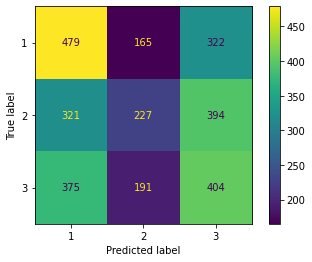

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


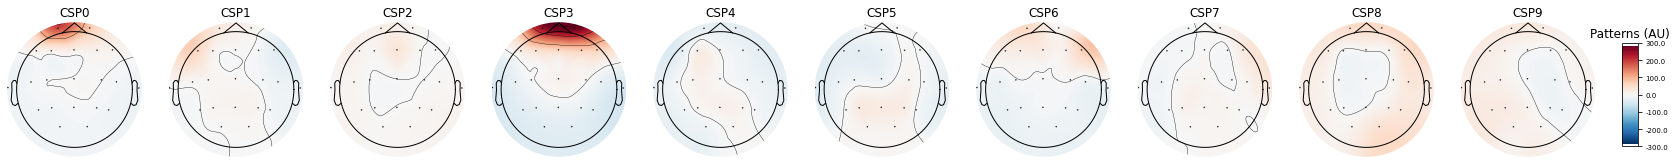




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.4411


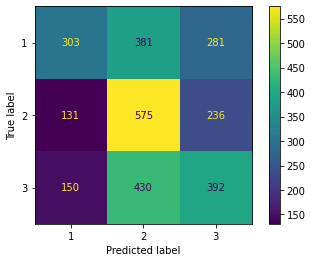

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


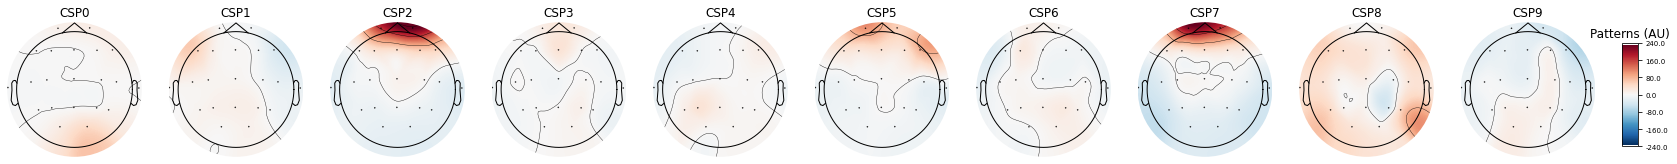




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.3381


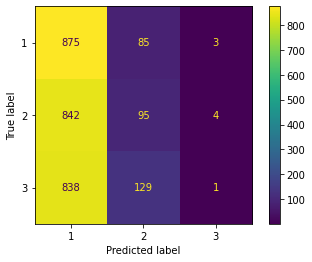

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


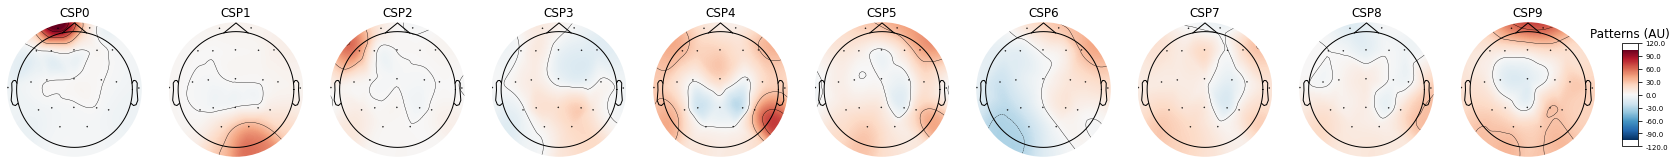

In [27]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_svm_kernel = ["rbf", "rbf", "sigmoid"]
best_found_svm_c = [10, 10, 1]
best_found_svm_gamma = ["auto", "scale", "scale"]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_ids_to_test[i])
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raws = CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine test data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        del mne_raws
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    svm = SVC(kernel= best_found_svm_kernel[i],
              C= best_found_svm_c[i],
              gamma= best_found_svm_gamma[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_svm_kernel
del best_found_svm_c
del best_found_svm_gamma
del i
del X_test
del y_test
del X_train
del y_train
del csp
del svm
del train_subjects
del train_subject
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound

<hr>

### New subject: RF classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For RF:
            - Bootstrap is always set to True as it is, besides random feature subsets, one of the ways to reduce data biases during training
            - The metric used for splitting criterion is gini as it is faster than entropy and the performance difference is negligible when looking at the experimental notebooks
            - Number of estimators: 10 | 50 | 100 | 250 | 500
            - Max depth of a tree: None | 3 | 10 | 20 | 35 | 50 | 75 | 100
            - Minimum number of samples to do a split: 2 | 5 | 10
            - Minimum samples to have a leaf is not set as it is related to the number of samples per split and max depth of the tree
            - Maximum features per tree: sqrt | log2 | None
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [28]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                ###################### PREPARE DATA ######################
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                rf = RandomForestClassifier(bootstrap= True,
                                            criterion= "gini")
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('RF', rf)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 6,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [4, 6, 10],
                               "RF__n_estimators": [10, 50, 100, 250, 500],
                               "RF__max_depth": [None, 3, 10],
                               "RF__min_samples_split": [2, 5, 10],
                               "RF__max_features": ["sqrt", "log2", "None", 0.2, 0.4, 0.6]}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/newsubject/subject{subject_id}/gridsearch_csprf.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del rf
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
                del train_subject
                del train_subjects
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject**      | **CSP + RF: cross validation accuracy** | **CSP + RF: test split accuracy** | **Config**                                                                                               |
|------------------|-----------------------------------------|-----------------------------------|----------------------------------------------------------------------------------------------------------|
| B (Train on C&E) | 0.5983 +- 0.0068                        | 0.3923                            | 10 CSP components \| RF with None max depth, 0.2 max features, 2 min samples split and 500 estimators    |
| C (Train on B&E) | 0.504 +- 0.0197                         | 0.4571                            | 10 CSP components \| RF with None max depth, sqrt max features, 10 min samples split and 250 estimators  |
| E (Train on B&C) | 0.572 +- 0.0274                         | 0.3715                            | 10 CSP components \| RF with 10 max depth, log2 max features, 10 min samples split and 250 estimators    |

Again, performance is poor and LDA, SVM and RF perform very equal.
It is clear the limiting factor here is the CSP feature extraction rather then the ML classifier.

In [29]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/newsubject/subject{subject_id}/gridsearch_csprf.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {np.round(grid_search.best_score_, 4)} +- {np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4)} with the following parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.5983 +- 0.0068 with the following parameters
{'CSP__n_components': 10, 'RF__max_depth': None, 'RF__max_features': 0.2, 'RF__min_samples_split': 2, 'RF__n_estimators': 500}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
589      20.396840      0.119464         0.145453        0.001384   
564      21.546974      0.100174         0.150286        0.006573   
549      21.191920      0.102049         0.149952        0.006530   
593      17.990606      0.074942         0.078975        0.001000   
599      19.955647      0.077388         0.139123        0.004945   
543      18.418969      0.092091         0.078309        0.002867   
562      17.016915      0.072964         0.038488        0.001500   
614      22.602305      0.167663         0.137623        0.006234   
554      21.316381      0.120976         0.138123        0.004057   
597      16.653864      0.062934         0.037322        0.001374   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
589                      10                None                    0.2   
564                      10                None                   log2   
549                      10                None                   sqrt   
593                      10                None                    0.2   
599                      10                None                    0.2   
543                      10                None                   sqrt   
562                      10                None                   log2   
614                      10                None                    0.4   
554                      10                None                   sqrt   
597                      10                None                    0.2   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
589                           2                    500           0.608968   
564                           5                    500           0.601668   
549                           5                    500           0.605839   
593                           5                    250           0.599583   
599                          10                    500           0.600626   
543                           2                    250           0.606882   
562                           5                    100           0.595412   
614                          10                    500           0.602711   
554                          10                    500           0.604797   
597                          10                    100           0.603754   

     ...  std_test_score  rank_test_score  split0_train_score  \
589  ...        0.006821                1            1.000000   
564  ...        0.008195                2            0.999791   
549  ...        0.005484                3            1.000000   
593  ...        0.006059                4            1.000000   
599  ...        0.004754                5            0.974541   
543  ...        0.008020                6            1.000000   
562  ...        0.004059                7            0.998748   
614  ...        0.007473                8            0.977880   
554  ...        0.007279                9            0.977045   
597  ...        0.007325               10            0.970993   

     split1_train_score  split2_train_score  split3_train_score  \
589            1.000000            1.000000            1.000000   
564            0.999583            0.999791            0.999791   
549            0.999583            0.999583            0.999165   
593            0.999374            0.998957            0.999165   
599            0.973706            0.974958            0.975381   
543            1.000000            1.000000            1.000000   
562            0.998331            0.998539            0.998331   
614            0.975584            0.973080            0.975798   
554            0.974124            0.974332            0.976007   
597            0.968280            0.969533            0.970791   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
589            1.000000            1.000000    



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
395      15.437252      0.063028              0.0             0.0   
480      15.514561      0.045379              0.0             0.0   
402      15.491068      0.079607              0.0             0.0   
401      15.473740      0.071803              0.0             0.0   
400      15.474574      0.082528              0.0             0.0   
399      15.560380      0.048912              0.0             0.0   
398      15.522059      0.037724              0.0             0.0   
397      15.457746      0.083142              0.0             0.0   
403      15.566711      0.089764              0.0             0.0   
404      15.692171      0.051239              0.0             0.0   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
395                       6                   3                   None   
480                       6                  10                   None   
402                       6                   3                   None   
401                       6                   3                   None   
400                       6                   3                   None   
399                       6                   3                   None   
398                       6                   3                   None   
397                       6                   3                   None   
403                       6                   3                   None   
404                       6                   3                   None   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
395                           5                     10                NaN   
480                           2                     10                NaN   
402                          10                    100                NaN   
401                          10                     50                NaN   
400                          10                     10                NaN   
399                           5                    500                NaN   
398                           5                    250                NaN   
397                           5                    100                NaN   
403                          10                    250                NaN   
404                          10                    500                NaN   

     ...  std_test_score  rank_test_score  split0_train_score  \
395  ...             NaN              801                 NaN   
480  ...             NaN              802                 NaN   
402  ...             NaN              803                 NaN   
401  ...             NaN              804                 NaN   
400  ...             NaN              805                 NaN   
399  ...             NaN              806                 NaN   
398  ...             NaN              807                 NaN   
397  ...             NaN              808                 NaN   
403  ...             NaN              809                 NaN   
404  ...             NaN              810                 NaN   

     split1_train_score  split2_train_score  split3_train_score  \
395                 NaN                 NaN                 NaN   
480                 NaN                 NaN                 NaN   
402                 NaN                 NaN                 NaN   
401                 NaN                 NaN                 NaN   
400                 NaN                 NaN                 NaN   
399                 NaN                 NaN                 NaN   
398                 NaN                 NaN                 NaN   
397                 NaN                 NaN                 NaN   
403                 NaN                 NaN                 NaN   
404                 NaN                 NaN                 NaN   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
395                 NaN                 NaN    



In total there are 810 different configurations tested.
The best mean test score is 0.5983
There are 1 configurations with this maximum score
There are 118 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count      118.000000    118.000000       118.000000    1.180000e+02   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean        18.523367      0.090960         0.068734    2.968795e-03   
std          2.313453      0.032335         0.044180    2.197256e-03   
min         16.110704      0.028613         0.022993    2.973602e-07   
25%         16.710180      0.069915         0.033906    1.076640e-03   
50%         17.727023      0.087135         0.065479    2.362203e-03   
75%         19.958521      0.110311         0.109424    4.458532e-03   
max         25.622677      0.181459         0.160616    9.119440e-03   

        param_CSP__n_components  param_RF__max_depth  param_RF__max_features  \
count                     118.0                 59.0                   118.0   
unique                      1.0                  1.0                     5.0   
top                        10.0                 10.0                     0.2   
freq                      118.0                 59.0                    24.0   
mean                        NaN                  NaN                     NaN   
std                         NaN                  NaN                     NaN   
min                         NaN                  NaN                     NaN   
25%                         NaN                  NaN                     NaN   
50%                         NaN                  NaN                     NaN   
75%                         NaN                  NaN                     NaN   
max                         NaN                  NaN                     NaN   

        param_RF__min_samples_split  param_RF__n_estimators  \
count                         118.0                   118.0   
unique                          3.0                     4.0   
top                            10.0                   500.0   
freq                           40.0                    30.0   
mean                            NaN                     NaN   
std                             NaN                     NaN   
min                             NaN                     NaN   
25%                             NaN                     NaN   
50%                             NaN                     NaN   
75%                             NaN                     NaN   
max                             NaN                     NaN   

        split0_test_score  ...  std_test_score  rank_test_score  \
count          118.000000  ...      118.000000       118.000000   
unique                NaN  ...             NaN              NaN   
top                   NaN  ...             NaN              NaN   
freq                  NaN  ...             NaN              NaN   
mean             0.594334  ...        0.007290        59.483051   
std              0.007406  ...        0.002076        34.199448   
min              0.571429  ...        0.001496         1.000000   
25%              0.589155  ...        0.006116        30.250000   
50%              0.594891  ...        0.007050        59.500000   
75%              0.599583  ...        0.008702        88.750000   
max              0.612096  ...        0.013020       118.000000   

        split0_train_score  split1_train_score  split2_train_score  \
count           118.000000          118.000000          118.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.917279            0.922068            0.927538   
std               0.075238            0.069765            0.064850   
min               0.802170            0.821369            0.827629   
25%               0.850219            0.859401            0.




####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.504 +- 0.0197 with the following parameters
{'CSP__n_components': 10, 'RF__max_depth': None, 'RF__max_features': 'sqrt', 'RF__min_samples_split': 10, 'RF__n_estimators': 250}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
553      18.635067      0.116426         0.076476        0.001258   
769      19.202720      0.065640         0.122295        0.003036   
728      18.026761      0.072242         0.067979        0.005506   
784      21.599124      0.049293         0.129792        0.005667   
568      18.640399      0.027713         0.077142        0.003530   
543      18.800348      0.091748         0.085306        0.004569   
793      18.594747      0.102751         0.065146        0.000687   
773      17.441281      0.074579         0.066979        0.004581   
613      19.381663      0.051025         0.076476        0.003946   
732      16.619709      0.058036         0.033490        0.000500   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
553                      10                None                   sqrt   
769                      10                  10                    0.2   
728                      10                  10                   sqrt   
784                      10                  10                    0.4   
568                      10                None                   log2   
543                      10                None                   sqrt   
793                      10                  10                    0.4   
773                      10                  10                    0.2   
613                      10                None                    0.4   
732                      10                  10                   sqrt   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
553                          10                    250           0.524505   
769                           2                    500           0.508863   
728                           5                    250           0.514077   
784                           2                    500           0.506778   
568                          10                    250           0.506778   
543                           2                    250           0.516163   
793                          10                    250           0.505735   
773                           5                    250           0.507821   
613                          10                    250           0.517205   
732                          10                    100           0.504692   

     ...  std_test_score  rank_test_score  split0_train_score  \
553  ...        0.019697                1            0.986642   
769  ...        0.015240                2            0.836777   
728  ...        0.018853                3            0.821958   
784  ...        0.018060                4            0.848257   
568  ...        0.014630                5            0.985598   
543  ...        0.019542                6            1.000000   
793  ...        0.017471                7            0.794615   
773  ...        0.010542                8            0.817783   
613  ...        0.013284                9            0.986433   
732  ...        0.013862               10            0.788771   

     split1_train_score  split2_train_score  split3_train_score  \
553            0.985181            0.985184            0.985601   
769            0.828637            0.852045            0.854549   
728            0.811313            0.823664            0.834098   
784            0.835525            0.851210            0.854967   
568            0.985807            0.986436            0.986853   
543            1.000000            1.000000            1.000000   
793            0.777082            0.798623            0.811352   
773            0.815070            0.830968            0.834516   
613            0.984346            0.986018            0.986853   
732            0.775204            0.788189            0.807179   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
553            0.987270            0.987688    



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
395      15.575874      0.073233              0.0             0.0   
480      15.624526      0.083111              0.0             0.0   
402      15.747320      0.060066              0.0             0.0   
401      15.591869      0.066770              0.0             0.0   
400      15.587371      0.071206              0.0             0.0   
399      15.706500      0.052762              0.0             0.0   
398      15.688672      0.048909              0.0             0.0   
397      15.570210      0.069659              0.0             0.0   
403      15.727326      0.058782              0.0             0.0   
404      15.805801      0.062113              0.0             0.0   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
395                       6                   3                   None   
480                       6                  10                   None   
402                       6                   3                   None   
401                       6                   3                   None   
400                       6                   3                   None   
399                       6                   3                   None   
398                       6                   3                   None   
397                       6                   3                   None   
403                       6                   3                   None   
404                       6                   3                   None   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
395                           5                     10                NaN   
480                           2                     10                NaN   
402                          10                    100                NaN   
401                          10                     50                NaN   
400                          10                     10                NaN   
399                           5                    500                NaN   
398                           5                    250                NaN   
397                           5                    100                NaN   
403                          10                    250                NaN   
404                          10                    500                NaN   

     ...  std_test_score  rank_test_score  split0_train_score  \
395  ...             NaN              801                 NaN   
480  ...             NaN              802                 NaN   
402  ...             NaN              803                 NaN   
401  ...             NaN              804                 NaN   
400  ...             NaN              805                 NaN   
399  ...             NaN              806                 NaN   
398  ...             NaN              807                 NaN   
397  ...             NaN              808                 NaN   
403  ...             NaN              809                 NaN   
404  ...             NaN              810                 NaN   

     split1_train_score  split2_train_score  split3_train_score  \
395                 NaN                 NaN                 NaN   
480                 NaN                 NaN                 NaN   
402                 NaN                 NaN                 NaN   
401                 NaN                 NaN                 NaN   
400                 NaN                 NaN                 NaN   
399                 NaN                 NaN                 NaN   
398                 NaN                 NaN                 NaN   
397                 NaN                 NaN                 NaN   
403                 NaN                 NaN                 NaN   
404                 NaN                 NaN                 NaN   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
395                 NaN                 NaN    



In total there are 810 different configurations tested.
The best mean test score is 0.504
There are 1 configurations with this maximum score
There are 121 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count      121.000000    121.000000       121.000000      121.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean        18.434562      0.086518         0.067312        0.002797   
std          2.458859      0.052362         0.044733        0.002920   
min         15.776477      0.025723         0.014662        0.000372   
25%         16.486251      0.059938         0.028991        0.000897   
50%         17.441281      0.079024         0.044653        0.001999   
75%         19.828854      0.100487         0.085306        0.003946   
max         26.361274      0.554112         0.162782        0.024923   

        param_CSP__n_components  param_RF__max_depth param_RF__max_features  \
count                     121.0                 62.0                    121   
unique                      1.0                  1.0                      5   
top                        10.0                 10.0                   sqrt   
freq                      121.0                 62.0                     25   
mean                        NaN                  NaN                    NaN   
std                         NaN                  NaN                    NaN   
min                         NaN                  NaN                    NaN   
25%                         NaN                  NaN                    NaN   
50%                         NaN                  NaN                    NaN   
75%                         NaN                  NaN                    NaN   
max                         NaN                  NaN                    NaN   

        param_RF__min_samples_split  param_RF__n_estimators  \
count                         121.0                   121.0   
unique                          3.0                     5.0   
top                            10.0                   250.0   
freq                           41.0                    30.0   
mean                            NaN                     NaN   
std                             NaN                     NaN   
min                             NaN                     NaN   
25%                             NaN                     NaN   
50%                             NaN                     NaN   
75%                             NaN                     NaN   
max                             NaN                     NaN   

        split0_test_score  ...  std_test_score  rank_test_score  \
count          121.000000  ...      121.000000       121.000000   
unique                NaN  ...             NaN              NaN   
top                   NaN  ...             NaN              NaN   
freq                  NaN  ...             NaN              NaN   
mean             0.505976  ...        0.016065        60.983471   
std              0.008143  ...        0.002831        35.078480   
min              0.477581  ...        0.006824         1.000000   
25%              0.500521  ...        0.014393        31.000000   
50%              0.505735  ...        0.016201        61.000000   
75%              0.509906  ...        0.018151        91.000000   
max              0.528676  ...        0.021420       121.000000   

        split0_train_score  split1_train_score  split2_train_score  \
count           121.000000          121.000000          121.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.901184            0.895796            0.903739   
std               0.092733            0.097573            0.090266   
min               0.740138            0.746399            0.742070   
25%               0.818618            0.807973            0.823664   
50




####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.572 +- 0.0274 with the following parameters
{'CSP__n_components': 10, 'RF__max_depth': 10, 'RF__max_features': 'log2', 'RF__min_samples_split': 10, 'RF__n_estimators': 250}


 Top 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
748      17.974061      0.036909         0.069525        0.005292   
723      18.040514      0.027358         0.072144        0.006666   
724      20.379906      0.075229         0.132791        0.002543   
738      17.946493      0.067233         0.069855        0.002548   
599      19.761754      0.066341         0.140789        0.001572   
554      21.076969      0.053030         0.141088        0.004210   
788      18.619474      0.056110         0.071977        0.001000   
589      20.146783      0.094316         0.151330        0.002314   
782      16.848380      0.075064         0.035989        0.001154   
593      17.884179      0.078220         0.081308        0.000943   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
748                      10                  10                   log2   
723                      10                  10                   sqrt   
724                      10                  10                   sqrt   
738                      10                  10                   log2   
599                      10                None                    0.2   
554                      10                None                   sqrt   
788                      10                  10                    0.4   
589                      10                None                    0.2   
782                      10                  10                    0.4   
593                      10                None                    0.2   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
748                          10                    250           0.551042   
723                           2                    250           0.550000   
724                           2                    500           0.545833   
738                           2                    250           0.546875   
599                          10                    500           0.546875   
554                          10                    500           0.557292   
788                           5                    250           0.542708   
589                           2                    500           0.553125   
782                           2                    100           0.548958   
593                           5                    250           0.547917   

     ...  std_test_score  rank_test_score  split0_train_score  \
748  ...        0.027421                1            0.828851   
723  ...        0.026275                2            0.880967   
724  ...        0.023645                3            0.879716   
738  ...        0.022907                4            0.889306   
599  ...        0.023273                5            0.974567   
554  ...        0.022700                6            0.973108   
788  ...        0.023626                7            0.873254   
589  ...        0.020125                8            1.000000   
782  ...        0.023685                9            0.888680   
593  ...        0.026656               10            0.999792   

     split1_train_score  split2_train_score  split3_train_score  \
748            0.824474            0.835105            0.805127   
723            0.872837            0.883886            0.857441   
724            0.869502            0.889097            0.858483   
738            0.869502            0.885970            0.857024   
599            0.973317            0.971857            0.975406   
554            0.975610            0.973108            0.976865   
788            0.866375            0.882218            0.856607   
589            1.000000            1.000000            1.000000   
782            0.878883            0.894309            0.866403   
593            0.998958            0.999792            0.999375   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
748            0.815340            0.821592    



 Worst 10 grid search results: 


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
673      15.740538      0.035517              0.0             0.0   
482      15.650189      0.041667              0.0             0.0   
480      15.643253      0.045496              0.0             0.0   
403      15.743871      0.060389              0.0             0.0   
402      15.724227      0.056559              0.0             0.0   
401      15.632754      0.032020              0.0             0.0   
400      15.648134      0.054615              0.0             0.0   
399      15.752221      0.020398              0.0             0.0   
481      15.648571      0.037089              0.0             0.0   
404      15.799369      0.033787              0.0             0.0   

    param_CSP__n_components param_RF__max_depth param_RF__max_features  \
673                      10                   3                   None   
482                       6                  10                   None   
480                       6                  10                   None   
403                       6                   3                   None   
402                       6                   3                   None   
401                       6                   3                   None   
400                       6                   3                   None   
399                       6                   3                   None   
481                       6                  10                   None   
404                       6                   3                   None   

    param_RF__min_samples_split param_RF__n_estimators  split0_test_score  \
673                          10                    250                NaN   
482                           2                    100                NaN   
480                           2                     10                NaN   
403                          10                    250                NaN   
402                          10                    100                NaN   
401                          10                     50                NaN   
400                          10                     10                NaN   
399                           5                    500                NaN   
481                           2                     50                NaN   
404                          10                    500                NaN   

     ...  std_test_score  rank_test_score  split0_train_score  \
673  ...             NaN              801                 NaN   
482  ...             NaN              802                 NaN   
480  ...             NaN              803                 NaN   
403  ...             NaN              804                 NaN   
402  ...             NaN              805                 NaN   
401  ...             NaN              806                 NaN   
400  ...             NaN              807                 NaN   
399  ...             NaN              808                 NaN   
481  ...             NaN              809                 NaN   
404  ...             NaN              810                 NaN   

     split1_train_score  split2_train_score  split3_train_score  \
673                 NaN                 NaN                 NaN   
482                 NaN                 NaN                 NaN   
480                 NaN                 NaN                 NaN   
403                 NaN                 NaN                 NaN   
402                 NaN                 NaN                 NaN   
401                 NaN                 NaN                 NaN   
400                 NaN                 NaN                 NaN   
399                 NaN                 NaN                 NaN   
481                 NaN                 NaN                 NaN   
404                 NaN                 NaN                 NaN   

     split4_train_score  split5_train_score  mean_train_score  std_train_score  
673                 NaN                 NaN    



In total there are 810 different configurations tested.
The best mean test score is 0.572
There are 1 configurations with this maximum score
There are 184 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count      184.000000    184.000000       184.000000      184.000000   
unique            NaN           NaN              NaN             NaN   
top               NaN           NaN              NaN             NaN   
freq              NaN           NaN              NaN             NaN   
mean        17.993735      0.058306         0.068691        0.003144   
std          2.053023      0.027998         0.044409        0.002626   
min         15.743215      0.016524         0.011330        0.000373   
25%         16.397151      0.041205         0.031448        0.001067   
50%         17.402916      0.053118         0.066000        0.002296   
75%         19.133591      0.068942         0.118619        0.004520   
max         25.447294      0.232704         0.163992        0.014356   

        param_CSP__n_components  param_RF__max_depth  param_RF__max_features  \
count                     184.0                117.0                   184.0   
unique                      2.0                  2.0                     5.0   
top                        10.0                 10.0                     0.2   
freq                      121.0                115.0                    39.0   
mean                        NaN                  NaN                     NaN   
std                         NaN                  NaN                     NaN   
min                         NaN                  NaN                     NaN   
25%                         NaN                  NaN                     NaN   
50%                         NaN                  NaN                     NaN   
75%                         NaN                  NaN                     NaN   
max                         NaN                  NaN                     NaN   

        param_RF__min_samples_split  param_RF__n_estimators  \
count                         184.0                   184.0   
unique                          3.0                     5.0   
top                            10.0                   500.0   
freq                           64.0                    48.0   
mean                            NaN                     NaN   
std                             NaN                     NaN   
min                             NaN                     NaN   
25%                             NaN                     NaN   
50%                             NaN                     NaN   
75%                             NaN                     NaN   
max                             NaN                     NaN   

        split0_test_score  ...  std_test_score  rank_test_score  \
count          184.000000  ...      184.000000       184.000000   
unique                NaN  ...             NaN              NaN   
top                   NaN  ...             NaN              NaN   
freq                  NaN  ...             NaN              NaN   
mean             0.540138  ...        0.024112        92.483696   
std              0.007999  ...        0.002554        53.273803   
min              0.515625  ...        0.018583         1.000000   
25%              0.534375  ...        0.022676        46.750000   
50%              0.541667  ...        0.023931        92.500000   
75%              0.545833  ...        0.025917       138.250000   
max              0.564583  ...        0.031857       184.000000   

        split0_train_score  split1_train_score  split2_train_score  \
count           184.000000          184.000000          184.000000   
unique                 NaN                 NaN                 NaN   
top                    NaN                 NaN                 NaN   
freq                   NaN                 NaN                 NaN   
mean              0.884980            0.877607            0.881343   
std               0.088171            0.093663            0.092499   
min               0.563894            0.564728            0.576819   
25%               0.824630            0.812539            0.




####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.3909


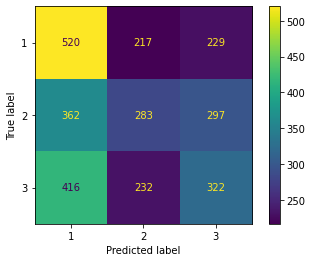

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


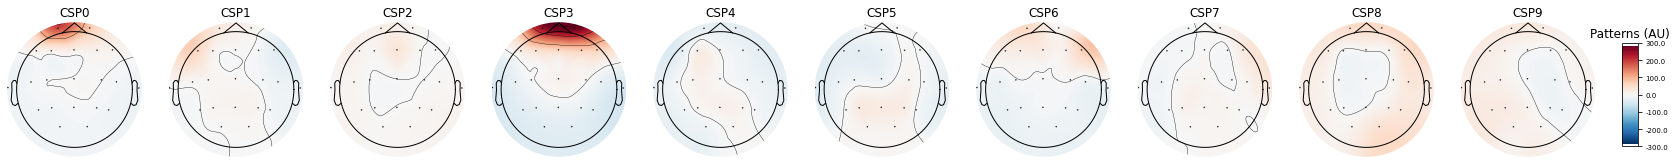




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.4453


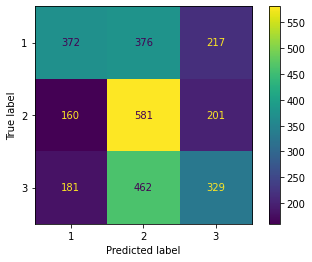

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


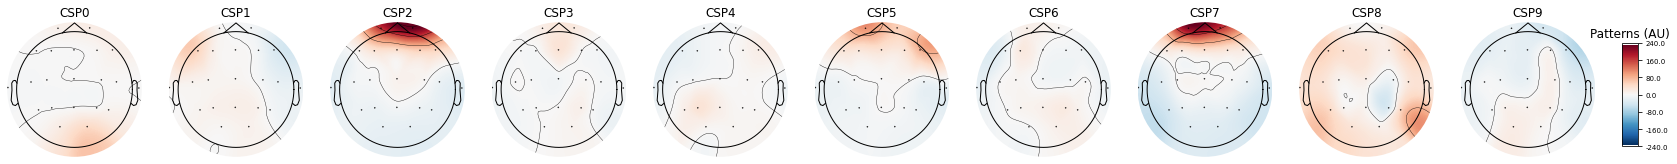




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.3708


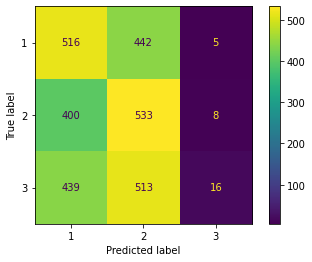

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


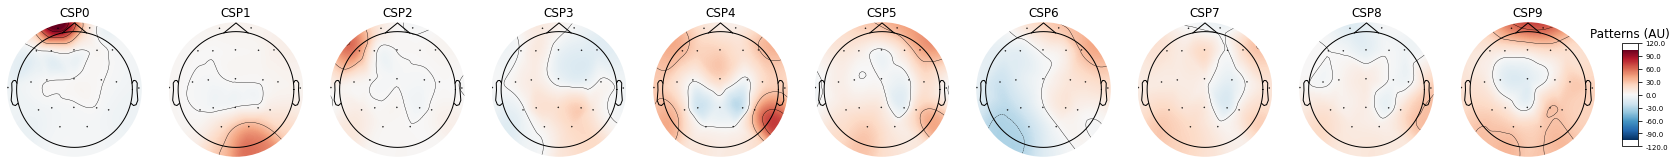

In [30]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_rf_depth = [None, None, 10]
best_found_rf_max_featues = [0.2, "sqrt", "log2"]
best_found_rf_min_sample = [2, 10, 10]
best_found_rf_n_estimators = [500, 250, 250]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_ids_to_test[i])
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raws = CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine test data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        del mne_raws
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    rf = RandomForestClassifier(bootstrap= True,
                                criterion= "gini",
                                max_depth= best_found_rf_depth[i],
                                max_features= best_found_rf_max_featues[i],
                                min_samples_split= best_found_rf_min_sample[i],
                                n_estimators= best_found_rf_n_estimators[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('RF', rf)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_rf_depth
del best_found_rf_max_featues
del best_found_rf_min_sample
del best_found_rf_n_estimators
del i
del X_test
del y_test
del X_train
del y_train
del csp
del rf
del train_subjects
del train_subject
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound